<a href="https://colab.research.google.com/github/frpbotero/bank_customer_churn_analysis/blob/main/bank_customer_churn_analysis_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Instalações e importações

In [ ]:
!pip install pandas
!pip install kaggle --upgrade
!pip install xgboost lightgbm catboost
!pip install feature_engine
!pip install imblearn

Requirement already up-to-date: kaggle in /home/dom-paje/.local/lib/python3.8/site-packages (1.7.4.5)


In [ ]:
# ==========================
# 1. Bibliotecas Básicas
# ==========================
import os
import pandas as pd
from IPython.display import Markdown, display

# ==========================
# 2. Visualização
# ==========================
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# ==========================
# 3. Estatística
# ==========================
import scipy.stats as stats
from scipy.stats import pearsonr, mannwhitneyu, kruskal, chi2_contingency

# ==========================
# 4. Pré-processamento
# ==========================
from sklearn.preprocessing import (
    StandardScaler,
    LabelEncoder,
    OneHotEncoder,
    label_binarize
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from feature_engine.outliers import Winsorizer

# ==========================
# 5. Modelos de Machine Learning
# ==========================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# ==========================
# 6. Clusterização
# ==========================
from sklearn.cluster import KMeans, DBSCAN

# ==========================
# 7. Avaliação de Modelos
# ==========================
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

# ==========================
# 8. Validação e Otimização
# ==========================
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score
)

# ==========================
# 9. Pipelines e Redução de Dimensão
# ==========================
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline as ImbPipeline

# ==========================
# 10. Balanceamento de Classes
# ==========================
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

# ==========================
# 11. Persistência
# ==========================
import joblib

# ==========================
# 12. Recursos Específicos
# ==========================
from dotenv import load_dotenv
load_dotenv()

/home/dom-paje/.local/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


True

In [ ]:

try:
    # 2. Pega as variáveis carregadas
    # OBS: Usamos 'os.getenv' e não 'os.get'
    k_username = os.getenv('KAGGLE_USERNAME')
    k_key = os.getenv('KAGGLE_KEY')

    # Verifica se as chaves foram encontradas antes de prosseguir
    if not k_username or not k_key:
        raise ValueError("Chaves não encontradas no arquivo .env")

    # 3. Define explicitamente para o ambiente (necessário para a lib do Kaggle)
    os.environ["KAGGLE_USERNAME"] = k_username
    os.environ["KAGGLE_KEY"] = k_key

    print("Credenciais configuradas com sucesso.")

    # 4. Importa o kaggle DEPOIS de definir as variáveis de ambiente
    import kaggle

    # Teste simples (opcional)
    # kaggle.api.authenticate()
    # print("Autenticação Kaggle realizada.")

except Exception as e:
    print(f"Erro: {e}")
    print("Certifique-se de que o arquivo .env existe e contém KAGGLE_USERNAME e KAGGLE_KEY.")

Credenciais configuradas com sucesso.


## Introdução

A retenção de clientes é um dos pilares essenciais para a sustentabilidade financeira de qualquer empresa do setor bancário. A perda de clientes — conhecida como churn — representa não apenas redução imediata de receita, mas também custos adicionais para aquisição de novos consumidores e possíveis impactos na reputação da instituição. Compreender os fatores que levam um cliente a encerrar seu relacionamento é, portanto, um passo decisivo para construir estratégias mais eficazes de fidelização.

Este projeto tem como objetivo analisar e interpretar as variáveis associadas ao churn em um banco fictício, identificando padrões, correlações e pesos relativos de cada feature no comportamento de saída dos clientes. A partir desse entendimento, busca-se responder à dor central do negócio: por que clientes deixam o banco e como podemos antecipar esses casos?

O sucesso, dentro deste contexto, está diretamente relacionado à capacidade de prever a probabilidade de churn com precisão e orientar ações práticas que reduzam a perda de clientes. Quanto melhor o modelo entender os fatores críticos de evasão, maior será a possibilidade de intervenção preventiva e, consequentemente, de retenção.

## Sobre o Dataset


O dataset utilizado neste estudo é o repositório público radheshyamkollipara/bank-customer-churn, composto por 10.000 registros e 18 variáveis que descrevem informações demográficas, características de conta, produtos financeiros e o indicador final de churn. Embora fictício, o conjunto de dados apresenta complexidade suficiente para simular um cenário realista de análise de comportamento de clientes no ambiente bancário.

In [ ]:
import kaggle
# Definir o nome do dataset
dataset_name = 'radheshyamkollipara/bank-customer-churn'

# Opcional: Criar um diretório para o dataset
download_path = './kaggle_data'
if not os.path.exists(download_path):
    os.makedirs(download_path)

# Baixar o dataset
print(f"Baixando o dataset {dataset_name}...")
kaggle.api.dataset_download_files(dataset_name, path=download_path, unzip=True)
print(f"Dataset baixado e descompactado em {download_path}/")

# Listar os arquivos baixados (opcional)
print("Arquivos baixados:")
for file_name in os.listdir(download_path):
    print(f"- {file_name}")

# Encontrar o arquivo CSV principal e carregar no pandas
csv_file = None
for file_name in os.listdir(download_path):
    if file_name.endswith('.csv'):
        csv_file = os.path.join(download_path, file_name)
        break

if csv_file:
    print(f"Carregando o arquivo {csv_file} em um DataFrame do pandas...")
    df_model = pd.read_csv(csv_file)
    display(df_model.head())
else:
    print("Nenhum arquivo CSV encontrado no dataset baixado.")

Baixando o dataset radheshyamkollipara/bank-customer-churn...
Dataset URL: https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn
Dataset baixado e descompactado em ./kaggle_data/
Arquivos baixados:
- Customer-Churn-Records.csv
Carregando o arquivo ./kaggle_data/Customer-Churn-Records.csv em um DataFrame do pandas...


RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  Complain  Satisfaction Score Card Type  \
0        101348.88       1         1                   2   DIAMOND   
1        112542.58       0         1                   3   DIAMOND   
2        113931.57       1         1                   3   DIAMOND   
3         93826.63       0         0                   5      GOLD   
4         79084.10       0         0                   5      GOLD   

   Point Earned  
0           464  
1           456  
2           377  
3           350  
4           425

## Informações do Dataset

In [ ]:
print("Analise de Features\n")
print(df_model.info())

print("\nVerificando valores unicos\n")
print(df_model.nunique())

Analise de Features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RowNumber           10000 non-null  int64  
 1   CustomerId          10000 non-null  int64  
 2   Surname             10000 non-null  object 
 3   CreditScore         10000 non-null  int64  
 4   Geography           10000 non-null  object 
 5   Gender              10000 non-null  object 
 6   Age                 10000 non-null  int64  
 7   Tenure              10000 non-null  int64  
 8   Balance             10000 non-null  float64
 9   NumOfProducts       10000 non-null  int64  
 10  HasCrCard           10000 non-null  int64  
 11  IsActiveMember      10000 non-null  int64  
 12  EstimatedSalary     10000 non-null  float64
 13  Exited              10000 non-null  int64  
 14  Complain            10000 non-null  int64  
 15  Satisfaction Score  10000 non-nul

## Verificando valores nulos ou faltantes

In [ ]:
print(df_model.isnull().sum())

RowNumber             0
CustomerId            0
Surname               0
CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Complain              0
Satisfaction Score    0
Card Type             0
Point Earned          0
dtype: int64


### Remoção de colunas irrelevantes para o modelo

In [ ]:
cols_to_drop = ['RowNumber', 'CustomerId', 'Surname']
df_model = df_model.drop(cols_to_drop, axis=1)

# Analise Exploratória de Dados (EDA)

## Analise Univariada

### Definição de Variáveis

In [ ]:
var_qualitativas = ["IsActiveMember", "HasCrCard", "Gender", "Exited", "Geography", "Card Type", "Complain"]
var_quantitativas = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary", "Satisfaction Score", "Point Earned"]

In [ ]:
print("Informações do Dataset")
display(Markdown("### Variaveis Qualitativas"))
display(df_model[var_qualitativas].astype('object').describe())

display(Markdown("### Variaveis Quantitativas"))
display(df_model[var_quantitativas].describe())

Informações do Dataset


### Variaveis Qualitativas

IsActiveMember  HasCrCard Gender  Exited Geography Card Type  Complain
count            10000      10000  10000   10000     10000     10000     10000
unique               2          2      2       2         3         4         2
top                  1          1   Male       0    France   DIAMOND         0
freq              5151       7055   5457    7962      5014      2507      7956

### Variaveis Quantitativas

CreditScore           Age        Tenure        Balance  NumOfProducts  \
count  10000.000000  10000.000000  10000.000000   10000.000000   10000.000000   
mean     650.528800     38.921800      5.012800   76485.889288       1.530200   
std       96.653299     10.487806      2.892174   62397.405202       0.581654   
min      350.000000     18.000000      0.000000       0.000000       1.000000   
25%      584.000000     32.000000      3.000000       0.000000       1.000000   
50%      652.000000     37.000000      5.000000   97198.540000       1.000000   
75%      718.000000     44.000000      7.000000  127644.240000       2.000000   
max      850.000000     92.000000     10.000000  250898.090000       4.000000   

       EstimatedSalary  Satisfaction Score  Point Earned  
count     10000.000000        10000.000000  10000.000000  
mean     100090.239881            3.013800    606.515100  
std       57510.492818            1.405919    225.924839  
min          11.580000            1.000000    119.000000  
25%       51002.110000            2.000000    410.000000  
50%      100193.915000            3.000000    605.000000  
75%      149388.247500            4.000000    801.000000  
max      199992.480000            5.000000   1000.000000

#### Váriaveis Qualitativas

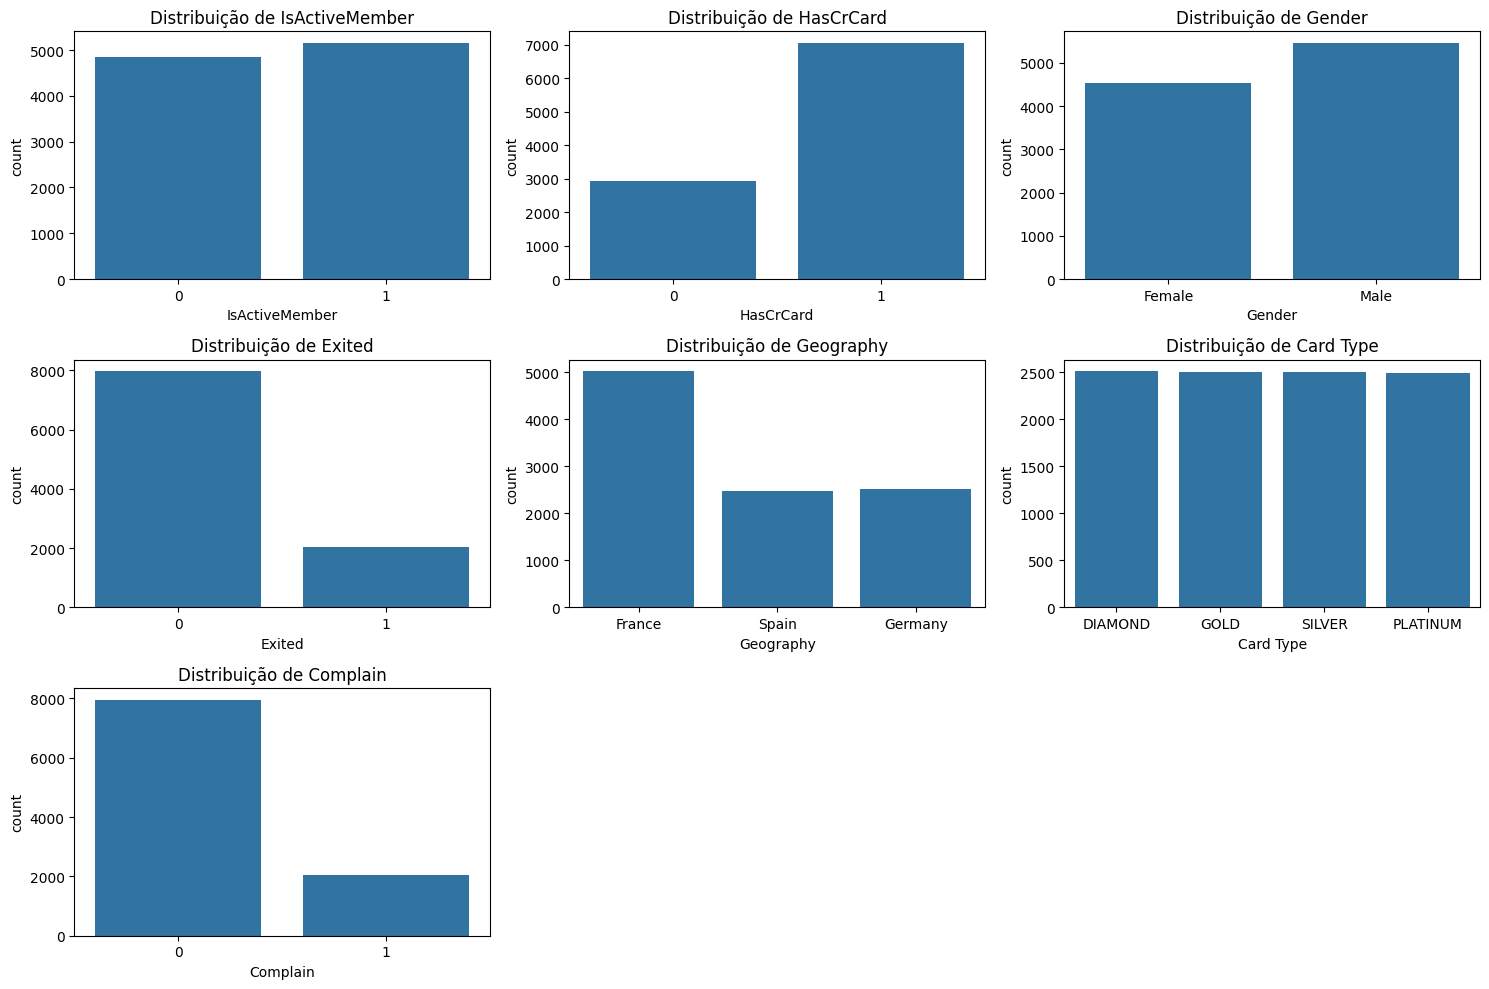

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração do tamanho da figura
plt.figure(figsize=(15, 10))

# Loop para criar um subplot para cada variável
for i, col in enumerate(var_qualitativas):
    plt.subplot(3, 3, i + 1) # Ajuste o grid (3x3) conforme a quantidade de vars
    sns.countplot(data=df_model, x=col)
    plt.title(f'Distribuição de {col}')
    plt.tight_layout()

plt.show()

---

### 📈 Análise das Variáveis Qualitativas

#### 🟦 **Atividade e Engajamento**

* **50% dos clientes permanecem ativos** na base.
* **20% dos clientes saíram** (exit), indicando churn relevante.

#### 💳 **Uso de Produtos**

* **70% dos clientes possuem cartão de crédito.**

#### 👥 **Perfil Demográfico**

* **Mais de 50% dos clientes são homens.**
* **50% dos clientes são da França.**

#### 📞 **Relacionamento**

* **80% dos clientes não fizeram reclamações**, um volume significativamente maior que o dos clientes que registraram algum problema.

#### 📅 **Histórico**

* **Tempo máximo de permanência:** 10 anos.

---

#### ⚠️ **Pontos de Atenção (Resumo Crítico)**

* **A variável alvo é fortemente desbalanceada**, exigindo técnicas específicas para evitar vieses durante o treinamento do modelo.
* **Predomínio de clientes franceses** pode introduzir vieses geográficos, especialmente se o comportamento financeiro for distinto entre franceses, espanhóis e alemães.

---

#### 🧭 **Conclusão (Simplificada)**

A base apresenta **boa adesão a produtos**, **poucas reclamações** e **engajamento razoável**, mas o **churn de 20%** e o **desbalanceamento da variável alvo** devem ser tratados cuidadosamente para garantir modelos preditivos mais consistentes.

---


#### Variaveis Quantitativas

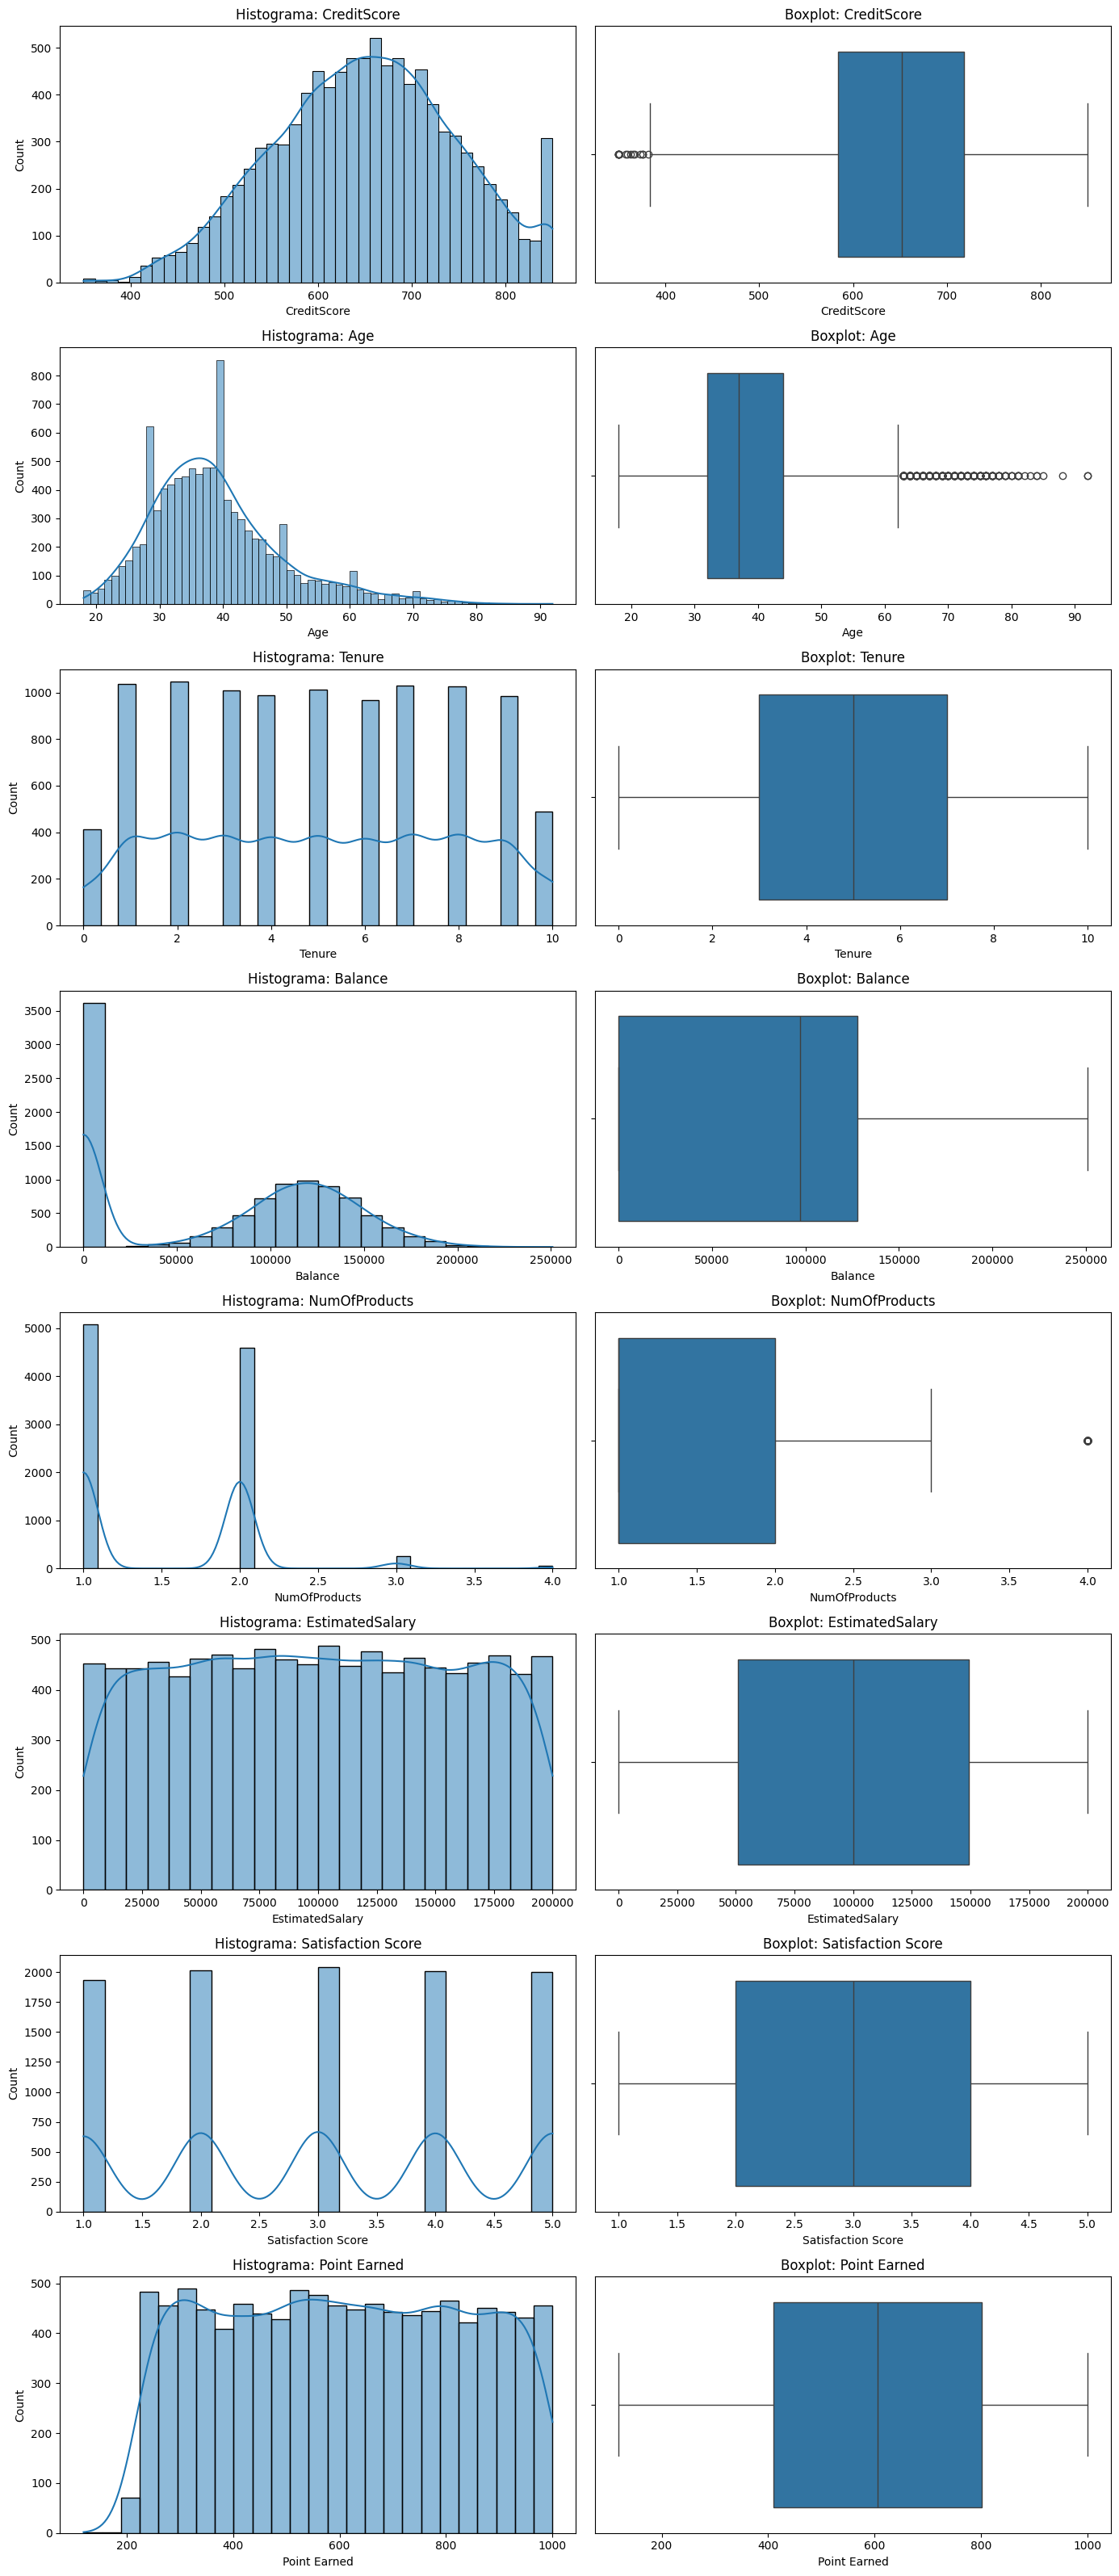

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ajustando o tamanho para caber tudo
fig, axes = plt.subplots(len(var_quantitativas), 2, figsize=(14, len(var_quantitativas) * 4))

for i, col in enumerate(var_quantitativas):
    # Histograma (lado esquerdo)
    sns.histplot(data=df_model, x=col, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Histograma: {col}')

    # Boxplot (lado direito)
    sns.boxplot(data=df_model, x=col, ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot: {col}')

plt.tight_layout()
plt.show()

---

### 📈 **Análise das Variáveis Quantitativas**

#### ⭐ **Credit Score**

* A distribuição é **levemente deslocada para a esquerda**, indicando que a pontuação de crédito tende a ser **um pouco mais alta**.
* Isso sugere que a base é composta majoritariamente por **clientes com bom perfil de crédito**.

---

#### 👤 **Idade**

* A idade apresenta distribuição **suavemente inclinada à esquerda**, mostrando **maior concentração de clientes jovens**.
* A faixa predominante está entre **32 e 45 anos**.
* Existem **alguns outliers acima de 64 anos**, mas representam minoria.

---

#### 🕒 **Tempo de Relacionamento**

* **Menos de 400 clientes têm menos de 1 ano de relacionamento**.
* O tempo máximo é de **10 anos**, mas representa apenas cerca de **500 clientes**.
* A maior concentração está no intervalo de **3 a 7 anos**, exibindo **distribuição bastante uniforme** nessa faixa.

---

#### 🏦 **Balanço (Saldo em Conta)**

* **Mais de 45% dos clientes não possuem saldo**, o que pode indicar:

  * Contas recém-criadas sem movimentação, ou
  * Clientes que não utilizam o banco como instituição financeira principal.

---

#### 📦 **Número de Produtos**

* **Mais de 50% dos clientes possuem pelo menos 1 produto**.
* **Cerca de 40% possuem 2 produtos**.
* Aproximadamente **200 clientes possuem 3 produtos** do banco.

---

#### 💼 **Estimativa Salarial**

* A distribuição de salário é **uniforme**, com maior concentração no intervalo de **50.000 a 150.000**.

---

#### ⭐ **Nota de Satisfação**

* A distribuição das notas é equilibrada, com **maior frequência de avaliações acima de 2 pontos** — sinalizando tendência à satisfação moderada ou elevada.

---


## Analise Bivariada

#### Váriaveis Quantitativa

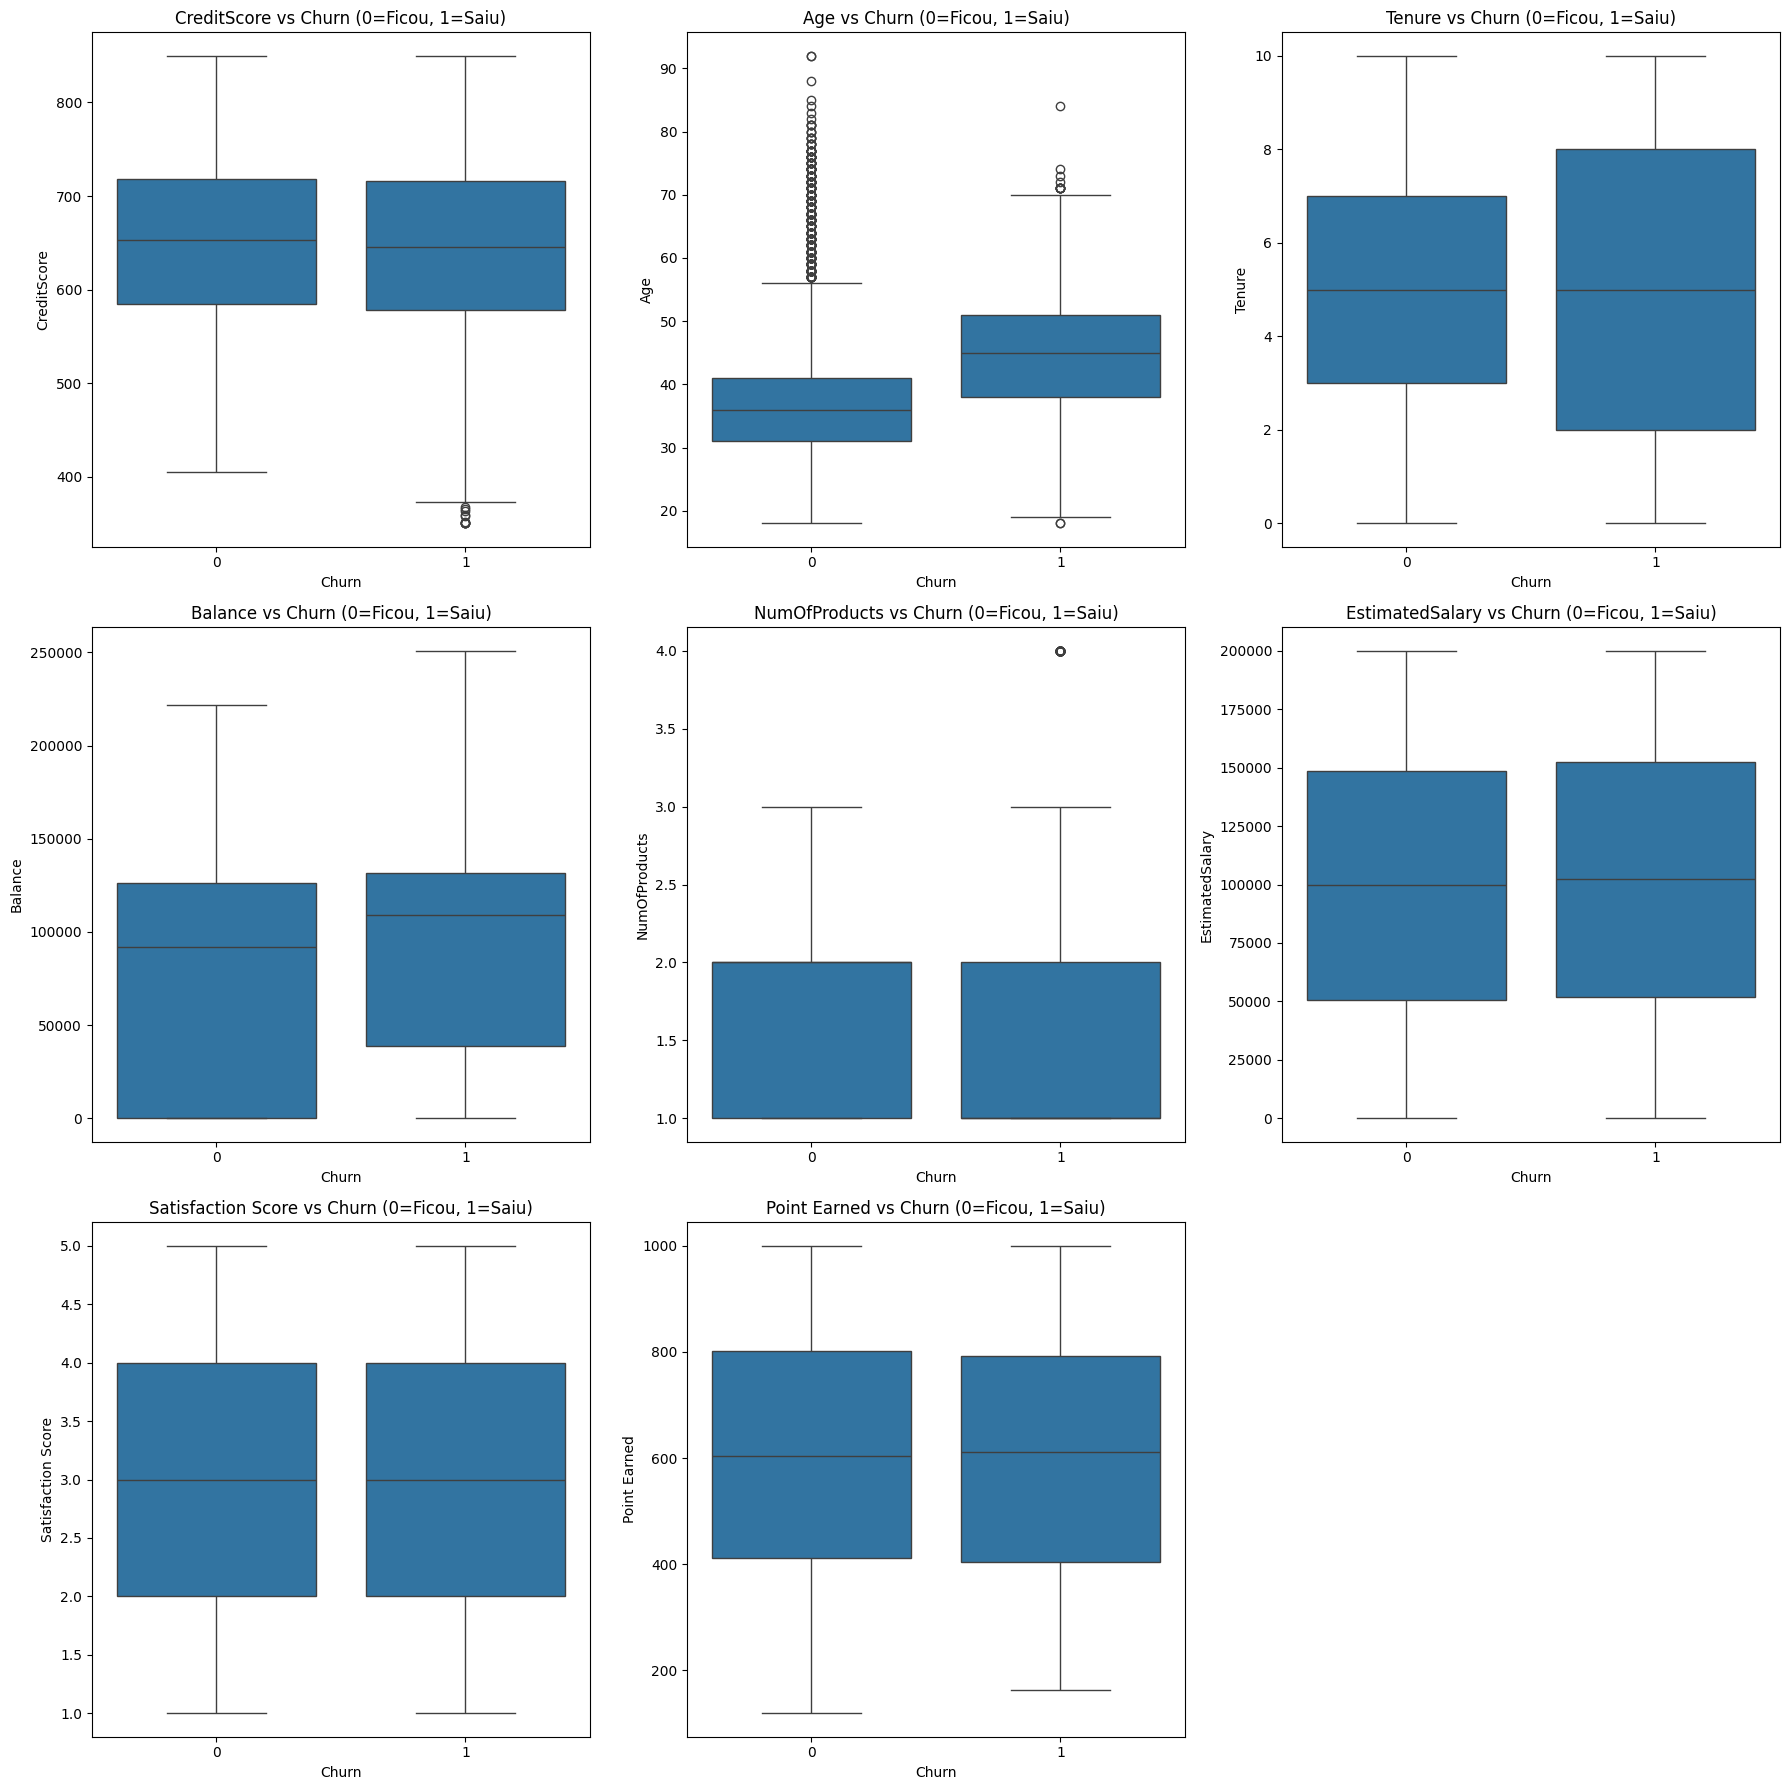

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Número de variáveis quantitativas
n = len(var_quantitativas)

# Define uma grade de subplots (3 colunas e linhas automáticas)
cols = 3
rows = (n + cols - 1) // cols  # cálculo para número ideal de linhas

fig, axes = plt.subplots(rows, cols, figsize=(18, 6 * rows))
axes = axes.flatten()  # facilita indexação linear

# Gera um boxplot por variável
for i, col in enumerate(var_quantitativas):
    sns.boxplot(data=df_model, x='Exited', y=col, ax=axes[i])
    axes[i].set_title(f'{col} vs Churn (0=Ficou, 1=Saiu)', fontsize=12)
    axes[i].set_xlabel("Churn")
    axes[i].set_ylabel(col)

# Remove subplots vazios (caso sobrem)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
df_model.groupby('Exited')['NumOfProducts'].value_counts(normalize=True)

Exited  NumOfProducts
0       2                0.532655
        1                0.461567
        3                0.005777
1       1                0.691364
        2                0.171246
        3                0.107949
        4                0.029441
Name: proportion, dtype: float64

---

#### 📈 Análise das Variáveis Quantitativas

##### ⭐ **1. Idade é um fator crítico para churn**

* Clientes que saem são **claramente mais velhos**.
* A mediana geral fica em torno de **45 anos**, mas o grupo churn tem idades ainda mais elevadas.
  **Conclusão:** idade é um dos preditores mais fortes de churn.

---

#### ⭐ **2. Número de produtos diferencia fortemente quem sai de quem fica**

Mesmo que o boxplot não evidencie, a proporção deixa claro:

##### 🔹 Quem tem **1 produto**:

* **69% do churn** pertence a esse grupo.
* Apenas **46% dos clientes que ficam** têm 1 produto.
  ➡️ **Grande indicador de risco.**

##### 🔹 Quem tem **2 produtos**:

* **53% dos clientes que ficam** têm 2 produtos.
* Apenas **17% dos clientes que saem** têm 2 produtos.
  ➡️ **Indica retenção.**

##### 🔹 Quem tem 3 ou 4 produtos:

* Casos raros, mas aparecem mais no churn do que entre os que ficaram.
  ➡️ Pode sinalizar perfis específicos ou necessidades não atendidas.

---

#### ⭐ **3. Clientes com contas sem saldo são predominantes**

* Mais de **45% não possuem saldo**.
  ➡️ Pode indicar baixa movimentação, uso secundário da conta ou simples inatividade.
  ➡️ Sinal de **risco potencial**, pois falta engajamento.

---

#### ⭐ **4. Renda e saldo NÃO são bons discriminadores de churn**

* As distribuições de **EstimatedSalary** e **Balance** são quase idênticas entre churn e não-churn.
  ➡️ Pouco poder preditivo.

---

#### ⭐ **5. Pontuação de satisfação e pontos acumulados também não diferenciam**

* **SatisfactionScore** e **Point Earned** mostram distribuições muito próximas entre os grupos.
  ➡️ Não ajudam a separar quem sai de quem fica.

---

#### ⭐ **6. Tempo de relacionamento só importa no início**

* Clientes com **menos de 1 ano** têm maior chance de churn.
* Depois disso, a distribuição é praticamente igual para os dois grupos.
  ➡️ Baixa fidelização inicial = maior risco.

---

### 🎯 **Resumo Executivo**

Os fatores mais relevantes para churn são:

✔ **Idade elevada**
✔ **Ter apenas 1 produto**
✔ **Conta sem saldo / baixa movimentação**
✔ **Cliente recente (menos de 1 ano)**

Variáveis com baixo impacto:

✘ Renda
✘ Saldo
✘ Satisfação
✘ Pontos
✘ Tenure (exceto muito baixo)

---



#### Váriaveis Qualitativas

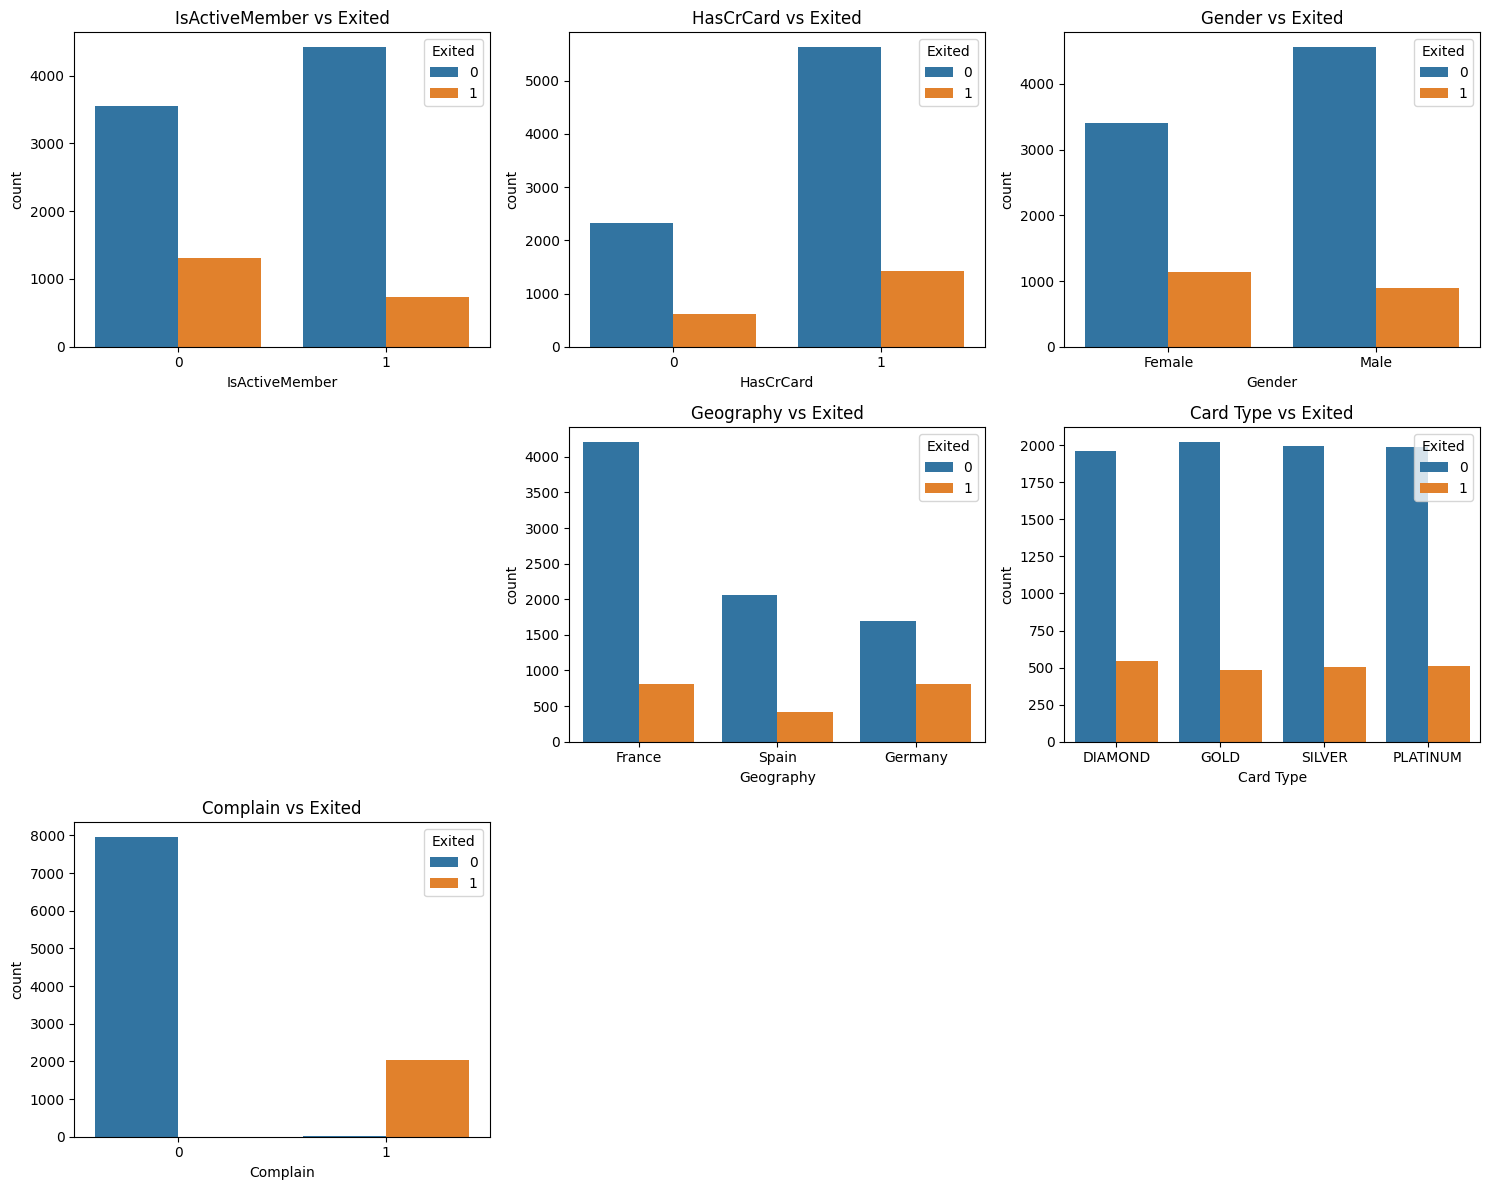

In [ ]:
# Configuração do tamanho da figura
plt.figure(figsize=(15, 12))

# Loop para criar os gráficos com a separação por Churn
for i, col in enumerate(var_qualitativas):
    # Pular a própria variável Exited para não ficar redundante
    if col == 'Exited':
        continue

    plt.subplot(3, 3, i + 1)
    # Aqui adicionamos o hue='Exited'
    sns.countplot(data=df_model, x=col, hue='Exited')
    plt.title(f'{col} vs Exited')
    plt.tight_layout()

plt.show()

In [ ]:
df_model.groupby('Exited')['Complain'].value_counts()


Exited  Complain
0       0           7952
        1             10
1       1           2034
        0              4
Name: count, dtype: int64

---

#### 📊 Análise das Variáveis Categóricas

---

#### ⭐ **1. Clientes inativos têm maior propensão ao churn**

* Clientes com **IsActiveMember = 0** apresentam uma taxa de churn significativamente maior.
  ➡️ **Inatividade é um forte indicador de risco.**

---

#### ⭐ **2. Possuir cartão de crédito aumenta a chance de saída**

* No grupo que possui **HasCrCard = 1**, observa-se maior proporção de churn comparado aos que não têm cartão.
  ➡️ Pode indicar baixa utilização do produto, oferta inadequada ou benefício pouco relevante.

---

#### ⭐ **3. Mulheres apresentam maior taxa proporcional de churn**

* Embora ambos os gêneros estejam presentes de forma equilibrada, **o churn é proporcionalmente maior entre mulheres**.
  ➡️ Pode sugerir que o banco possua comunicação, serviço ou produtos mais alinhados ao público masculino.

---

#### ⭐ **4. A Alemanha concentra a maior taxa de churn**

* Entre os três países, a **Alemanha apresenta o maior volume proporcional de clientes que saíram**, seguida da França, e a Espanha é a mais estável.
  ➡️ Indica possível diferença regional de experiência, concorrência ou adequação dos produtos.

---

#### ⭐ **5. Tipo de cartão não influencia o churn**

* As categorias **Diamond, Gold, Silver e Platinum** apresentam proporções muito semelhantes de saída.
  ➡️ Portanto, **CardType não é um preditor relevante**.

---

#### ⭐ **6. Reclamações são extremamente associadas ao churn, mas não devem ser usadas no modelo**

* Quase **todos os clientes que reclamaram acabaram saindo**, enquanto praticamente ninguém que ficou registrou reclamação.
* Isso transforma `Complain` em uma variável quase determinística do churn.

##### ❗ Porém, essa variável **não deve ser utilizada** no modelo preditivo:

* **Carrega informação do futuro** — a reclamação ocorre **antes** do churn, mas pode estar muito próxima temporalmente.
* O modelo aprenderia a prever churn apenas porque ocorreu uma reclamação, gerando **data leakage**.
* Isso faria com que o modelo **ignorasse totalmente os sinais que antecedem a insatisfação**.
* O resultado seria um modelo “perfeito”, porém **inútil para prevenção**, pois só detectaria churn após o problema já ter acontecido.

➡️ **Conclusão:** usar `Complain` comprometeria a robustez e a utilidade do modelo.

---

### 🎯 **Resumo Executivo das Variáveis Categóricas**

Os fatores mais relevantes para churn são:

✔ **Inatividade (IsActiveMember = 0)**
✔ **Possuir cartão de crédito**
✔ **Ser mulher**
✔ **Residência na Alemanha**

Fatores com baixo impacto:

✘ **Tipo de cartão**
✘ **Distribuição igualitária em algumas categorias**
✘ **Complain (embora extremamente forte, não pode ser usada)**

---

## Correlações

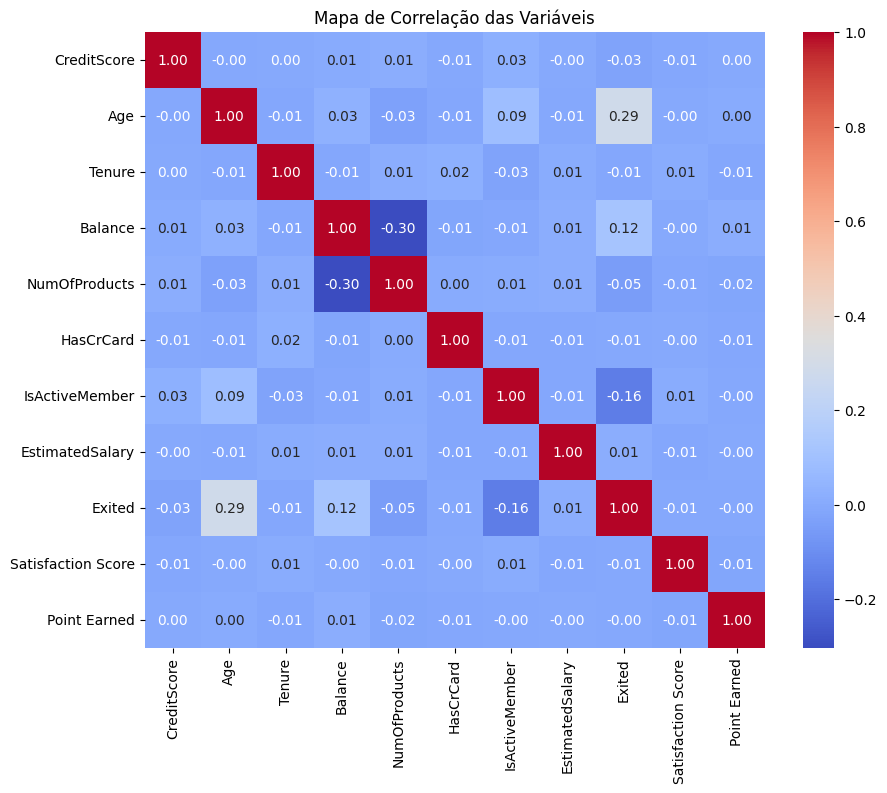

In [ ]:
# 1. Removendo a variável com Data Leakage
if 'Complain' in df_model.columns:
    df_model = df_model.drop('Complain', axis=1)

# 2. Gerando a Matriz de Correlação
plt.figure(figsize=(10, 8))
# Selecionando apenas colunas numéricas para a correlação
corr_matrix = df_model.corr(numeric_only=True)

# Plotando o Heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Correlação das Variáveis')
plt.show()

Aqui está um **Markdown no mesmo padrão dos anteriores**, bem organizado, claro e com apenas os **insights realmente significativos do mapa de correlação**, mantendo o estilo profissional e direto.

---

#### 🔗 **Análise do Mapa de Correlação**

---

#### ⭐ **1. Idade tem a correlação mais alta com churn**

* A variável **Age** apresenta correlação **positiva moderada (≈ 0.29)** com `Exited`.
* Clientes mais velhos têm maior probabilidade de sair do banco.
  ➡️ **Idade é um dos preditores mais fortes entre as variáveis disponíveis.**

---

#### ⭐ **2. Clientes ativos têm menor probabilidade de churn**

* A variável **IsActiveMember** apresenta correlação **negativa (-0.16)** com `Exited`.
* Quanto mais ativo o cliente, menor a chance de abandonar o banco.
  ➡️ Ser ativo é um **importante fator de retenção**.

---

#### ⭐ **3. Saldo (Balance) possui correlação levemente positiva com churn**

* `Balance` apresenta correlação **positiva fraca (≈ 0.12)** com `Exited`.
* Clientes com saldos mais altos têm tendência levemente maior a sair, possivelmente:

  * buscando melhores oportunidades financeiras,
  * migrando para bancos com taxas menores,
  * ou utilizando a conta apenas como passagem.
    ➡️ Embora fraca, essa correlação sugere **comportamentos financeiros mais estratégicos** entre clientes com saldo maior.

---

#### ⭐ **4. Número de produtos tem leve correlação negativa com saldo**

* Há uma correlação de **-0.30 entre Balance e NumOfProducts**, indicando que:

  * quem tem mais produtos tende a manter saldos menores,
  * enquanto quem tem poucos produtos tende a manter saldos maiores.
    ➡️ Pode indicar diferentes perfis de uso: clientes “multisserviço” versus clientes “investidores”.

---

#### ⭐ **5. Outras variáveis apresentam correlações muito baixas**

* `CreditScore`, `Tenure`, `HasCrCard`, `EstimatedSalary`, `SatisfactionScore` e `Point Earned` têm correlações próximas de **zero**.
  ➡️ Isoladamente, **não explicam bem o churn**.

---

### 🎯 **Resumo Executivo do Mapa de Correlação**

Os fatores mais correlacionados com churn:

✔ **Idade (correlação positiva moderada)**
✔ **Ser inativo (correlação negativa relevante)**
✔ **Saldo (correlação positiva fraca, mas significativa)**

Variáveis com baixa relevância individual:

✘ **CreditScore**
✘ **Tenure**
✘ **EstimatedSalary**
✘ **HasCrCard**
✘ **SatisfactionScore**
✘ **Point Earned**

---

Se quiser, posso agora **integrar todos os insights quantitativos + categóricos + correlação** em um único relatório final para o notebook.


## Analise Estatistica

In [ ]:
from scipy import stats
import pandas as pd

def realizar_testes_estatisticos(df, target='Exited'):
    print(f"--- Análise Estatística de Impacto no Churn ({target}) ---")

    # 1. Teste para Variáveis Categóricas (Qui-Quadrado)
    # H0 (Hipótese Nula): Não existe relação entre a variável e o Churn.
    # H1 (Hipótese Alternativa): Existe uma relação significativa.
    cat_vars = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

    print("\n[Variáveis Categóricas - Teste Qui-Quadrado]")
    for col in cat_vars:
        if col in df.columns:
            # Cria tabela de contingência (cruzamento)
            contingency_table = pd.crosstab(df[col], df[target])
            # Calcula o Qui-Quadrado
            chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

            sig = "SIGNIFICANTE ✅" if p_value < 0.05 else "Não Significante ❌"
            print(f"- {col:<15} | p-value: {p_value:.4e} | {sig}")

    # 2. Teste para Variáveis Numéricas (Mann-Whitney)
    # Usamos Mann-Whitney porque a distribuição de idade/saldo não é perfeitamente normal
    # H0: A distribuição da variável é a mesma para quem sai e quem fica.
    num_vars = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

    print("\n[Variáveis Numéricas - Teste Mann-Whitney U]")
    # Separamos os grupos
    group_churn = df[df[target] == 1]
    group_not_churn = df[df[target] == 0]

    for col in num_vars:
        if col in df.columns:
            stat, p_value = stats.mannwhitneyu(group_churn[col], group_not_churn[col])

            sig = "SIGNIFICANTE ✅" if p_value < 0.05 else "Não Significante ❌"
            print(f"- {col:<15} | p-value: {p_value:.4e} | {sig}")

# Chamando a função (use o seu dataframe ANTES do get_dummies)
realizar_testes_estatisticos(df_model)

--- Análise Estatística de Impacto no Churn (Exited) ---

[Variáveis Categóricas - Teste Qui-Quadrado]
- Geography       | p-value: 5.2457e-66 | SIGNIFICANTE ✅
- Gender          | p-value: 2.9254e-26 | SIGNIFICANTE ✅
- HasCrCard       | p-value: 5.0262e-01 | Não Significante ❌
- IsActiveMember  | p-value: 6.1532e-55 | SIGNIFICANTE ✅

[Variáveis Numéricas - Teste Mann-Whitney U]
- CreditScore     | p-value: 2.1751e-02 | SIGNIFICANTE ✅
- Age             | p-value: 2.7803e-230 | SIGNIFICANTE ✅
- Tenure          | p-value: 1.7296e-01 | Não Significante ❌
- Balance         | p-value: 1.1688e-28 | SIGNIFICANTE ✅
- NumOfProducts   | p-value: 7.2794e-36 | SIGNIFICANTE ✅
- EstimatedSalary | p-value: 2.1236e-01 | Não Significante ❌


# Pré-processamento de Dados

In [ ]:
from feature_engine.outliers import Winsorizer
import numpy as np

# --- ETAPA 1: Tratamento de Outliers (Winsorization) ---
# Definimos quais colunas queremos limpar os extremos
cols_para_limpar = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Point Earned']

# Instanciamos o Winsorizer usando IQR (Interquartile Range)
# fold=1.5 é o padrão estatístico para definir o que é outlier
winsor = Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=cols_para_limpar)

# Aplicamos no dataframe
df_model = winsor.fit_transform(df_model)


# --- ETAPA 2: Transformação Logarítmica (O "Pulo do Gato") ---
# Como vimos na análise do outro notebook, isso ajuda a "normalizar" distribuições tortas
# Usamos log1p (log de x+1) para evitar erro matemático se o valor for 0
df_model['Age'] = np.log1p(df_model['Age'])
df_model['Balance'] = np.log1p(df_model['Balance'])


In [ ]:
# A França será nosso caso base, como temos a maior concentração de clientes.
df_model = pd.get_dummies(df_model, prefix=None, prefix_sep='_', columns=["Geography", "Gender","Card Type"], drop_first=True, dtype=int)


Feature Scaling

In [ ]:
cols_to_scale=["CreditScore","Balance","EstimatedSalary","Satisfaction Score","Point Earned","NumOfProducts","Tenure","Age"]

scaler = StandardScaler()
df_model[cols_to_scale] = scaler.fit_transform(df_model[cols_to_scale])
df_model.head()

CreditScore       Age    Tenure   Balance  NumOfProducts  HasCrCard  \
0    -0.326878  0.454290 -1.041760 -1.327358      -0.911583          1   
1    -0.440804  0.357397 -1.387538  0.694771      -0.911583          0   
2    -1.538636  0.454290  1.032908  0.809738       2.527057          1   
3     0.501675  0.156491 -1.387538 -1.327358       0.807737          0   
4     2.065569  0.548956 -1.041760  0.766810      -0.911583          1   

   IsActiveMember  EstimatedSalary  Exited  Satisfaction Score  Point Earned  \
0               1         0.021886       1           -0.721130     -0.630839   
1               1         0.216534       0           -0.009816     -0.666251   
2               0         0.240687       1           -0.009816     -1.015942   
3               0        -0.108918       0            1.412812     -1.135457   
4               1        -0.365276       0            1.412812     -0.803472   

   Geography_Germany  Geography_Spain  Gender_Male  Card Type_GOLD  \
0                  0                0            0               0   
1                  0                1            0               0   
2                  0                0            0               0   
3                  0                0            0               1   
4                  0                1            0               1   

   Card Type_PLATINUM  Card Type_SILVER  
0                   0                 0  
1                   0                 0  
2                   0                 0  
3                   0                 0  
4                   0                 0

## Separação de Dataset

In [ ]:
from sklearn.model_selection import train_test_split

X = df_model.drop('Exited', axis=1)
y = df_model['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y,
 test_size=0.3,
 random_state=0,
 stratify=y)
# Uso do Stratify garante que o seu treino e o seu teste mantenham exatamente essa mesma proporção. Sem isso, você poderia ter o azar de o teste ficar só com clientes que "Ficaram", o que mascararia a performance real do modelo

## Modelagem

#### Configuracao de MOdelos

In [ ]:
models_default = {
    "LogisticRegression": LogisticRegression(),
    "RandomForest": RandomForestClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(),
    "NeuralNetwork": MLPClassifier(),
    "XGBoost": XGBClassifier(),
    "AdaBoost": AdaBoostClassifier(),
}

#### Configuracao de paramentros

In [ ]:
param_grids = {
    "LogisticRegression": {
        'C': [0.1, 1.0, 10.0],
        'solver': ['lbfgs', 'liblinear'],
        'max_iter': [500, 1000]
    },
    "RandomForest": {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    "SVM": {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto']
    },
    "KNN": {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    "DecisionTree": {
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    "NeuralNetwork": {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001]
    },
     "AdaBoost": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1.0],
        'algorithm': ['SAMME', 'SAMME.R']
    },
    "XGBoost": {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0]
    }

}


resultados = []

In [ ]:
def garantir_duas_colunas(scores):
    scores = np.array(scores)

    # Caso já tenha 2 colunas
    if scores.ndim == 2 and scores.shape[1] == 2:
        return scores

    # Caso seja 1D — binário
    if scores.ndim == 1:
        # Normalizar para [0,1]
        min_v = scores.min()
        max_v = scores.max()
        if max_v - min_v == 0:
            score_pos = np.zeros_like(scores)
        else:
            score_pos = (scores - min_v) / (max_v - min_v)

        score_neg = 1 - score_pos
        return np.vstack([score_neg, score_pos]).T

    # Caso seja 2D porém só com 1 coluna
    if scores.ndim == 2 and scores.shape[1] == 1:
        col = scores[:, 0]
        min_v = col.min()
        max_v = col.max()
        if max_v - min_v == 0:
            score_pos = np.zeros_like(col)
        else:
            score_pos = (col - min_v) / (max_v - min_v)

        score_neg = 1 - score_pos
        return np.vstack([score_neg, score_pos]).T


#### Classe ModelTrainer

In [ ]:
import os
import time
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, f1_score
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

class ModelTrainer:
    def __init__(self, X_train, y_train, X_test, y_test, models, param_grids=None, best_params=None):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.models = models
        self.param_grids = param_grids if param_grids else {}
        self.best_params = best_params if best_params else {}
        self.results = []

        # Inicializa transformadores como None
        self.fitted_scaler = None
        self.fitted_pca = None

        self.best_model_info = {
            "pipeline": None,
            "name": "",
            "score": 0.0,
            "metric": ""
        }

    def _get_metric_score(self, y_true, y_pred, metric_name):
        if metric_name == 'accuracy':
            return accuracy_score(y_true, y_pred)
        elif metric_name == 'recall':
            return recall_score(y_true, y_pred, average='macro')
        elif metric_name == 'recall_1':
            return recall_score(y_true, y_pred, pos_label=1, average='binary')
        elif metric_name == 'precision':
            return precision_score(y_true, y_pred, average='macro')
        elif metric_name == 'f1':
            return f1_score(y_true, y_pred, average='macro')
        else:
            raise ValueError(f"Métrica '{metric_name}' não suportada.")

    def _preprocess_data(self, balanceamento, usar_pca, usar_scaler):
        # Reinicia transformadores
        self.fitted_scaler = None
        self.fitted_pca = None

        X_train_proc, y_train_proc = self.X_train, self.y_train
        X_test_proc = self.X_test

        # 1. SCALER
        if usar_scaler:
            self.fitted_scaler = StandardScaler()
            X_train_proc = self.fitted_scaler.fit_transform(X_train_proc)
            X_test_proc = self.fitted_scaler.transform(X_test_proc)

        # 2. BALANCEAMENTO (Só treino)
        if balanceamento == "SMOTE":
            sm = SMOTE(random_state=42)
            X_train_proc, y_train_proc = sm.fit_resample(X_train_proc, y_train_proc)
        elif balanceamento == "TomekLinks":
            tml = TomekLinks()
            X_train_proc, y_train_proc = tml.fit_resample(X_train_proc, y_train_proc)

        # 3. PCA
        if usar_pca:
            self.fitted_pca = PCA(n_components=0.95)
            X_train_proc = self.fitted_pca.fit_transform(X_train_proc)
            X_test_proc = self.fitted_pca.transform(X_test_proc)

        return X_train_proc, y_train_proc, X_test_proc

    def train(self, metric_optimize='recall_1', balanceamento=None, usar_pca=False, usar_scaler=True, tipo_parametros='default', salvar_parametros=True, path_salvar = os.path.join(os.getcwd(), "resultados_treino")):

        if not os.path.exists(path_salvar):
            os.makedirs(path_salvar)

        self.results = []
        self.best_model_info = {"pipeline": None, "name": "", "score": 0.0, "metric": metric_optimize}

        X_train_ready, y_train_ready, X_test_ready = self._preprocess_data(balanceamento, usar_pca, usar_scaler)

        print(f"Iniciando treinamento otimizando por: {metric_optimize.upper()}\n")

        for name, model in self.models.items():
            print(f"\n{'='*20} {name} {'='*20}")

            if tipo_parametros == "default" or name == "NaiveBayes":
                estimator = model
            else:
                params = self.param_grids.get(name) if tipo_parametros == "grid" else self.best_params.get(name)
                scoring_map = {'accuracy': 'accuracy', 'recall': 'recall_macro', 'recall_1': 'recall', 'precision': 'precision_macro', 'f1': 'f1_macro'}

                if params:
                    estimator = GridSearchCV(estimator=model, param_grid=params, cv=5, n_jobs=-1, scoring=scoring_map.get(metric_optimize, 'accuracy'), verbose=1)
                else:
                    estimator = model

            inicio = time.time()
            estimator.fit(X_train_ready, y_train_ready)
            fim = time.time()
            tempo_treino = fim - inicio

            y_pred = estimator.predict(X_test_ready)
            score_atual = self._get_metric_score(self.y_test, y_pred, metric_optimize)

            # --- Visualização e Métricas ---
            acc = accuracy_score(self.y_test, y_pred)
            rec_class_1 = recall_score(self.y_test, y_pred, pos_label=1, average='binary')

            classes = unique_labels(self.y_test, y_pred)
            target_names = [f"Classe {c}" for c in classes]

            # Report de Texto
            print(f"Relatório para {name}:")
            print(classification_report(self.y_test, y_pred, target_names=target_names))

            # Matriz de Confusão
            cm = confusion_matrix(self.y_test, y_pred, labels=classes)
            plt.figure(figsize=(6, 4))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
            plt.xlabel('Predição')
            plt.ylabel('Real')
            plt.title(f'Matriz de Confusão - {name}')
            plt.show()
            # -------------------------------

            # Salva o melhor modelo
            if score_atual > self.best_model_info["score"]:
                print(f"✨ Novo Recorde! {name} com {metric_optimize}: {score_atual:.4f}")
                self.best_model_info["score"] = score_atual
                self.best_model_info["name"] = name

                modelo_final = estimator.best_estimator_ if hasattr(estimator, 'best_estimator_') else estimator

                steps = []
                if self.fitted_scaler: steps.append(('scaler', self.fitted_scaler))
                if self.fitted_pca: steps.append(('pca', self.fitted_pca))
                steps.append(('model', modelo_final))

                self.best_model_info["pipeline"] = Pipeline(steps)

            best_params_found = estimator.best_params_ if hasattr(estimator, 'best_params_') else "N/A"

            self.results.append({
                "Modelo": name,
                "Config": f"Bal:{balanceamento}|PCA:{usar_pca}|Scl:{usar_scaler}",
                f"Score ({metric_optimize})": score_atual,
                "Recall (1)": rec_class_1,
                "Acurácia": acc,
                "Tempo": tempo_treino,
                "Params": best_params_found
            })

            if salvar_parametros and hasattr(estimator, 'best_params_'):
                 try: joblib.dump(estimator.best_params_, f'{path_salvar}/parametros_{name}.pkl')
                 except: pass

            print("=" * 52)

        self._final_report(path_salvar)
        return self.best_model_info["pipeline"]

    def _final_report(self, path_salvar):
        df = pd.DataFrame(self.results).sort_values(by=f"Score ({self.best_model_info['metric']})", ascending=False)
        print("\n🏆 Resultados:")
        try:
            from IPython.display import display
            display(df)
        except:
            print(df)

        if self.best_model_info["pipeline"]:
            nome_modelo = self.best_model_info["name"]
            nome_arquivo = f'{path_salvar}/{nome_modelo}_PIPELINE_COMPLETO.pkl'
            joblib.dump(self.best_model_info["pipeline"], nome_arquivo)
            print(f"\n💾 Pipeline COMPLETA salva em: {nome_arquivo}")

Pipleine

In [ ]:
models_best_parameters={}

# 1. Instanciar a classe com seus dados
trainer = ModelTrainer(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    models=models_default,       # Seu dicionário de modelos
    param_grids=param_grids,     # Seus parâmetros para GridSearch
    best_params=models_best_parameters # (Opcional) Se tiver melhores params salvos
)

Cenarios

🚀 Iniciando bateria de testes com 15 cenários...


>>> 🧪 Testando Cenário: Default
Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
Relatório para LogisticRegression:
              precision    recall  f1-score   support

    Classe 0       0.83      0.97      0.90      2389
    Classe 1       0.68      0.25      0.36       611

    accuracy                           0.82      3000
   macro avg       0.76      0.61      0.63      3000
weighted avg       0.80      0.82      0.79      3000



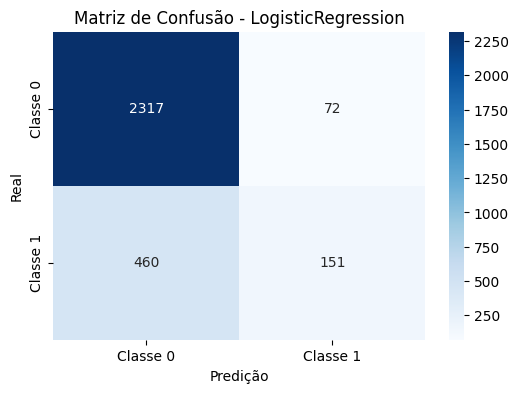

✨ Novo Recorde! LogisticRegression com recall_1: 0.2471

==================== RandomForest ====================
Relatório para RandomForest:
              precision    recall  f1-score   support

    Classe 0       0.87      0.97      0.91      2389
    Classe 1       0.76      0.42      0.54       611

    accuracy                           0.86      3000
   macro avg       0.81      0.69      0.73      3000
weighted avg       0.85      0.86      0.84      3000



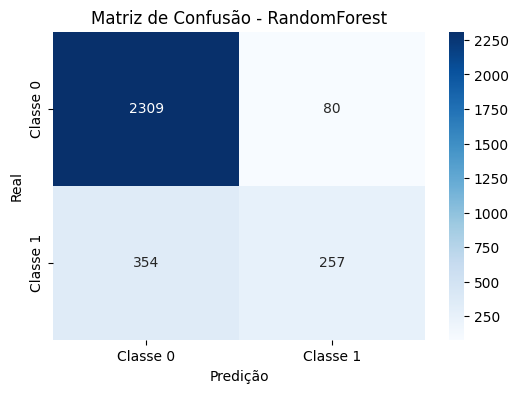

✨ Novo Recorde! RandomForest com recall_1: 0.4206

==================== SVM ====================
Relatório para SVM:
              precision    recall  f1-score   support

    Classe 0       0.85      0.98      0.91      2389
    Classe 1       0.78      0.35      0.48       611

    accuracy                           0.85      3000
   macro avg       0.82      0.66      0.70      3000
weighted avg       0.84      0.85      0.82      3000



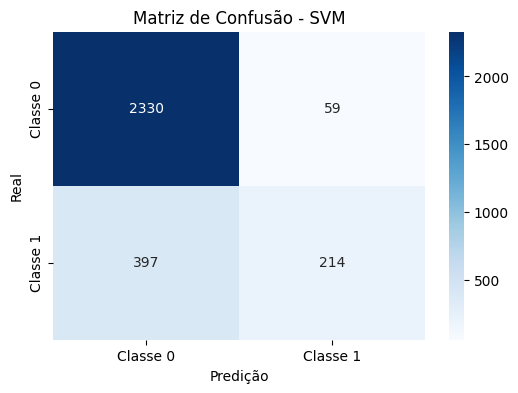


==================== KNN ====================
Relatório para KNN:
              precision    recall  f1-score   support

    Classe 0       0.83      0.95      0.89      2389
    Classe 1       0.58      0.25      0.35       611

    accuracy                           0.81      3000
   macro avg       0.71      0.60      0.62      3000
weighted avg       0.78      0.81      0.78      3000



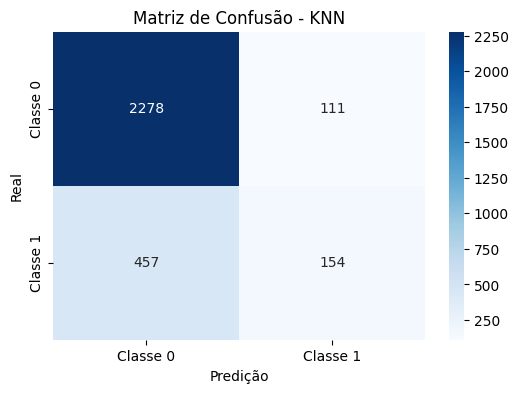


==================== DecisionTree ====================
Relatório para DecisionTree:
              precision    recall  f1-score   support

    Classe 0       0.87      0.86      0.86      2389
    Classe 1       0.47      0.48      0.47       611

    accuracy                           0.78      3000
   macro avg       0.67      0.67      0.67      3000
weighted avg       0.78      0.78      0.78      3000



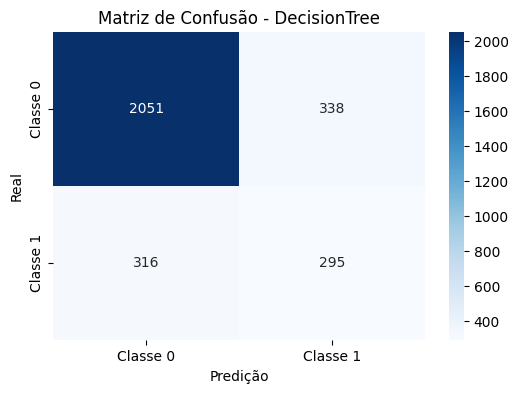

✨ Novo Recorde! DecisionTree com recall_1: 0.4828

==================== NeuralNetwork ====================
Relatório para NeuralNetwork:
              precision    recall  f1-score   support

    Classe 0       0.87      0.95      0.91      2389
    Classe 1       0.69      0.43      0.53       611

    accuracy                           0.84      3000
   macro avg       0.78      0.69      0.72      3000
weighted avg       0.83      0.84      0.83      3000



/home/dom-paje/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


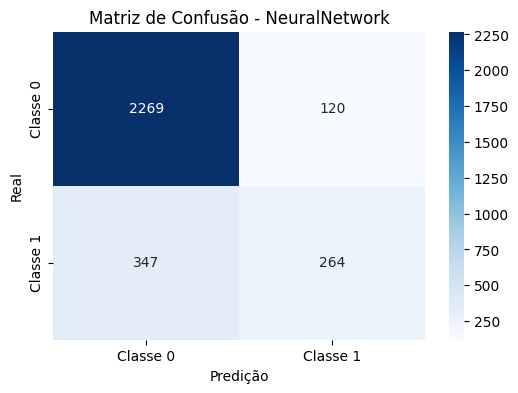


==================== XGBoost ====================
Relatório para XGBoost:
              precision    recall  f1-score   support

    Classe 0       0.87      0.94      0.91      2389
    Classe 1       0.67      0.46      0.54       611

    accuracy                           0.84      3000
   macro avg       0.77      0.70      0.72      3000
weighted avg       0.83      0.84      0.83      3000



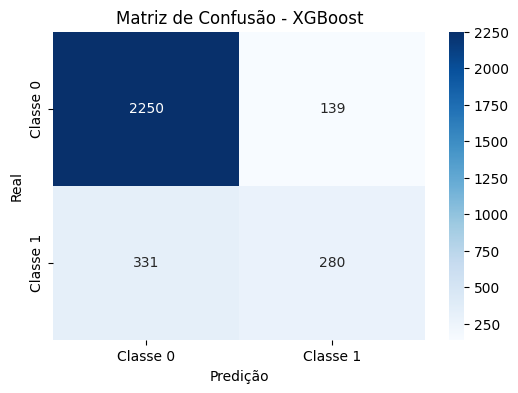


==================== AdaBoost ====================
Relatório para AdaBoost:
              precision    recall  f1-score   support

    Classe 0       0.87      0.96      0.91      2389
    Classe 1       0.72      0.43      0.53       611

    accuracy                           0.85      3000
   macro avg       0.79      0.69      0.72      3000
weighted avg       0.84      0.85      0.83      3000



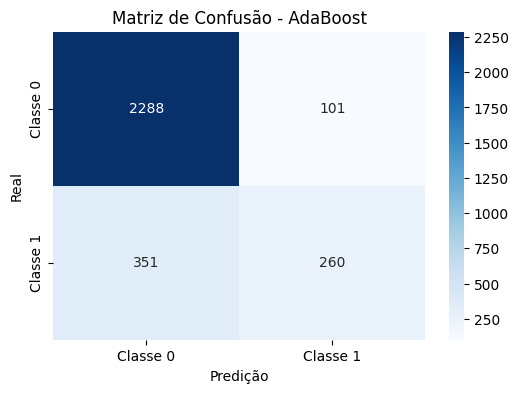


🏆 Resultados:


Modelo                       Config  Score (recall_1)  \
4        DecisionTree  Bal:None|PCA:False|Scl:True          0.482815   
6             XGBoost  Bal:None|PCA:False|Scl:True          0.458265   
5       NeuralNetwork  Bal:None|PCA:False|Scl:True          0.432079   
7            AdaBoost  Bal:None|PCA:False|Scl:True          0.425532   
1        RandomForest  Bal:None|PCA:False|Scl:True          0.420622   
2                 SVM  Bal:None|PCA:False|Scl:True          0.350245   
3                 KNN  Bal:None|PCA:False|Scl:True          0.252046   
0  LogisticRegression  Bal:None|PCA:False|Scl:True          0.247136   

   Recall (1)  Acurácia      Tempo Params  
4    0.482815  0.782000   0.050945    N/A  
6    0.458265  0.843333  18.578843    N/A  
5    0.432079  0.844333   8.437628    N/A  
7    0.425532  0.849333   0.300532    N/A  
1    0.420622  0.855333   1.002494    N/A  
2    0.350245  0.848000   0.812274    N/A  
3    0.252046  0.810667   0.001220    N/A  
0    0.247136  0.822667   0.011079    N/A


💾 Pipeline COMPLETA salva em: /home/dom-paje/llm-stack-containers/data/tf./resultados_treino/DecisionTree_PIPELINE_COMPLETO.pkl

>>> 🧪 Testando Cenário: Default + SMOTE
Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
Relatório para LogisticRegression:
              precision    recall  f1-score   support

    Classe 0       0.90      0.71      0.80      2389
    Classe 1       0.38      0.69      0.49       611

    accuracy                           0.71      3000
   macro avg       0.64      0.70      0.64      3000
weighted avg       0.79      0.71      0.73      3000



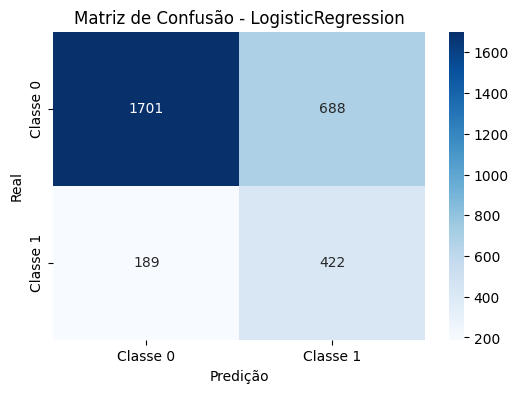

✨ Novo Recorde! LogisticRegression com recall_1: 0.6907

==================== RandomForest ====================
Relatório para RandomForest:
              precision    recall  f1-score   support

    Classe 0       0.88      0.92      0.90      2389
    Classe 1       0.63      0.52      0.57       611

    accuracy                           0.84      3000
   macro avg       0.76      0.72      0.74      3000
weighted avg       0.83      0.84      0.83      3000



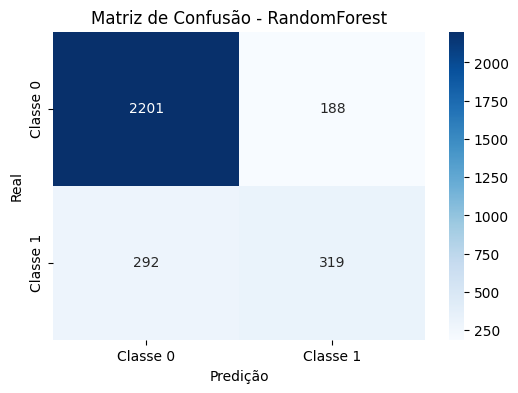


==================== SVM ====================
Relatório para SVM:
              precision    recall  f1-score   support

    Classe 0       0.90      0.84      0.87      2389
    Classe 1       0.49      0.62      0.55       611

    accuracy                           0.79      3000
   macro avg       0.69      0.73      0.71      3000
weighted avg       0.81      0.79      0.80      3000



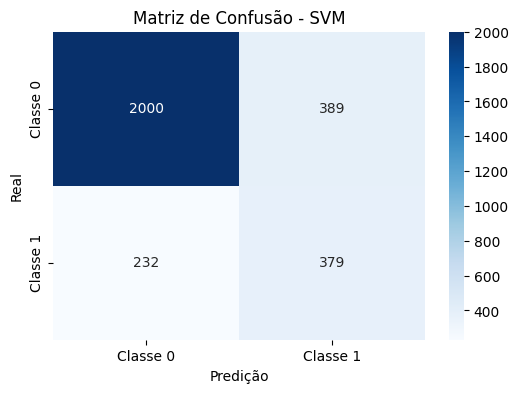


==================== KNN ====================
Relatório para KNN:
              precision    recall  f1-score   support

    Classe 0       0.88      0.73      0.80      2389
    Classe 1       0.36      0.60      0.45       611

    accuracy                           0.70      3000
   macro avg       0.62      0.66      0.62      3000
weighted avg       0.77      0.70      0.72      3000



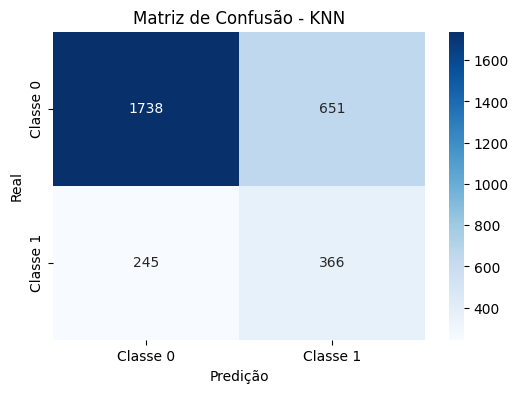


==================== DecisionTree ====================
Relatório para DecisionTree:
              precision    recall  f1-score   support

    Classe 0       0.87      0.83      0.85      2389
    Classe 1       0.43      0.50      0.46       611

    accuracy                           0.76      3000
   macro avg       0.65      0.67      0.66      3000
weighted avg       0.78      0.76      0.77      3000



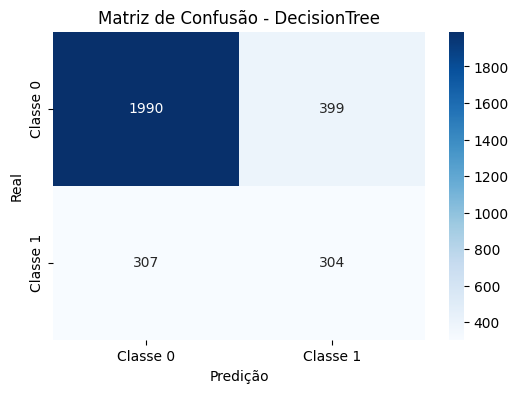


==================== NeuralNetwork ====================
Relatório para NeuralNetwork:
              precision    recall  f1-score   support

    Classe 0       0.88      0.87      0.87      2389
    Classe 1       0.51      0.53      0.52       611

    accuracy                           0.80      3000
   macro avg       0.69      0.70      0.69      3000
weighted avg       0.80      0.80      0.80      3000



/home/dom-paje/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


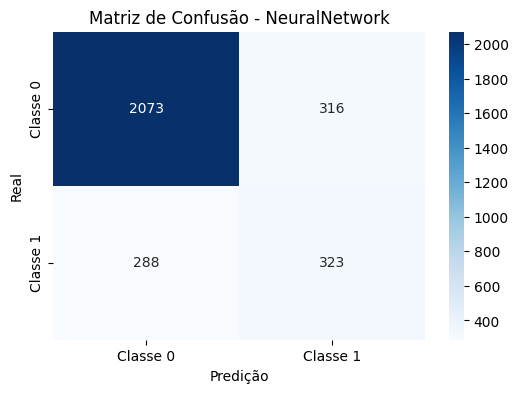


==================== XGBoost ====================
Relatório para XGBoost:
              precision    recall  f1-score   support

    Classe 0       0.88      0.93      0.90      2389
    Classe 1       0.65      0.49      0.56       611

    accuracy                           0.84      3000
   macro avg       0.76      0.71      0.73      3000
weighted avg       0.83      0.84      0.83      3000



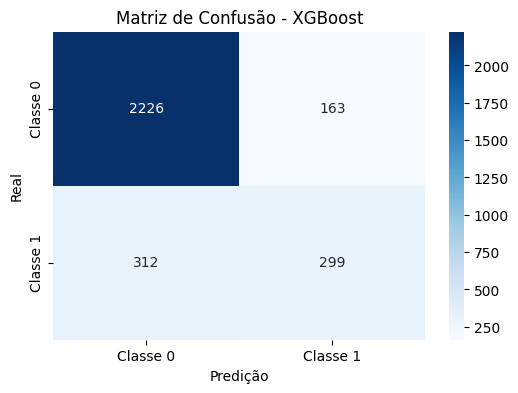


==================== AdaBoost ====================
Relatório para AdaBoost:
              precision    recall  f1-score   support

    Classe 0       0.89      0.86      0.88      2389
    Classe 1       0.53      0.60      0.56       611

    accuracy                           0.81      3000
   macro avg       0.71      0.73      0.72      3000
weighted avg       0.82      0.81      0.81      3000



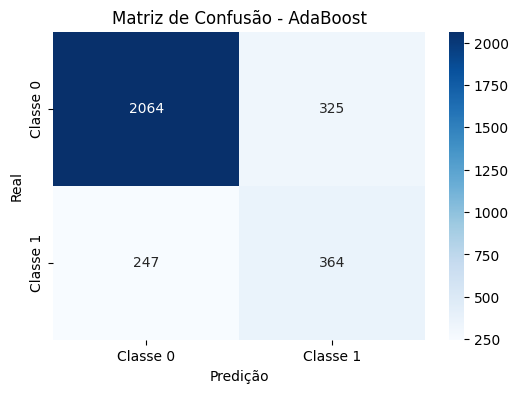


🏆 Resultados:


Modelo                        Config  Score (recall_1)  \
0  LogisticRegression  Bal:SMOTE|PCA:False|Scl:True          0.690671   
2                 SVM  Bal:SMOTE|PCA:False|Scl:True          0.620295   
3                 KNN  Bal:SMOTE|PCA:False|Scl:True          0.599018   
7            AdaBoost  Bal:SMOTE|PCA:False|Scl:True          0.595745   
5       NeuralNetwork  Bal:SMOTE|PCA:False|Scl:True          0.528642   
1        RandomForest  Bal:SMOTE|PCA:False|Scl:True          0.522095   
4        DecisionTree  Bal:SMOTE|PCA:False|Scl:True          0.497545   
6             XGBoost  Bal:SMOTE|PCA:False|Scl:True          0.489362   

   Recall (1)  Acurácia      Tempo Params  
0    0.690671  0.707667   0.012475    N/A  
2    0.620295  0.793000   2.608843    N/A  
3    0.599018  0.701333   0.001233    N/A  
7    0.595745  0.809333   0.600899    N/A  
5    0.528642  0.798667  12.903954    N/A  
1    0.522095  0.840000   1.960555    N/A  
4    0.497545  0.764667   0.104771    N/A  
6    0.489362  0.841667   5.088537    N/A


💾 Pipeline COMPLETA salva em: /home/dom-paje/llm-stack-containers/data/tf./resultados_treino/LogisticRegression_PIPELINE_COMPLETO.pkl

>>> 🧪 Testando Cenário: Default + Tomek
Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
Relatório para LogisticRegression:
              precision    recall  f1-score   support

    Classe 0       0.84      0.95      0.89      2389
    Classe 1       0.59      0.28      0.38       611

    accuracy                           0.81      3000
   macro avg       0.72      0.62      0.64      3000
weighted avg       0.79      0.81      0.79      3000



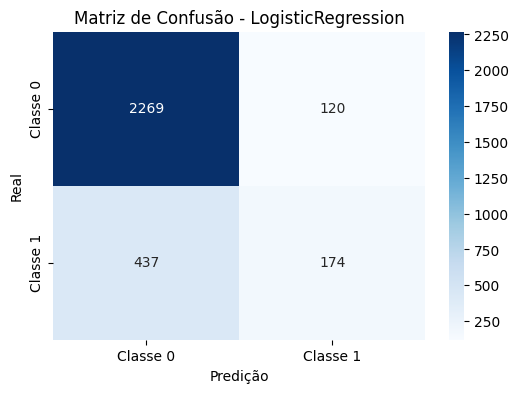

✨ Novo Recorde! LogisticRegression com recall_1: 0.2848

==================== RandomForest ====================
Relatório para RandomForest:
              precision    recall  f1-score   support

    Classe 0       0.87      0.96      0.91      2389
    Classe 1       0.72      0.45      0.56       611

    accuracy                           0.85      3000
   macro avg       0.80      0.70      0.73      3000
weighted avg       0.84      0.85      0.84      3000



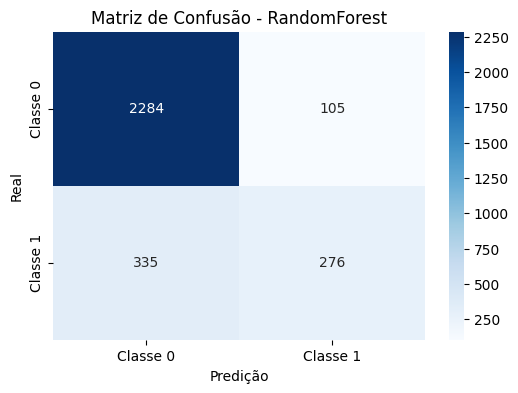

✨ Novo Recorde! RandomForest com recall_1: 0.4517

==================== SVM ====================
Relatório para SVM:
              precision    recall  f1-score   support

    Classe 0       0.87      0.96      0.91      2389
    Classe 1       0.74      0.42      0.53       611

    accuracy                           0.85      3000
   macro avg       0.80      0.69      0.72      3000
weighted avg       0.84      0.85      0.83      3000



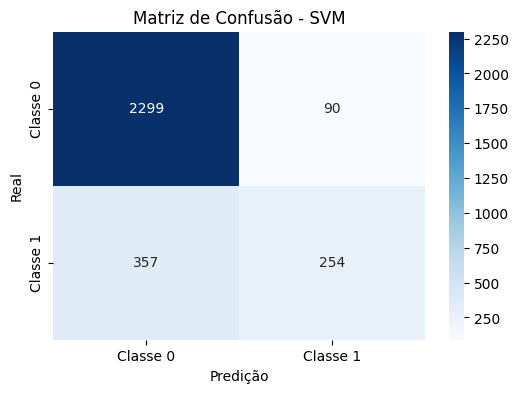


==================== KNN ====================
Relatório para KNN:
              precision    recall  f1-score   support

    Classe 0       0.84      0.94      0.89      2389
    Classe 1       0.56      0.31      0.40       611

    accuracy                           0.81      3000
   macro avg       0.70      0.62      0.64      3000
weighted avg       0.78      0.81      0.79      3000



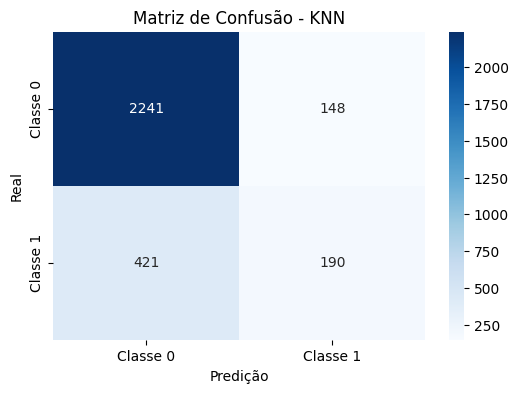


==================== DecisionTree ====================
Relatório para DecisionTree:
              precision    recall  f1-score   support

    Classe 0       0.88      0.85      0.86      2389
    Classe 1       0.48      0.54      0.51       611

    accuracy                           0.79      3000
   macro avg       0.68      0.69      0.69      3000
weighted avg       0.80      0.79      0.79      3000



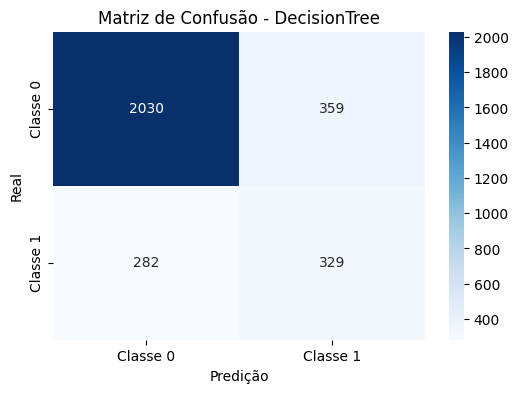

✨ Novo Recorde! DecisionTree com recall_1: 0.5385

==================== NeuralNetwork ====================
Relatório para NeuralNetwork:
              precision    recall  f1-score   support

    Classe 0       0.88      0.93      0.90      2389
    Classe 1       0.64      0.50      0.56       611

    accuracy                           0.84      3000
   macro avg       0.76      0.72      0.73      3000
weighted avg       0.83      0.84      0.83      3000



/home/dom-paje/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


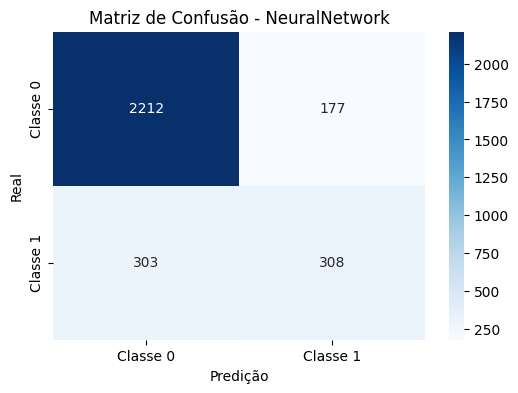


==================== XGBoost ====================
Relatório para XGBoost:
              precision    recall  f1-score   support

    Classe 0       0.87      0.92      0.90      2389
    Classe 1       0.62      0.48      0.54       611

    accuracy                           0.83      3000
   macro avg       0.75      0.70      0.72      3000
weighted avg       0.82      0.83      0.83      3000



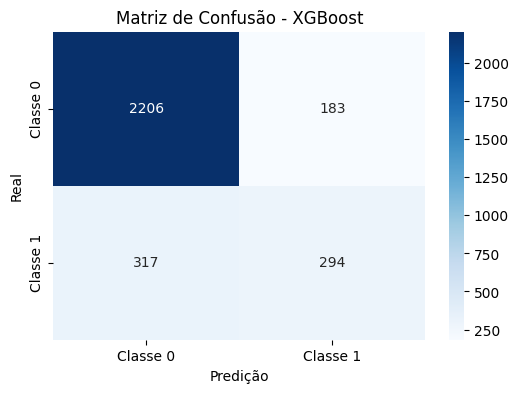


==================== AdaBoost ====================
Relatório para AdaBoost:
              precision    recall  f1-score   support

    Classe 0       0.87      0.94      0.91      2389
    Classe 1       0.67      0.46      0.54       611

    accuracy                           0.84      3000
   macro avg       0.77      0.70      0.72      3000
weighted avg       0.83      0.84      0.83      3000



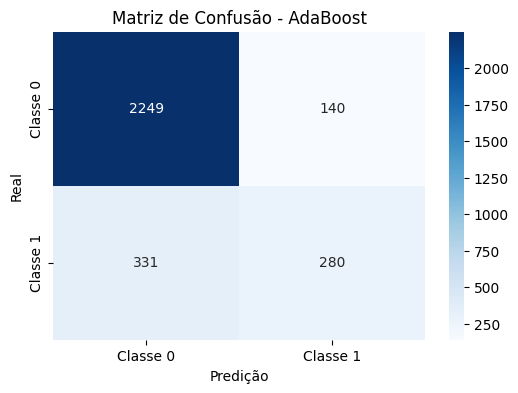


🏆 Resultados:


Modelo                             Config  Score (recall_1)  \
4        DecisionTree  Bal:TomekLinks|PCA:False|Scl:True          0.538462   
5       NeuralNetwork  Bal:TomekLinks|PCA:False|Scl:True          0.504092   
6             XGBoost  Bal:TomekLinks|PCA:False|Scl:True          0.481178   
7            AdaBoost  Bal:TomekLinks|PCA:False|Scl:True          0.458265   
1        RandomForest  Bal:TomekLinks|PCA:False|Scl:True          0.451718   
2                 SVM  Bal:TomekLinks|PCA:False|Scl:True          0.415712   
3                 KNN  Bal:TomekLinks|PCA:False|Scl:True          0.310966   
0  LogisticRegression  Bal:TomekLinks|PCA:False|Scl:True          0.284779   

   Recall (1)  Acurácia      Tempo Params  
4    0.538462  0.786333   0.048811    N/A  
5    0.504092  0.840000   7.439167    N/A  
6    0.481178  0.833333  15.302922    N/A  
7    0.458265  0.843000   0.295215    N/A  
1    0.451718  0.853333   0.924452    N/A  
2    0.415712  0.851000   0.745363    N/A  
3    0.310966  0.810333   0.001013    N/A  
0    0.284779  0.814333   0.008640    N/A


💾 Pipeline COMPLETA salva em: /home/dom-paje/llm-stack-containers/data/tf./resultados_treino/DecisionTree_PIPELINE_COMPLETO.pkl

>>> 🧪 Testando Cenário: Default + PCA + SMOTE
Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
Relatório para LogisticRegression:
              precision    recall  f1-score   support

    Classe 0       0.90      0.71      0.79      2389
    Classe 1       0.38      0.69      0.49       611

    accuracy                           0.71      3000
   macro avg       0.64      0.70      0.64      3000
weighted avg       0.79      0.71      0.73      3000



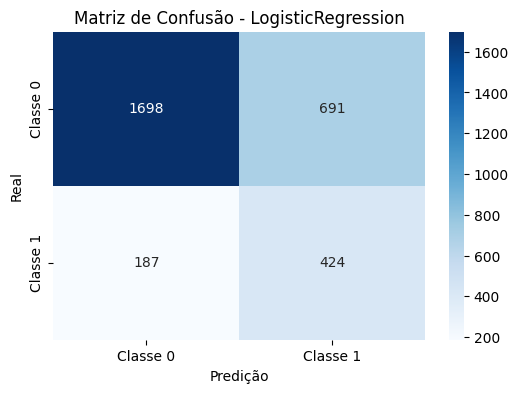

✨ Novo Recorde! LogisticRegression com recall_1: 0.6939

==================== RandomForest ====================
Relatório para RandomForest:
              precision    recall  f1-score   support

    Classe 0       0.89      0.89      0.89      2389
    Classe 1       0.55      0.55      0.55       611

    accuracy                           0.82      3000
   macro avg       0.72      0.72      0.72      3000
weighted avg       0.82      0.82      0.82      3000



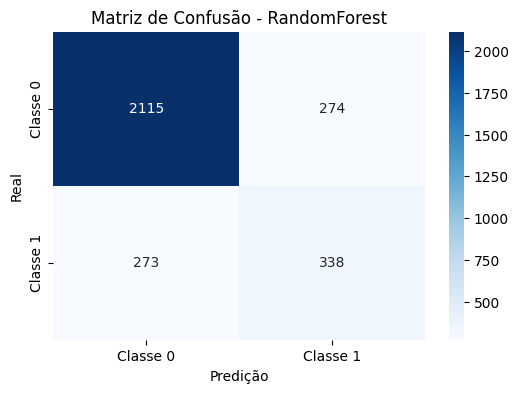


==================== SVM ====================
Relatório para SVM:
              precision    recall  f1-score   support

    Classe 0       0.90      0.84      0.86      2389
    Classe 1       0.49      0.62      0.55       611

    accuracy                           0.79      3000
   macro avg       0.69      0.73      0.71      3000
weighted avg       0.81      0.79      0.80      3000



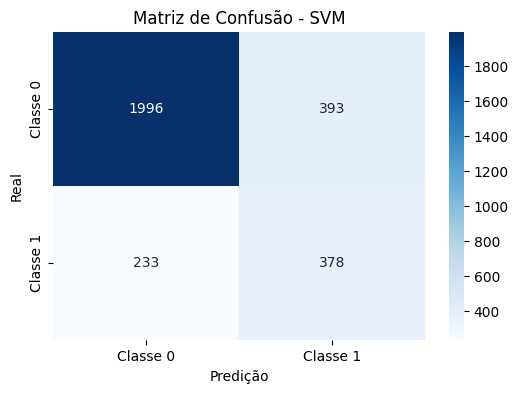


==================== KNN ====================
Relatório para KNN:
              precision    recall  f1-score   support

    Classe 0       0.87      0.73      0.80      2389
    Classe 1       0.36      0.59      0.45       611

    accuracy                           0.70      3000
   macro avg       0.62      0.66      0.62      3000
weighted avg       0.77      0.70      0.73      3000



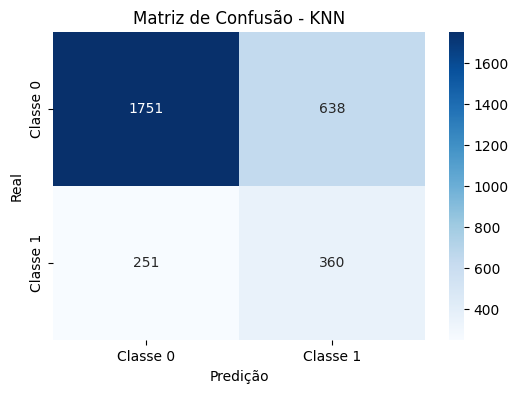


==================== DecisionTree ====================
Relatório para DecisionTree:
              precision    recall  f1-score   support

    Classe 0       0.86      0.77      0.81      2389
    Classe 1       0.37      0.52      0.43       611

    accuracy                           0.72      3000
   macro avg       0.62      0.65      0.62      3000
weighted avg       0.76      0.72      0.74      3000



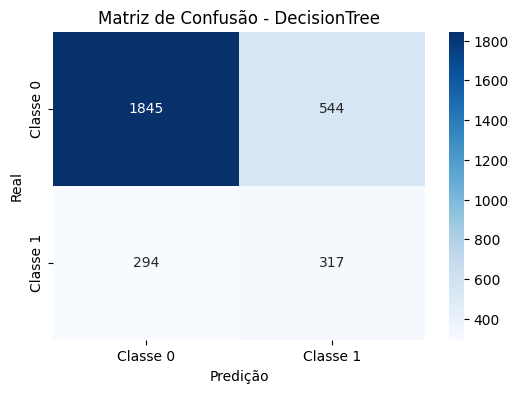


==================== NeuralNetwork ====================
Relatório para NeuralNetwork:
              precision    recall  f1-score   support

    Classe 0       0.88      0.84      0.86      2389
    Classe 1       0.47      0.57      0.52       611

    accuracy                           0.78      3000
   macro avg       0.68      0.70      0.69      3000
weighted avg       0.80      0.78      0.79      3000



/home/dom-paje/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


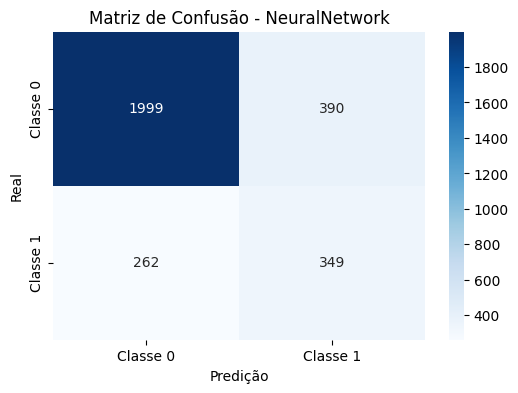


==================== XGBoost ====================
Relatório para XGBoost:
              precision    recall  f1-score   support

    Classe 0       0.89      0.86      0.87      2389
    Classe 1       0.50      0.57      0.53       611

    accuracy                           0.80      3000
   macro avg       0.69      0.71      0.70      3000
weighted avg       0.81      0.80      0.80      3000



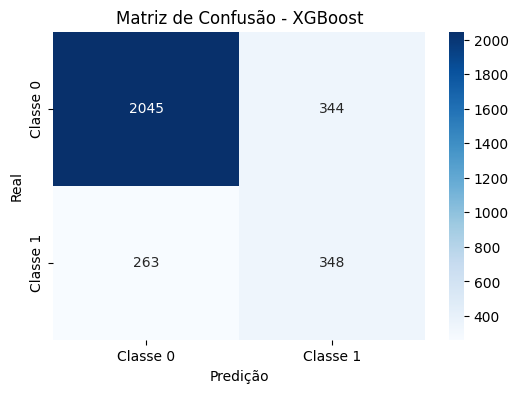


==================== AdaBoost ====================
Relatório para AdaBoost:
              precision    recall  f1-score   support

    Classe 0       0.90      0.77      0.83      2389
    Classe 1       0.43      0.67      0.52       611

    accuracy                           0.75      3000
   macro avg       0.66      0.72      0.68      3000
weighted avg       0.81      0.75      0.77      3000



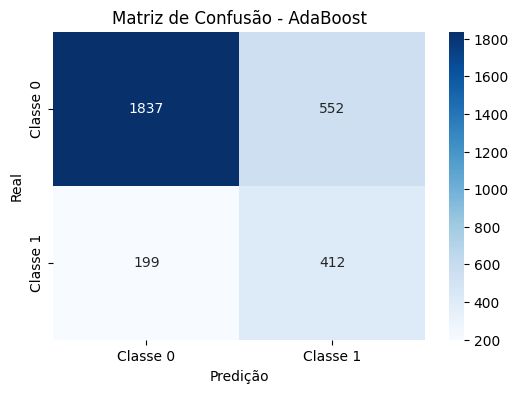


🏆 Resultados:


Modelo                       Config  Score (recall_1)  \
0  LogisticRegression  Bal:SMOTE|PCA:True|Scl:True          0.693944   
7            AdaBoost  Bal:SMOTE|PCA:True|Scl:True          0.674304   
2                 SVM  Bal:SMOTE|PCA:True|Scl:True          0.618658   
3                 KNN  Bal:SMOTE|PCA:True|Scl:True          0.589198   
5       NeuralNetwork  Bal:SMOTE|PCA:True|Scl:True          0.571195   
6             XGBoost  Bal:SMOTE|PCA:True|Scl:True          0.569558   
1        RandomForest  Bal:SMOTE|PCA:True|Scl:True          0.553191   
4        DecisionTree  Bal:SMOTE|PCA:True|Scl:True          0.518822   

   Recall (1)  Acurácia      Tempo Params  
0    0.693944  0.707333   0.015221    N/A  
7    0.674304  0.749667   1.488927    N/A  
2    0.618658  0.791333   2.783623    N/A  
3    0.589198  0.703667   0.017837    N/A  
5    0.571195  0.782667  12.302594    N/A  
6    0.569558  0.797667  10.984225    N/A  
1    0.553191  0.817667   4.065132    N/A  
4    0.518822  0.720667   0.334275    N/A


💾 Pipeline COMPLETA salva em: /home/dom-paje/llm-stack-containers/data/tf./resultados_treino/LogisticRegression_PIPELINE_COMPLETO.pkl

>>> 🧪 Testando Cenário: Default + PCA + Tomek
Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
Relatório para LogisticRegression:
              precision    recall  f1-score   support

    Classe 0       0.84      0.95      0.89      2389
    Classe 1       0.59      0.28      0.38       611

    accuracy                           0.81      3000
   macro avg       0.71      0.61      0.63      3000
weighted avg       0.79      0.81      0.79      3000



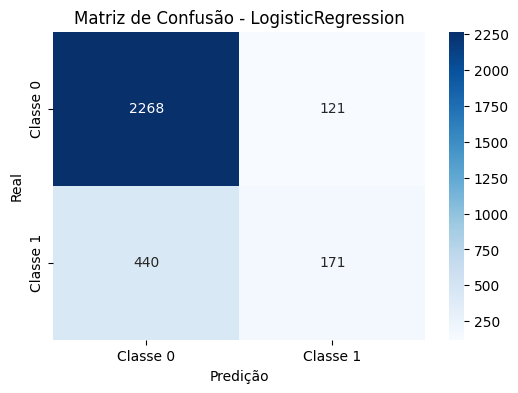

✨ Novo Recorde! LogisticRegression com recall_1: 0.2799

==================== RandomForest ====================
Relatório para RandomForest:
              precision    recall  f1-score   support

    Classe 0       0.86      0.95      0.90      2389
    Classe 1       0.66      0.40      0.50       611

    accuracy                           0.84      3000
   macro avg       0.76      0.67      0.70      3000
weighted avg       0.82      0.84      0.82      3000



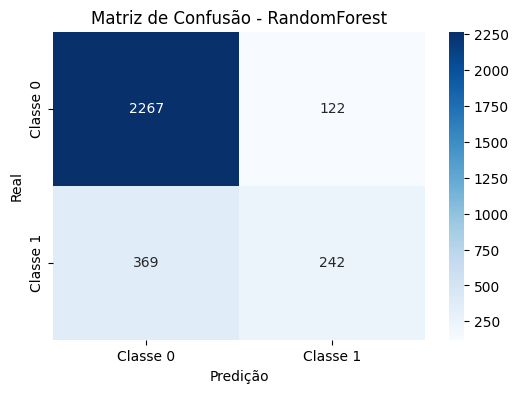

✨ Novo Recorde! RandomForest com recall_1: 0.3961

==================== SVM ====================
Relatório para SVM:
              precision    recall  f1-score   support

    Classe 0       0.85      0.96      0.91      2389
    Classe 1       0.72      0.35      0.47       611

    accuracy                           0.84      3000
   macro avg       0.79      0.66      0.69      3000
weighted avg       0.83      0.84      0.82      3000



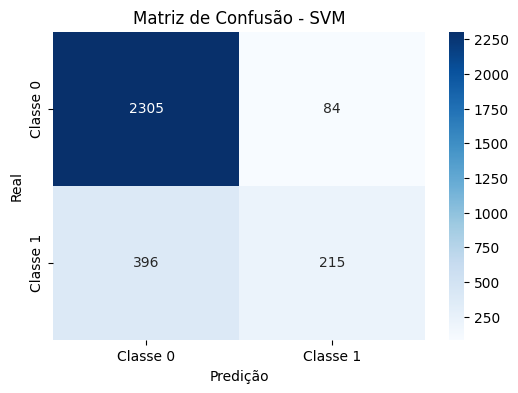


==================== KNN ====================
Relatório para KNN:
              precision    recall  f1-score   support

    Classe 0       0.84      0.93      0.88      2389
    Classe 1       0.53      0.30      0.38       611

    accuracy                           0.80      3000
   macro avg       0.69      0.62      0.63      3000
weighted avg       0.78      0.80      0.78      3000



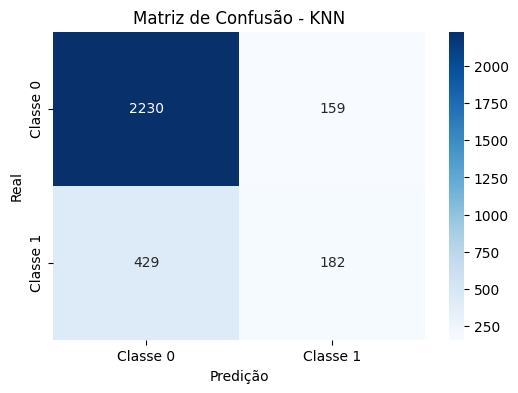


==================== DecisionTree ====================
Relatório para DecisionTree:
              precision    recall  f1-score   support

    Classe 0       0.86      0.83      0.84      2389
    Classe 1       0.41      0.46      0.43       611

    accuracy                           0.75      3000
   macro avg       0.63      0.64      0.64      3000
weighted avg       0.77      0.75      0.76      3000



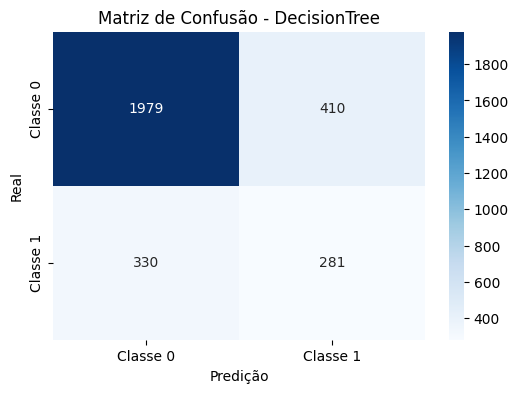

✨ Novo Recorde! DecisionTree com recall_1: 0.4599

==================== NeuralNetwork ====================
Relatório para NeuralNetwork:
              precision    recall  f1-score   support

    Classe 0       0.87      0.93      0.90      2389
    Classe 1       0.65      0.48      0.55       611

    accuracy                           0.84      3000
   macro avg       0.76      0.71      0.73      3000
weighted avg       0.83      0.84      0.83      3000



/home/dom-paje/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


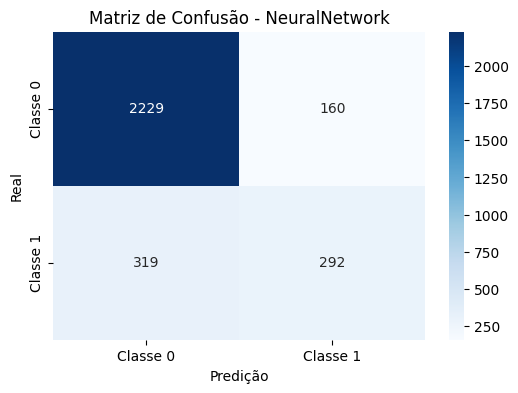

✨ Novo Recorde! NeuralNetwork com recall_1: 0.4779

==================== XGBoost ====================
Relatório para XGBoost:
              precision    recall  f1-score   support

    Classe 0       0.87      0.93      0.89      2389
    Classe 1       0.60      0.44      0.51       611

    accuracy                           0.83      3000
   macro avg       0.73      0.68      0.70      3000
weighted avg       0.81      0.83      0.82      3000



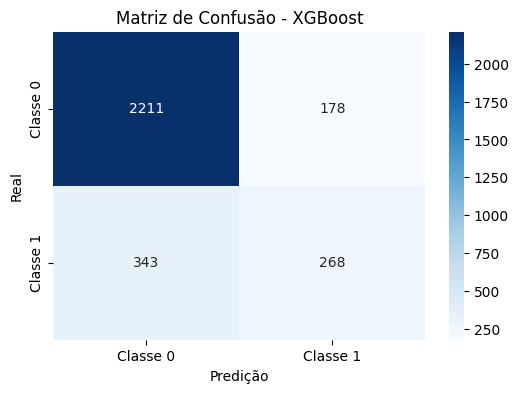


==================== AdaBoost ====================
Relatório para AdaBoost:
              precision    recall  f1-score   support

    Classe 0       0.86      0.93      0.90      2389
    Classe 1       0.62      0.42      0.50       611

    accuracy                           0.83      3000
   macro avg       0.74      0.68      0.70      3000
weighted avg       0.81      0.83      0.82      3000



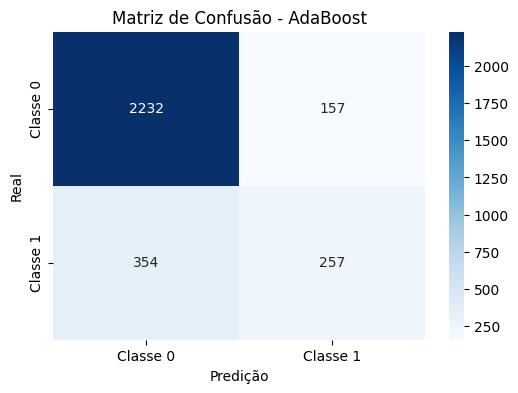


🏆 Resultados:


Modelo                            Config  Score (recall_1)  \
5       NeuralNetwork  Bal:TomekLinks|PCA:True|Scl:True          0.477905   
4        DecisionTree  Bal:TomekLinks|PCA:True|Scl:True          0.459902   
6             XGBoost  Bal:TomekLinks|PCA:True|Scl:True          0.438625   
7            AdaBoost  Bal:TomekLinks|PCA:True|Scl:True          0.420622   
1        RandomForest  Bal:TomekLinks|PCA:True|Scl:True          0.396072   
2                 SVM  Bal:TomekLinks|PCA:True|Scl:True          0.351882   
3                 KNN  Bal:TomekLinks|PCA:True|Scl:True          0.297872   
0  LogisticRegression  Bal:TomekLinks|PCA:True|Scl:True          0.279869   

   Recall (1)  Acurácia     Tempo Params  
5    0.477905  0.840333  7.733216    N/A  
4    0.459902  0.753333  0.225276    N/A  
6    0.438625  0.826333  6.569032    N/A  
7    0.420622  0.829667  0.831689    N/A  
1    0.396072  0.836333  2.724294    N/A  
2    0.351882  0.840000  0.783955    N/A  
3    0.297872  0.804000  0.009089    N/A  
0    0.279869  0.813000  0.008122    N/A


💾 Pipeline COMPLETA salva em: /home/dom-paje/llm-stack-containers/data/tf./resultados_treino/NeuralNetwork_PIPELINE_COMPLETO.pkl

>>> 🧪 Testando Cenário: Grid
Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Relatório para LogisticRegression:
              precision    recall  f1-score   support

    Classe 0       0.83      0.97      0.90      2389
    Classe 1       0.68      0.25      0.36       611

    accuracy                           0.82      3000
   macro avg       0.76      0.61      0.63      3000
weighted avg       0.80      0.82      0.79      3000



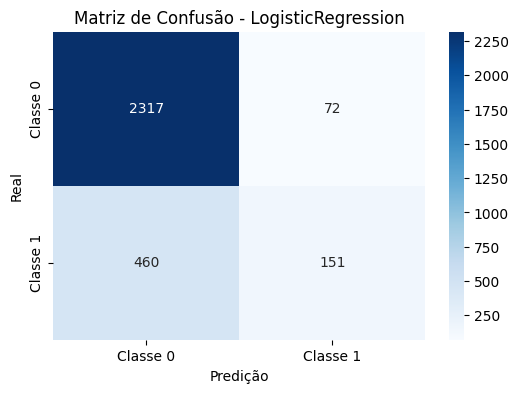

✨ Novo Recorde! LogisticRegression com recall_1: 0.2471

==================== RandomForest ====================
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Relatório para RandomForest:
              precision    recall  f1-score   support

    Classe 0       0.87      0.96      0.91      2389
    Classe 1       0.75      0.43      0.55       611

    accuracy                           0.85      3000
   macro avg       0.81      0.70      0.73      3000
weighted avg       0.84      0.85      0.84      3000



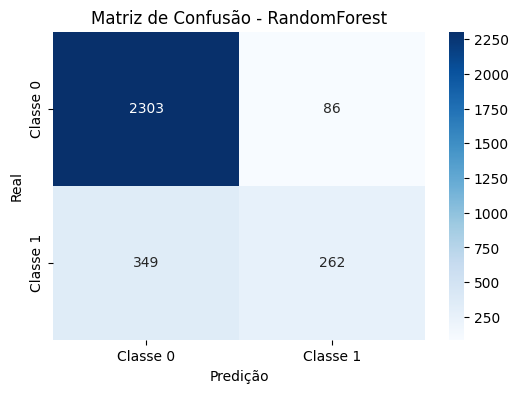

✨ Novo Recorde! RandomForest com recall_1: 0.4288

==================== SVM ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Relatório para SVM:
              precision    recall  f1-score   support

    Classe 0       0.87      0.94      0.90      2389
    Classe 1       0.67      0.44      0.53       611

    accuracy                           0.84      3000
   macro avg       0.77      0.69      0.72      3000
weighted avg       0.83      0.84      0.83      3000



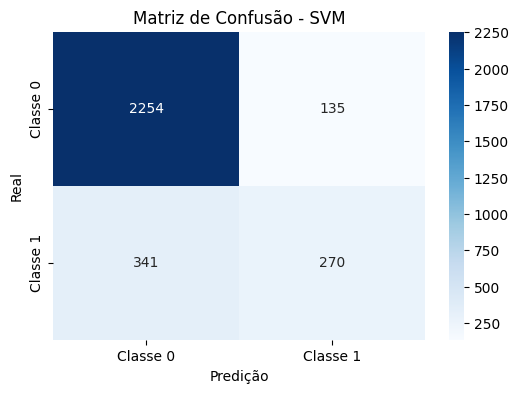

✨ Novo Recorde! SVM com recall_1: 0.4419

==================== KNN ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Relatório para KNN:
              precision    recall  f1-score   support

    Classe 0       0.84      0.92      0.88      2389
    Classe 1       0.49      0.29      0.36       611

    accuracy                           0.79      3000
   macro avg       0.66      0.61      0.62      3000
weighted avg       0.76      0.79      0.77      3000



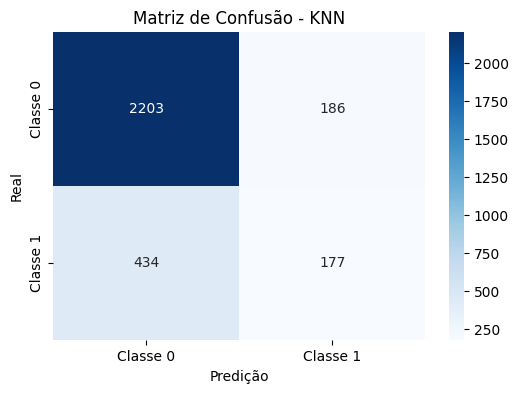


==================== DecisionTree ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Relatório para DecisionTree:
              precision    recall  f1-score   support

    Classe 0       0.87      0.86      0.86      2389
    Classe 1       0.47      0.47      0.47       611

    accuracy                           0.78      3000
   macro avg       0.67      0.67      0.67      3000
weighted avg       0.78      0.78      0.78      3000



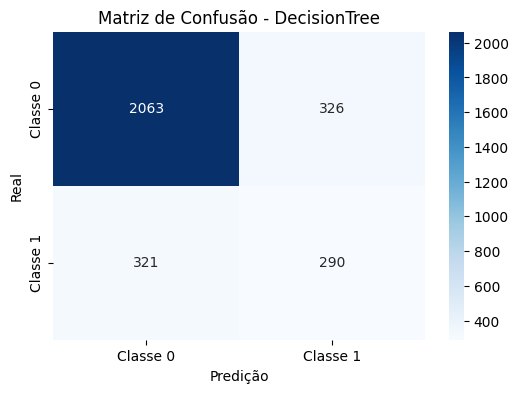

✨ Novo Recorde! DecisionTree com recall_1: 0.4746

==================== NeuralNetwork ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/dom-paje/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dom-paje/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dom-paje/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dom-paje/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dom-paje/.local/lib/python3.8/site-pac

Relatório para NeuralNetwork:
              precision    recall  f1-score   support

    Classe 0       0.88      0.91      0.89      2389
    Classe 1       0.58      0.51      0.54       611

    accuracy                           0.82      3000
   macro avg       0.73      0.71      0.72      3000
weighted avg       0.82      0.82      0.82      3000



/home/dom-paje/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


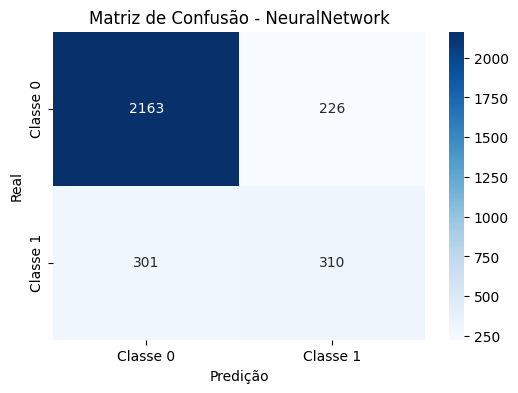

✨ Novo Recorde! NeuralNetwork com recall_1: 0.5074

==================== XGBoost ====================
Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/home/dom-paje/.local/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/dom-paje/.local/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain fea

Relatório para XGBoost:
              precision    recall  f1-score   support

    Classe 0       0.87      0.95      0.91      2389
    Classe 1       0.70      0.46      0.56       611

    accuracy                           0.85      3000
   macro avg       0.79      0.71      0.73      3000
weighted avg       0.84      0.85      0.84      3000



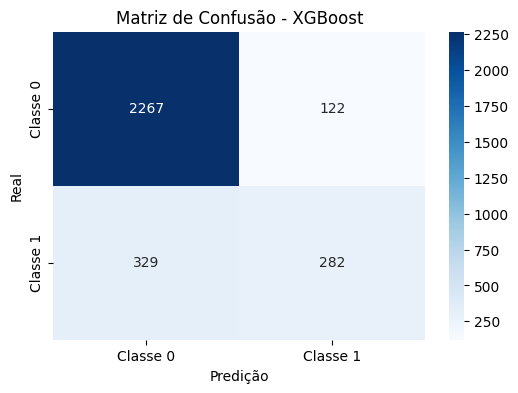


==================== AdaBoost ====================
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Relatório para AdaBoost:
              precision    recall  f1-score   support

    Classe 0       0.87      0.96      0.91      2389
    Classe 1       0.72      0.43      0.53       611

    accuracy                           0.85      3000
   macro avg       0.79      0.69      0.72      3000
weighted avg       0.84      0.85      0.83      3000



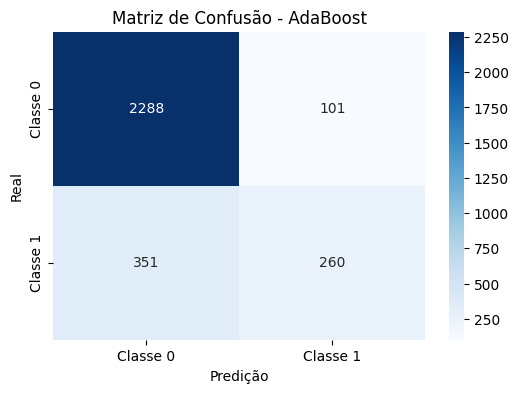


🏆 Resultados:


Modelo                       Config  Score (recall_1)  \
5       NeuralNetwork  Bal:None|PCA:False|Scl:True          0.507365   
4        DecisionTree  Bal:None|PCA:False|Scl:True          0.474632   
6             XGBoost  Bal:None|PCA:False|Scl:True          0.461538   
2                 SVM  Bal:None|PCA:False|Scl:True          0.441899   
1        RandomForest  Bal:None|PCA:False|Scl:True          0.428805   
7            AdaBoost  Bal:None|PCA:False|Scl:True          0.425532   
3                 KNN  Bal:None|PCA:False|Scl:True          0.289689   
0  LogisticRegression  Bal:None|PCA:False|Scl:True          0.247136   

   Recall (1)  Acurácia      Tempo  \
5    0.507365  0.824333  16.449875   
4    0.474632  0.784333   0.276926   
6    0.461538  0.849667  16.852012   
2    0.441899  0.841333   3.972379   
1    0.428805  0.855000   7.556686   
7    0.425532  0.849333   1.705675   
3    0.289689  0.793333   0.320552   
0    0.247136  0.822667   7.306499   

                                              Params  
5  {'activation': 'relu', 'alpha': 0.0001, 'hidde...  
4  {'max_depth': 20, 'min_samples_leaf': 1, 'min_...  
6  {'colsample_bytree': 0.8, 'learning_rate': 0.2...  
2       {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}  
1  {'max_depth': 20, 'min_samples_leaf': 1, 'min_...  
7  {'algorithm': 'SAMME.R', 'learning_rate': 1.0,...  
3  {'metric': 'euclidean', 'n_neighbors': 3, 'wei...  
0     {'C': 1.0, 'max_iter': 500, 'solver': 'lbfgs'}


💾 Pipeline COMPLETA salva em: /home/dom-paje/llm-stack-containers/data/tf./resultados_treino/NeuralNetwork_PIPELINE_COMPLETO.pkl

>>> 🧪 Testando Cenário: Grid + SMOTE
Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Relatório para LogisticRegression:
              precision    recall  f1-score   support

    Classe 0       0.90      0.71      0.79      2389
    Classe 1       0.38      0.69      0.49       611

    accuracy                           0.71      3000
   macro avg       0.64      0.70      0.64      3000
weighted avg       0.79      0.71      0.73      3000



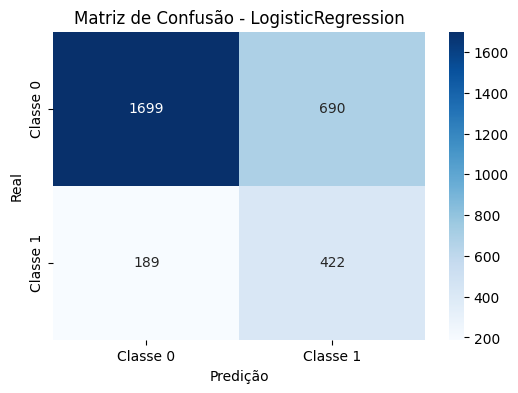

✨ Novo Recorde! LogisticRegression com recall_1: 0.6907

==================== RandomForest ====================
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Relatório para RandomForest:
              precision    recall  f1-score   support

    Classe 0       0.88      0.92      0.90      2389
    Classe 1       0.62      0.53      0.57       611

    accuracy                           0.84      3000
   macro avg       0.75      0.73      0.74      3000
weighted avg       0.83      0.84      0.83      3000



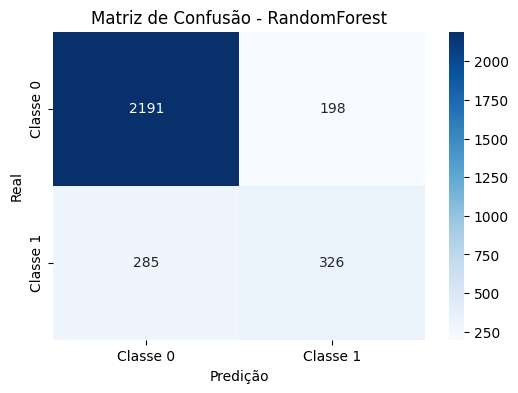


==================== SVM ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Relatório para SVM:
              precision    recall  f1-score   support

    Classe 0       0.88      0.86      0.87      2389
    Classe 1       0.48      0.53      0.50       611

    accuracy                           0.79      3000
   macro avg       0.68      0.69      0.69      3000
weighted avg       0.80      0.79      0.79      3000



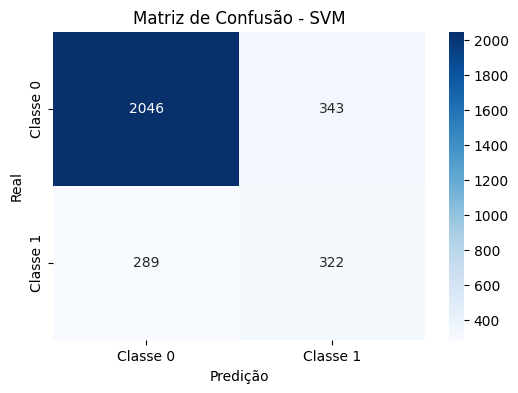


==================== KNN ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Relatório para KNN:
              precision    recall  f1-score   support

    Classe 0       0.87      0.77      0.81      2389
    Classe 1       0.37      0.54      0.44       611

    accuracy                           0.72      3000
   macro avg       0.62      0.65      0.63      3000
weighted avg       0.77      0.72      0.74      3000



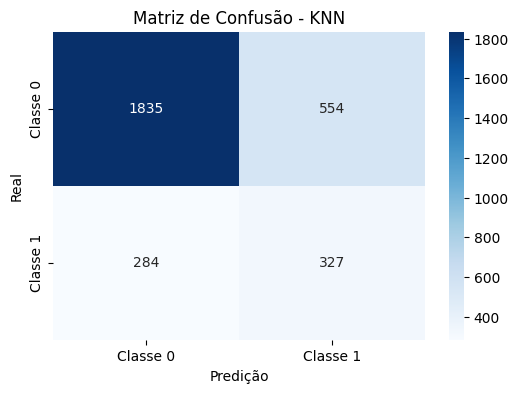


==================== DecisionTree ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Relatório para DecisionTree:
              precision    recall  f1-score   support

    Classe 0       0.87      0.82      0.84      2389
    Classe 1       0.42      0.51      0.46       611

    accuracy                           0.76      3000
   macro avg       0.64      0.66      0.65      3000
weighted avg       0.78      0.76      0.77      3000



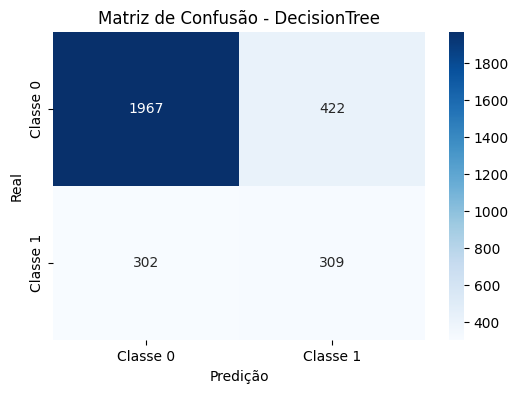


==================== NeuralNetwork ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/dom-paje/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dom-paje/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dom-paje/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dom-paje/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dom-paje/.local/lib/python3.8/site-pac

Relatório para NeuralNetwork:
              precision    recall  f1-score   support

    Classe 0       0.87      0.84      0.85      2389
    Classe 1       0.44      0.49      0.47       611

    accuracy                           0.77      3000
   macro avg       0.65      0.67      0.66      3000
weighted avg       0.78      0.77      0.77      3000



/home/dom-paje/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


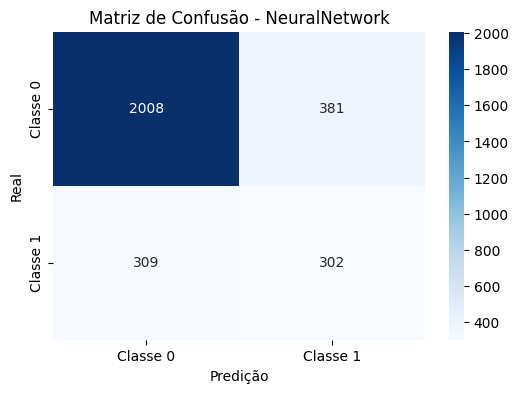


==================== XGBoost ====================
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Relatório para XGBoost:
              precision    recall  f1-score   support

    Classe 0       0.88      0.93      0.90      2389
    Classe 1       0.65      0.52      0.57       611

    accuracy                           0.84      3000
   macro avg       0.76      0.72      0.74      3000
weighted avg       0.83      0.84      0.84      3000



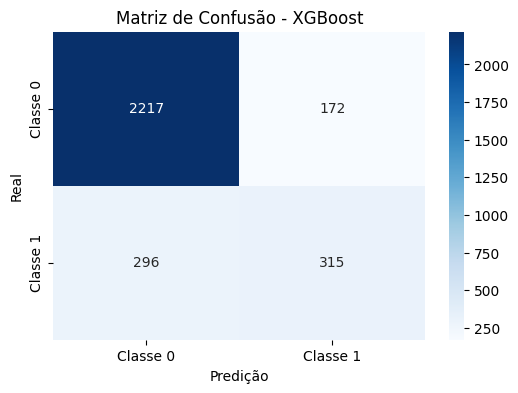


==================== AdaBoost ====================
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Relatório para AdaBoost:
              precision    recall  f1-score   support

    Classe 0       0.89      0.88      0.88      2389
    Classe 1       0.54      0.58      0.56       611

    accuracy                           0.82      3000
   macro avg       0.72      0.73      0.72      3000
weighted avg       0.82      0.82      0.82      3000



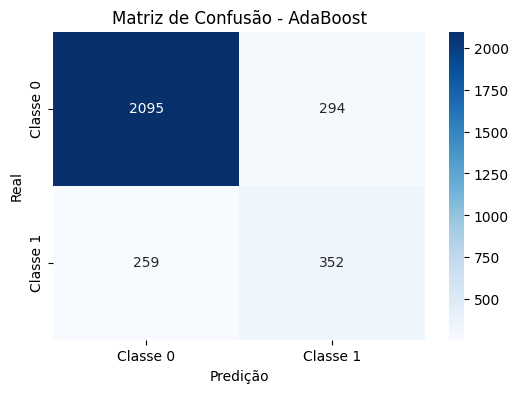


🏆 Resultados:


Modelo                        Config  Score (recall_1)  \
0  LogisticRegression  Bal:SMOTE|PCA:False|Scl:True          0.690671   
7            AdaBoost  Bal:SMOTE|PCA:False|Scl:True          0.576105   
3                 KNN  Bal:SMOTE|PCA:False|Scl:True          0.535188   
1        RandomForest  Bal:SMOTE|PCA:False|Scl:True          0.533552   
2                 SVM  Bal:SMOTE|PCA:False|Scl:True          0.527005   
6             XGBoost  Bal:SMOTE|PCA:False|Scl:True          0.515548   
4        DecisionTree  Bal:SMOTE|PCA:False|Scl:True          0.505728   
5       NeuralNetwork  Bal:SMOTE|PCA:False|Scl:True          0.494272   

   Recall (1)  Acurácia       Tempo  \
0    0.690671  0.707000    0.221244   
7    0.576105  0.815667    3.591147   
3    0.535188  0.720667    0.588594   
1    0.533552  0.839000   12.449563   
2    0.527005  0.789333   14.792886   
6    0.515548  0.844000  166.422593   
4    0.505728  0.758667    0.389204   
5    0.494272  0.770000   29.083033   

                                              Params  
0  {'C': 0.1, 'max_iter': 500, 'solver': 'libline...  
7  {'algorithm': 'SAMME.R', 'learning_rate': 1.0,...  
3  {'metric': 'euclidean', 'n_neighbors': 3, 'wei...  
1  {'max_depth': 20, 'min_samples_leaf': 1, 'min_...  
2       {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}  
6  {'colsample_bytree': 1.0, 'learning_rate': 0.2...  
4  {'max_depth': 20, 'min_samples_leaf': 1, 'min_...  
5  {'activation': 'tanh', 'alpha': 0.001, 'hidden...


💾 Pipeline COMPLETA salva em: /home/dom-paje/llm-stack-containers/data/tf./resultados_treino/LogisticRegression_PIPELINE_COMPLETO.pkl

>>> 🧪 Testando Cenário: Grid + Tomek
Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Relatório para LogisticRegression:
              precision    recall  f1-score   support

    Classe 0       0.84      0.95      0.89      2389
    Classe 1       0.59      0.28      0.38       611

    accuracy                           0.81      3000
   macro avg       0.72      0.62      0.64      3000
weighted avg       0.79      0.81      0.79      3000



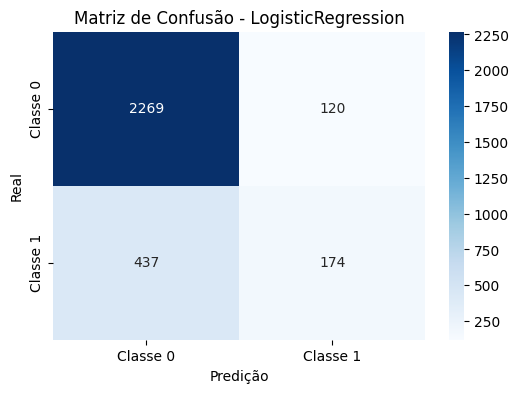

✨ Novo Recorde! LogisticRegression com recall_1: 0.2848

==================== RandomForest ====================
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Relatório para RandomForest:
              precision    recall  f1-score   support

    Classe 0       0.87      0.96      0.91      2389
    Classe 1       0.74      0.46      0.57       611

    accuracy                           0.86      3000
   macro avg       0.80      0.71      0.74      3000
weighted avg       0.85      0.86      0.84      3000



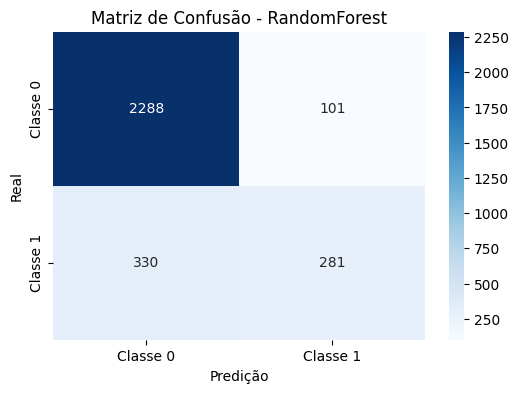

✨ Novo Recorde! RandomForest com recall_1: 0.4599

==================== SVM ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Relatório para SVM:
              precision    recall  f1-score   support

    Classe 0       0.87      0.92      0.89      2389
    Classe 1       0.59      0.47      0.52       611

    accuracy                           0.83      3000
   macro avg       0.73      0.69      0.71      3000
weighted avg       0.81      0.83      0.82      3000



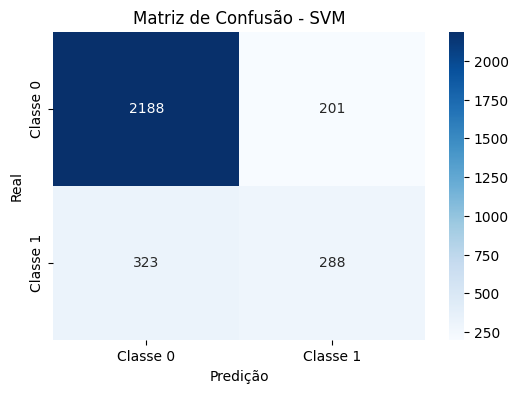

✨ Novo Recorde! SVM com recall_1: 0.4714

==================== KNN ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Relatório para KNN:
              precision    recall  f1-score   support

    Classe 0       0.84      0.90      0.87      2389
    Classe 1       0.48      0.35      0.41       611

    accuracy                           0.79      3000
   macro avg       0.66      0.63      0.64      3000
weighted avg       0.77      0.79      0.78      3000



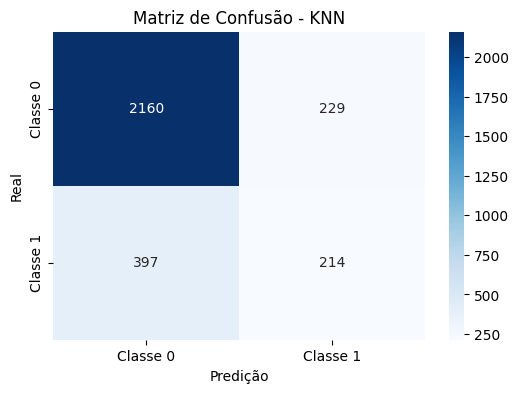


==================== DecisionTree ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Relatório para DecisionTree:
              precision    recall  f1-score   support

    Classe 0       0.87      0.85      0.86      2389
    Classe 1       0.47      0.50      0.48       611

    accuracy                           0.78      3000
   macro avg       0.67      0.68      0.67      3000
weighted avg       0.79      0.78      0.79      3000



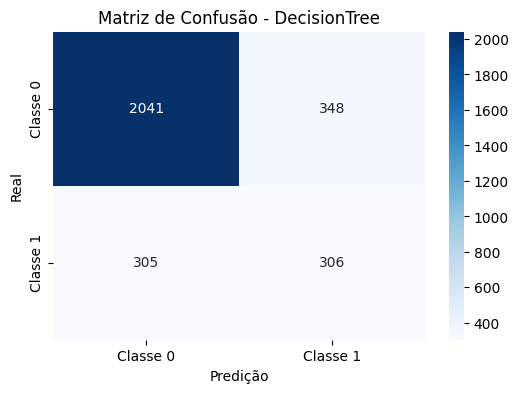

✨ Novo Recorde! DecisionTree com recall_1: 0.5008

==================== NeuralNetwork ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/dom-paje/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dom-paje/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dom-paje/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dom-paje/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dom-paje/.local/lib/python3.8/site-pac

Relatório para NeuralNetwork:
              precision    recall  f1-score   support

    Classe 0       0.87      0.87      0.87      2389
    Classe 1       0.50      0.51      0.51       611

    accuracy                           0.80      3000
   macro avg       0.69      0.69      0.69      3000
weighted avg       0.80      0.80      0.80      3000



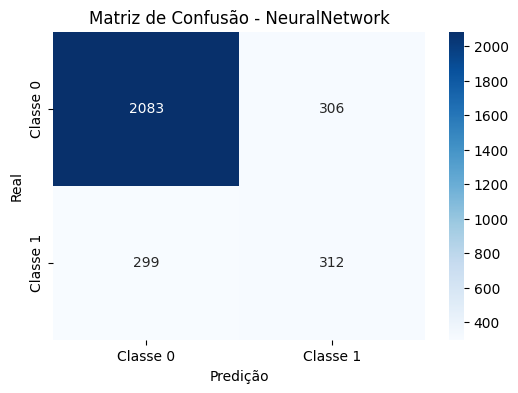

✨ Novo Recorde! NeuralNetwork com recall_1: 0.5106

==================== XGBoost ====================
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Relatório para XGBoost:
              precision    recall  f1-score   support

    Classe 0       0.88      0.94      0.91      2389
    Classe 1       0.68      0.50      0.58       611

    accuracy                           0.85      3000
   macro avg       0.78      0.72      0.74      3000
weighted avg       0.84      0.85      0.84      3000



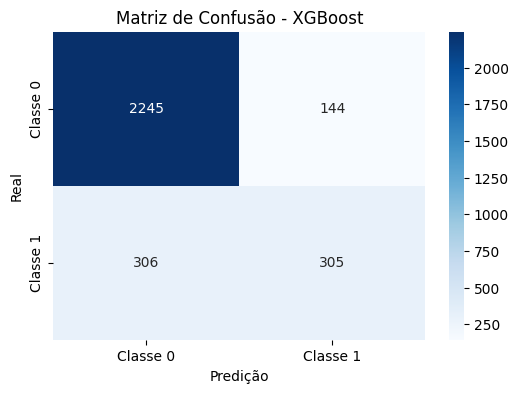


==================== AdaBoost ====================
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Relatório para AdaBoost:
              precision    recall  f1-score   support

    Classe 0       0.87      0.94      0.91      2389
    Classe 1       0.67      0.46      0.54       611

    accuracy                           0.84      3000
   macro avg       0.77      0.70      0.72      3000
weighted avg       0.83      0.84      0.83      3000



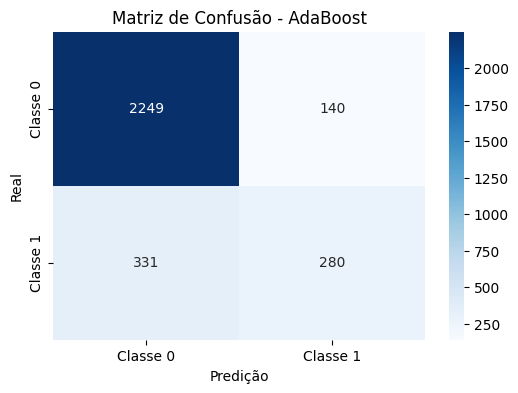


🏆 Resultados:


Modelo                             Config  Score (recall_1)  \
5       NeuralNetwork  Bal:TomekLinks|PCA:False|Scl:True          0.510638   
4        DecisionTree  Bal:TomekLinks|PCA:False|Scl:True          0.500818   
6             XGBoost  Bal:TomekLinks|PCA:False|Scl:True          0.499182   
2                 SVM  Bal:TomekLinks|PCA:False|Scl:True          0.471358   
1        RandomForest  Bal:TomekLinks|PCA:False|Scl:True          0.459902   
7            AdaBoost  Bal:TomekLinks|PCA:False|Scl:True          0.458265   
3                 KNN  Bal:TomekLinks|PCA:False|Scl:True          0.350245   
0  LogisticRegression  Bal:TomekLinks|PCA:False|Scl:True          0.284779   

   Recall (1)  Acurácia      Tempo  \
5    0.510638  0.798333  13.642135   
4    0.500818  0.782333   0.213648   
6    0.499182  0.850000  53.917166   
2    0.471358  0.825333   3.471420   
1    0.459902  0.856333   4.577045   
7    0.458265  0.843000   1.608183   
3    0.350245  0.791333   0.299718   
0    0.284779  0.814333   0.146772   

                                              Params  
5  {'activation': 'relu', 'alpha': 0.001, 'hidden...  
4  {'max_depth': 20, 'min_samples_leaf': 1, 'min_...  
6  {'colsample_bytree': 0.8, 'learning_rate': 0.1...  
2       {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}  
1  {'max_depth': None, 'min_samples_leaf': 1, 'mi...  
7  {'algorithm': 'SAMME.R', 'learning_rate': 1.0,...  
3  {'metric': 'euclidean', 'n_neighbors': 3, 'wei...  
0  {'C': 1.0, 'max_iter': 500, 'solver': 'libline...


💾 Pipeline COMPLETA salva em: /home/dom-paje/llm-stack-containers/data/tf./resultados_treino/NeuralNetwork_PIPELINE_COMPLETO.pkl

>>> 🧪 Testando Cenário: Grid + PCA + SMOTE
Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Relatório para LogisticRegression:
              precision    recall  f1-score   support

    Classe 0       0.90      0.71      0.79      2389
    Classe 1       0.38      0.69      0.49       611

    accuracy                           0.71      3000
   macro avg       0.64      0.70      0.64      3000
weighted avg       0.79      0.71      0.73      3000



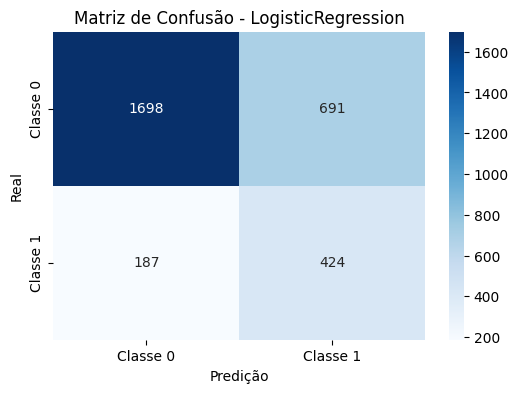

✨ Novo Recorde! LogisticRegression com recall_1: 0.6939

==================== RandomForest ====================
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Relatório para RandomForest:
              precision    recall  f1-score   support

    Classe 0       0.88      0.87      0.88      2389
    Classe 1       0.53      0.55      0.54       611

    accuracy                           0.81      3000
   macro avg       0.70      0.71      0.71      3000
weighted avg       0.81      0.81      0.81      3000



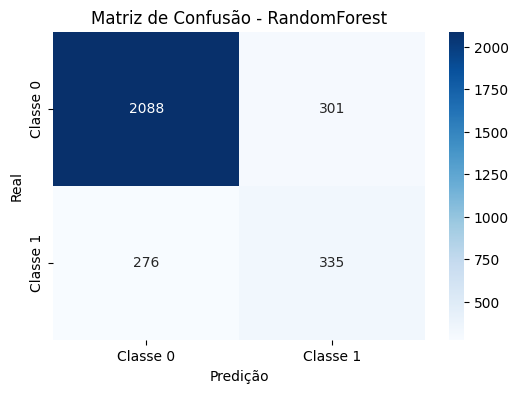


==================== SVM ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Relatório para SVM:
              precision    recall  f1-score   support

    Classe 0       0.88      0.86      0.87      2389
    Classe 1       0.49      0.53      0.51       611

    accuracy                           0.79      3000
   macro avg       0.68      0.69      0.69      3000
weighted avg       0.80      0.79      0.79      3000



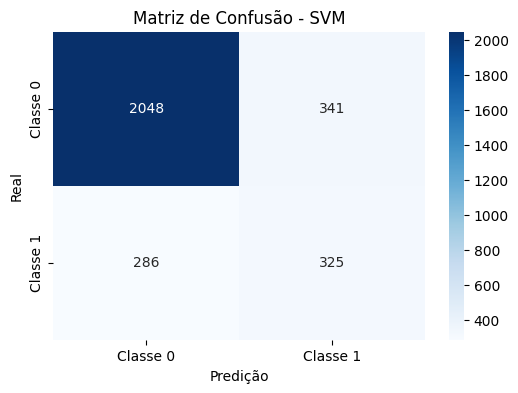


==================== KNN ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Relatório para KNN:
              precision    recall  f1-score   support

    Classe 0       0.87      0.77      0.81      2389
    Classe 1       0.37      0.54      0.44       611

    accuracy                           0.72      3000
   macro avg       0.62      0.65      0.63      3000
weighted avg       0.77      0.72      0.74      3000



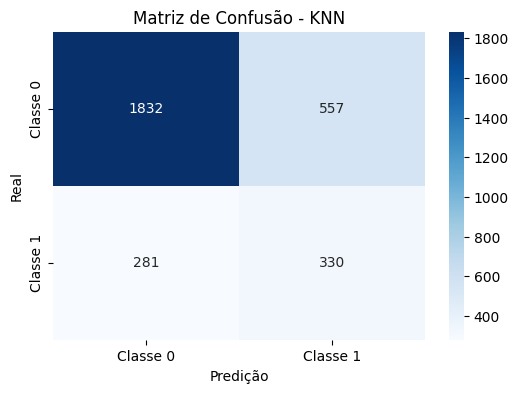


==================== DecisionTree ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Relatório para DecisionTree:
              precision    recall  f1-score   support

    Classe 0       0.87      0.78      0.82      2389
    Classe 1       0.38      0.53      0.44       611

    accuracy                           0.73      3000
   macro avg       0.62      0.65      0.63      3000
weighted avg       0.77      0.73      0.74      3000



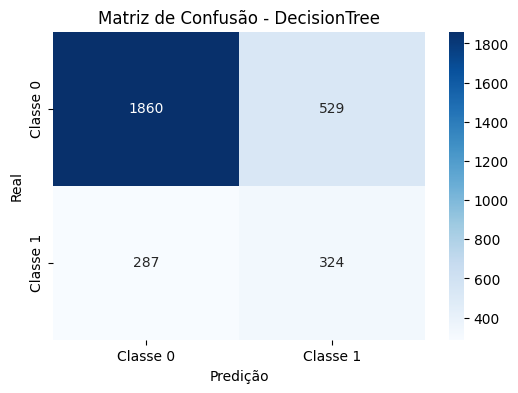


==================== NeuralNetwork ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/dom-paje/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dom-paje/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dom-paje/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dom-paje/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dom-paje/.local/lib/python3.8/site-pac

Relatório para NeuralNetwork:
              precision    recall  f1-score   support

    Classe 0       0.87      0.86      0.86      2389
    Classe 1       0.48      0.51      0.49       611

    accuracy                           0.79      3000
   macro avg       0.67      0.68      0.68      3000
weighted avg       0.79      0.79      0.79      3000



/home/dom-paje/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


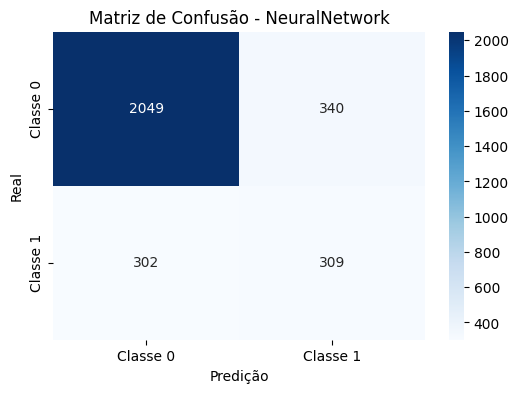


==================== XGBoost ====================
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Relatório para XGBoost:
              precision    recall  f1-score   support

    Classe 0       0.88      0.87      0.88      2389
    Classe 1       0.52      0.53      0.53       611

    accuracy                           0.80      3000
   macro avg       0.70      0.70      0.70      3000
weighted avg       0.81      0.80      0.81      3000



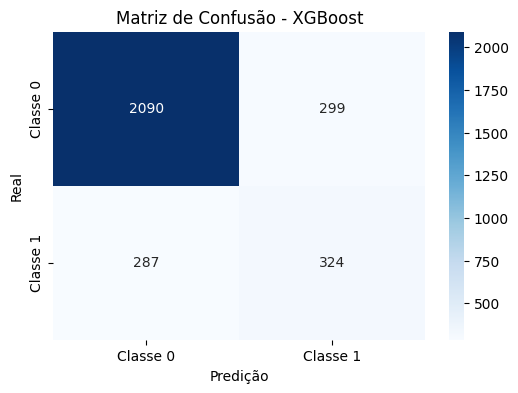


==================== AdaBoost ====================
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Relatório para AdaBoost:
              precision    recall  f1-score   support

    Classe 0       0.91      0.77      0.84      2389
    Classe 1       0.44      0.70      0.54       611

    accuracy                           0.76      3000
   macro avg       0.67      0.74      0.69      3000
weighted avg       0.81      0.76      0.78      3000



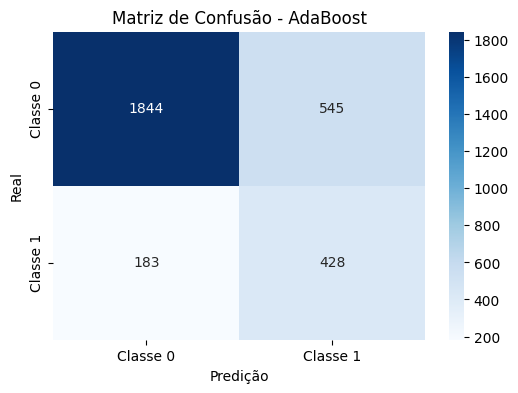

✨ Novo Recorde! AdaBoost com recall_1: 0.7005

🏆 Resultados:


Modelo                       Config  Score (recall_1)  \
7            AdaBoost  Bal:SMOTE|PCA:True|Scl:True          0.700491   
0  LogisticRegression  Bal:SMOTE|PCA:True|Scl:True          0.693944   
1        RandomForest  Bal:SMOTE|PCA:True|Scl:True          0.548282   
3                 KNN  Bal:SMOTE|PCA:True|Scl:True          0.540098   
2                 SVM  Bal:SMOTE|PCA:True|Scl:True          0.531915   
4        DecisionTree  Bal:SMOTE|PCA:True|Scl:True          0.530278   
6             XGBoost  Bal:SMOTE|PCA:True|Scl:True          0.530278   
5       NeuralNetwork  Bal:SMOTE|PCA:True|Scl:True          0.505728   

   Recall (1)  Acurácia       Tempo  \
7    0.700491  0.757333   11.264935   
0    0.693944  0.707333    0.254483   
1    0.548282  0.807667   25.101850   
3    0.540098  0.720667    0.896523   
2    0.531915  0.791000   14.170502   
4    0.530278  0.728000    0.760826   
6    0.530278  0.804667  156.396366   
5    0.505728  0.786000   27.913528   

                                              Params  
7  {'algorithm': 'SAMME.R', 'learning_rate': 1.0,...  
0  {'C': 0.1, 'max_iter': 500, 'solver': 'libline...  
1  {'max_depth': None, 'min_samples_leaf': 1, 'mi...  
3  {'metric': 'euclidean', 'n_neighbors': 3, 'wei...  
2        {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}  
4  {'max_depth': 20, 'min_samples_leaf': 1, 'min_...  
6  {'colsample_bytree': 1.0, 'learning_rate': 0.2...  
5  {'activation': 'tanh', 'alpha': 0.0001, 'hidde...


💾 Pipeline COMPLETA salva em: /home/dom-paje/llm-stack-containers/data/tf./resultados_treino/AdaBoost_PIPELINE_COMPLETO.pkl

>>> 🧪 Testando Cenário: Grid + PCA + Tomek
Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Relatório para LogisticRegression:
              precision    recall  f1-score   support

    Classe 0       0.84      0.95      0.89      2389
    Classe 1       0.59      0.28      0.38       611

    accuracy                           0.81      3000
   macro avg       0.71      0.61      0.63      3000
weighted avg       0.79      0.81      0.79      3000



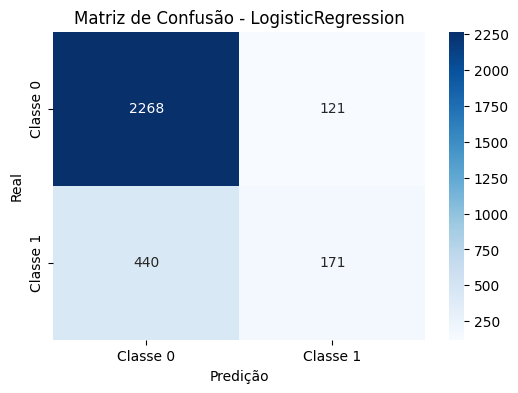

✨ Novo Recorde! LogisticRegression com recall_1: 0.2799

==================== RandomForest ====================
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Relatório para RandomForest:
              precision    recall  f1-score   support

    Classe 0       0.86      0.95      0.90      2389
    Classe 1       0.66      0.40      0.49       611

    accuracy                           0.84      3000
   macro avg       0.76      0.67      0.70      3000
weighted avg       0.82      0.84      0.82      3000



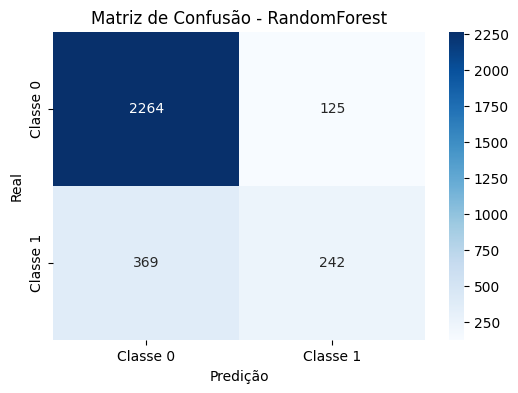

✨ Novo Recorde! RandomForest com recall_1: 0.3961

==================== SVM ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Relatório para SVM:
              precision    recall  f1-score   support

    Classe 0       0.87      0.91      0.89      2389
    Classe 1       0.57      0.45      0.50       611

    accuracy                           0.82      3000
   macro avg       0.72      0.68      0.70      3000
weighted avg       0.81      0.82      0.81      3000



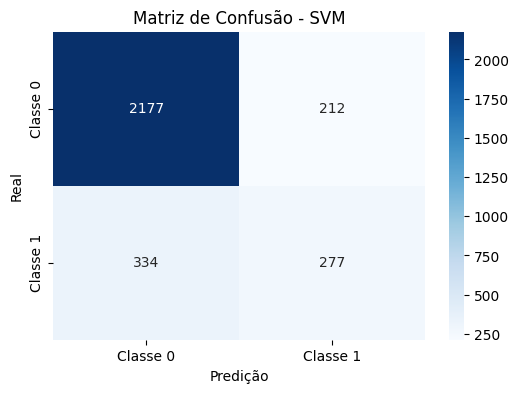

✨ Novo Recorde! SVM com recall_1: 0.4534

==================== KNN ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Relatório para KNN:
              precision    recall  f1-score   support

    Classe 0       0.85      0.91      0.88      2389
    Classe 1       0.50      0.36      0.42       611

    accuracy                           0.80      3000
   macro avg       0.68      0.64      0.65      3000
weighted avg       0.78      0.80      0.78      3000



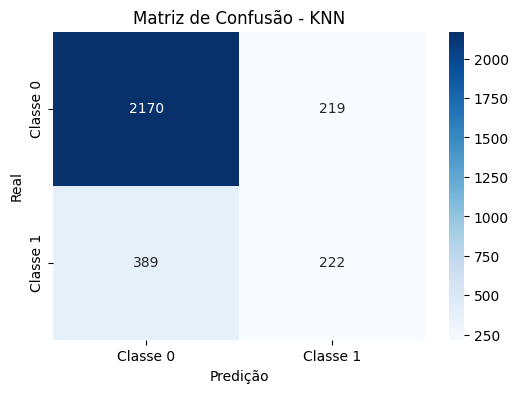


==================== DecisionTree ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Relatório para DecisionTree:
              precision    recall  f1-score   support

    Classe 0       0.86      0.83      0.85      2389
    Classe 1       0.42      0.47      0.44       611

    accuracy                           0.76      3000
   macro avg       0.64      0.65      0.64      3000
weighted avg       0.77      0.76      0.76      3000



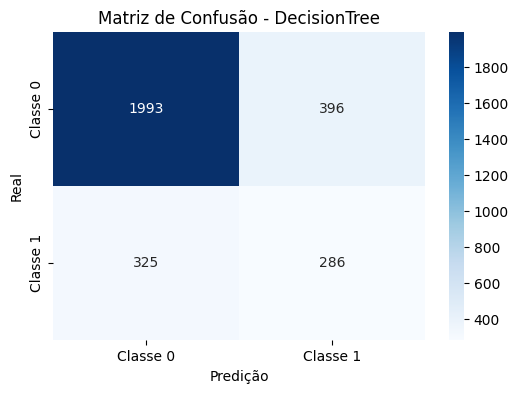

✨ Novo Recorde! DecisionTree com recall_1: 0.4681

==================== NeuralNetwork ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/dom-paje/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dom-paje/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dom-paje/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dom-paje/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dom-paje/.local/lib/python3.8/site-pac

Relatório para NeuralNetwork:
              precision    recall  f1-score   support

    Classe 0       0.87      0.89      0.88      2389
    Classe 1       0.54      0.48      0.51       611

    accuracy                           0.81      3000
   macro avg       0.71      0.69      0.70      3000
weighted avg       0.80      0.81      0.81      3000



/home/dom-paje/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


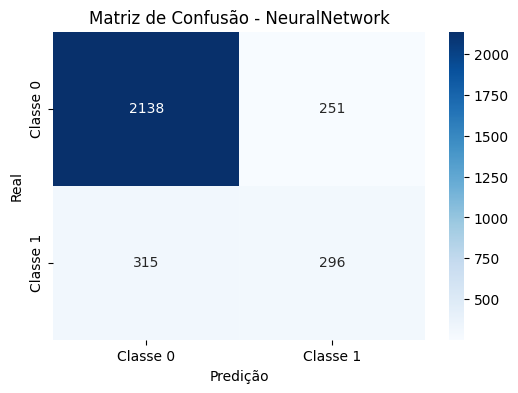

✨ Novo Recorde! NeuralNetwork com recall_1: 0.4845

==================== XGBoost ====================
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Relatório para XGBoost:
              precision    recall  f1-score   support

    Classe 0       0.87      0.92      0.90      2389
    Classe 1       0.60      0.46      0.52       611

    accuracy                           0.83      3000
   macro avg       0.74      0.69      0.71      3000
weighted avg       0.82      0.83      0.82      3000



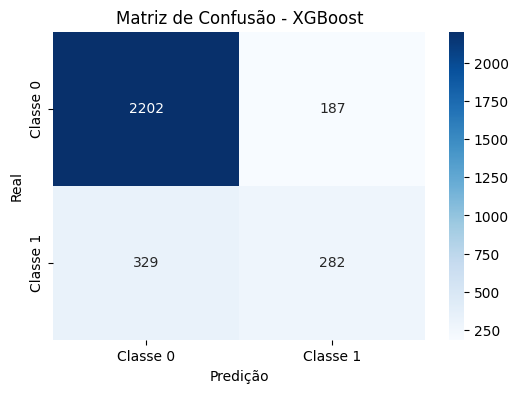


==================== AdaBoost ====================
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Relatório para AdaBoost:
              precision    recall  f1-score   support

    Classe 0       0.87      0.93      0.90      2389
    Classe 1       0.61      0.44      0.51       611

    accuracy                           0.83      3000
   macro avg       0.74      0.69      0.71      3000
weighted avg       0.82      0.83      0.82      3000



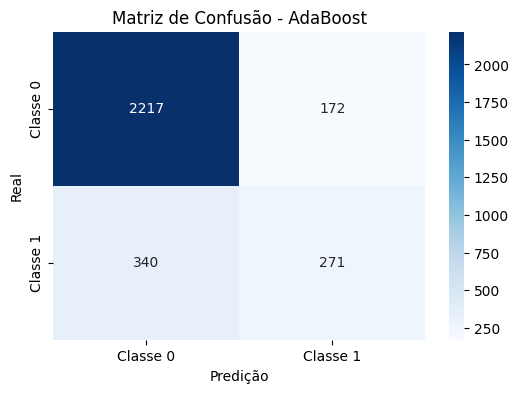


🏆 Resultados:


Modelo                            Config  Score (recall_1)  \
5       NeuralNetwork  Bal:TomekLinks|PCA:True|Scl:True          0.484452   
4        DecisionTree  Bal:TomekLinks|PCA:True|Scl:True          0.468085   
6             XGBoost  Bal:TomekLinks|PCA:True|Scl:True          0.461538   
2                 SVM  Bal:TomekLinks|PCA:True|Scl:True          0.453355   
7            AdaBoost  Bal:TomekLinks|PCA:True|Scl:True          0.443535   
1        RandomForest  Bal:TomekLinks|PCA:True|Scl:True          0.396072   
3                 KNN  Bal:TomekLinks|PCA:True|Scl:True          0.363339   
0  LogisticRegression  Bal:TomekLinks|PCA:True|Scl:True          0.279869   

   Recall (1)  Acurácia      Tempo  \
5    0.484452  0.811333  17.773329   
4    0.468085  0.759667   0.523628   
6    0.461538  0.828000  25.313869   
2    0.453355  0.818000   3.492148   
7    0.443535  0.829333   6.329061   
1    0.396072  0.835333  16.855834   
3    0.363339  0.797333   0.368636   
0    0.279869  0.813000   0.168270   

                                              Params  
5  {'activation': 'tanh', 'alpha': 0.001, 'hidden...  
4  {'max_depth': None, 'min_samples_leaf': 1, 'mi...  
6  {'colsample_bytree': 1.0, 'learning_rate': 0.2...  
2        {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}  
7  {'algorithm': 'SAMME.R', 'learning_rate': 1.0,...  
1  {'max_depth': None, 'min_samples_leaf': 1, 'mi...  
3  {'metric': 'manhattan', 'n_neighbors': 3, 'wei...  
0  {'C': 1.0, 'max_iter': 500, 'solver': 'libline...


💾 Pipeline COMPLETA salva em: /home/dom-paje/llm-stack-containers/data/tf./resultados_treino/NeuralNetwork_PIPELINE_COMPLETO.pkl

>>> 🧪 Testando Cenário: Best
Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
Relatório para LogisticRegression:
              precision    recall  f1-score   support

    Classe 0       0.83      0.97      0.90      2389
    Classe 1       0.68      0.25      0.36       611

    accuracy                           0.82      3000
   macro avg       0.76      0.61      0.63      3000
weighted avg       0.80      0.82      0.79      3000



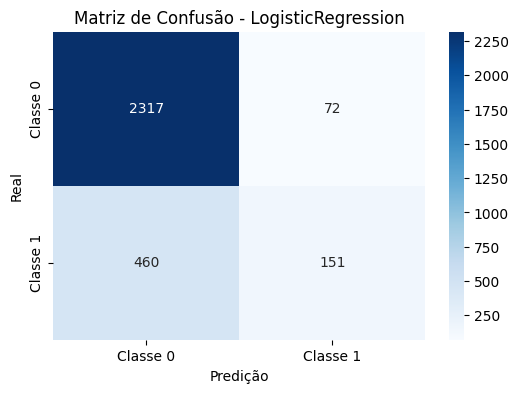

✨ Novo Recorde! LogisticRegression com recall_1: 0.2471

==================== RandomForest ====================
Relatório para RandomForest:
              precision    recall  f1-score   support

    Classe 0       0.87      0.97      0.91      2389
    Classe 1       0.76      0.43      0.55       611

    accuracy                           0.86      3000
   macro avg       0.81      0.70      0.73      3000
weighted avg       0.85      0.86      0.84      3000



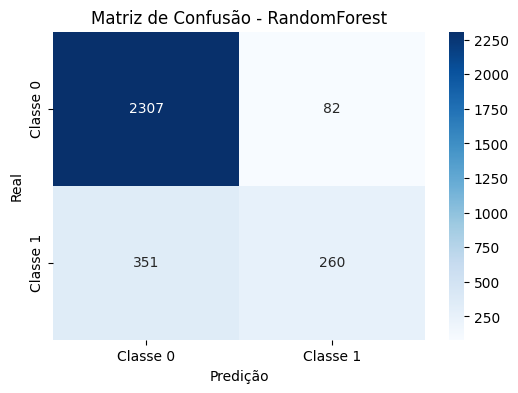

✨ Novo Recorde! RandomForest com recall_1: 0.4255

==================== SVM ====================
Relatório para SVM:
              precision    recall  f1-score   support

    Classe 0       0.85      0.98      0.91      2389
    Classe 1       0.78      0.35      0.48       611

    accuracy                           0.85      3000
   macro avg       0.82      0.66      0.70      3000
weighted avg       0.84      0.85      0.82      3000



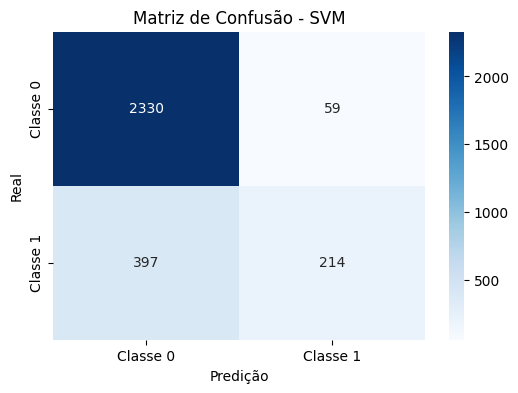


==================== KNN ====================
Relatório para KNN:
              precision    recall  f1-score   support

    Classe 0       0.83      0.95      0.89      2389
    Classe 1       0.58      0.25      0.35       611

    accuracy                           0.81      3000
   macro avg       0.71      0.60      0.62      3000
weighted avg       0.78      0.81      0.78      3000



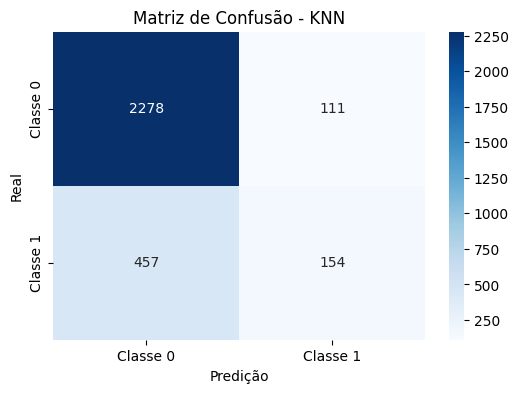


==================== DecisionTree ====================
Relatório para DecisionTree:
              precision    recall  f1-score   support

    Classe 0       0.87      0.86      0.86      2389
    Classe 1       0.47      0.49      0.48       611

    accuracy                           0.79      3000
   macro avg       0.67      0.67      0.67      3000
weighted avg       0.79      0.79      0.79      3000



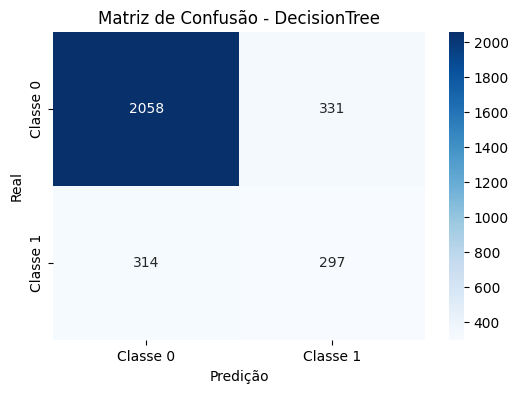

✨ Novo Recorde! DecisionTree com recall_1: 0.4861

==================== NeuralNetwork ====================
Relatório para NeuralNetwork:
              precision    recall  f1-score   support

    Classe 0       0.87      0.94      0.91      2389
    Classe 1       0.67      0.45      0.54       611

    accuracy                           0.84      3000
   macro avg       0.77      0.70      0.72      3000
weighted avg       0.83      0.84      0.83      3000



/home/dom-paje/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


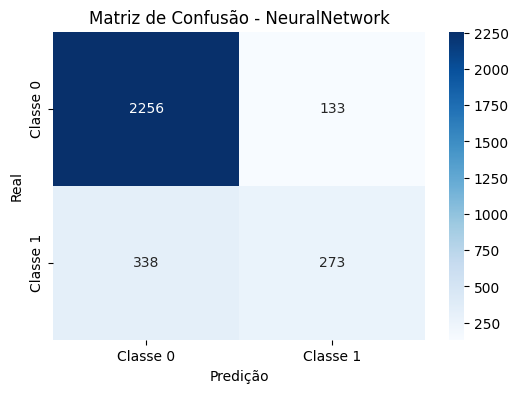


==================== XGBoost ====================
Relatório para XGBoost:
              precision    recall  f1-score   support

    Classe 0       0.87      0.94      0.91      2389
    Classe 1       0.67      0.46      0.54       611

    accuracy                           0.84      3000
   macro avg       0.77      0.70      0.72      3000
weighted avg       0.83      0.84      0.83      3000



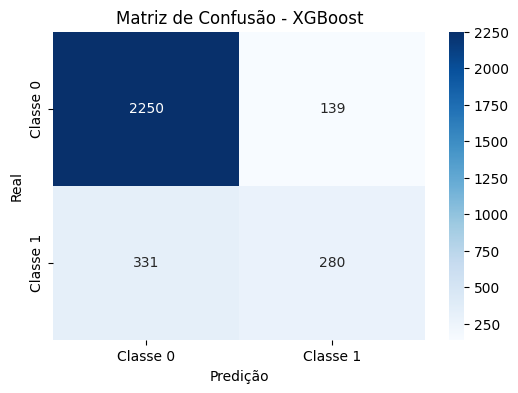


==================== AdaBoost ====================
Relatório para AdaBoost:
              precision    recall  f1-score   support

    Classe 0       0.87      0.96      0.91      2389
    Classe 1       0.72      0.43      0.53       611

    accuracy                           0.85      3000
   macro avg       0.79      0.69      0.72      3000
weighted avg       0.84      0.85      0.83      3000



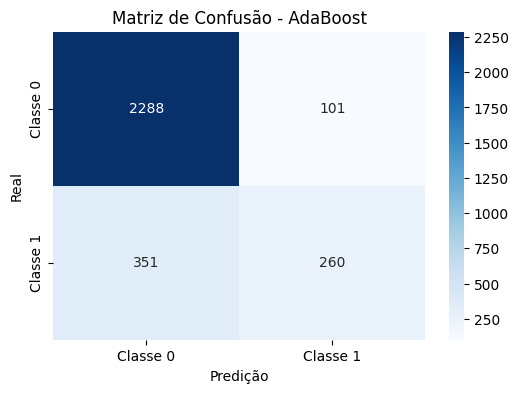


🏆 Resultados:


Modelo                       Config  Score (recall_1)  \
4        DecisionTree  Bal:None|PCA:False|Scl:True          0.486088   
6             XGBoost  Bal:None|PCA:False|Scl:True          0.458265   
5       NeuralNetwork  Bal:None|PCA:False|Scl:True          0.446809   
1        RandomForest  Bal:None|PCA:False|Scl:True          0.425532   
7            AdaBoost  Bal:None|PCA:False|Scl:True          0.425532   
2                 SVM  Bal:None|PCA:False|Scl:True          0.350245   
3                 KNN  Bal:None|PCA:False|Scl:True          0.252046   
0  LogisticRegression  Bal:None|PCA:False|Scl:True          0.247136   

   Recall (1)  Acurácia     Tempo Params  
4    0.486088  0.785000  0.050842    N/A  
6    0.458265  0.843333  4.589395    N/A  
5    0.446809  0.843000  8.327771    N/A  
1    0.425532  0.855667  1.003563    N/A  
7    0.425532  0.849333  0.301605    N/A  
2    0.350245  0.848000  0.793501    N/A  
3    0.252046  0.810667  0.000968    N/A  
0    0.247136  0.822667  0.007368    N/A


💾 Pipeline COMPLETA salva em: /home/dom-paje/llm-stack-containers/data/tf./resultados_treino/DecisionTree_PIPELINE_COMPLETO.pkl

>>> 🧪 Testando Cenário: Best + SMOTE
Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
Relatório para LogisticRegression:
              precision    recall  f1-score   support

    Classe 0       0.90      0.71      0.80      2389
    Classe 1       0.38      0.69      0.49       611

    accuracy                           0.71      3000
   macro avg       0.64      0.70      0.64      3000
weighted avg       0.79      0.71      0.73      3000



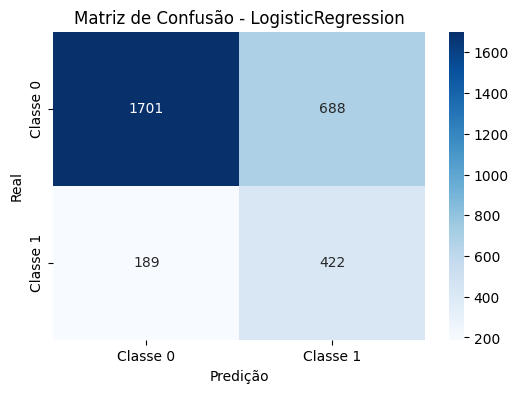

✨ Novo Recorde! LogisticRegression com recall_1: 0.6907

==================== RandomForest ====================
Relatório para RandomForest:
              precision    recall  f1-score   support

    Classe 0       0.89      0.92      0.90      2389
    Classe 1       0.64      0.55      0.59       611

    accuracy                           0.84      3000
   macro avg       0.76      0.73      0.75      3000
weighted avg       0.84      0.84      0.84      3000



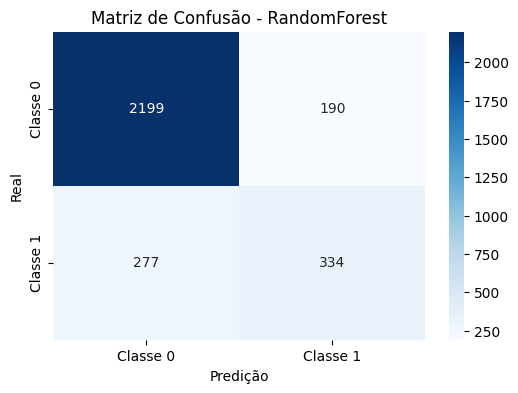


==================== SVM ====================
Relatório para SVM:
              precision    recall  f1-score   support

    Classe 0       0.90      0.84      0.87      2389
    Classe 1       0.49      0.62      0.55       611

    accuracy                           0.79      3000
   macro avg       0.69      0.73      0.71      3000
weighted avg       0.81      0.79      0.80      3000



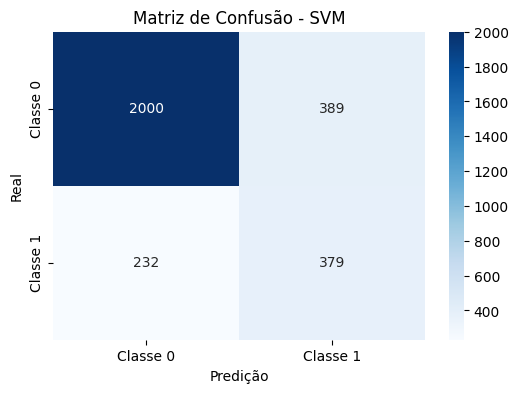


==================== KNN ====================
Relatório para KNN:
              precision    recall  f1-score   support

    Classe 0       0.88      0.73      0.80      2389
    Classe 1       0.36      0.60      0.45       611

    accuracy                           0.70      3000
   macro avg       0.62      0.66      0.62      3000
weighted avg       0.77      0.70      0.72      3000



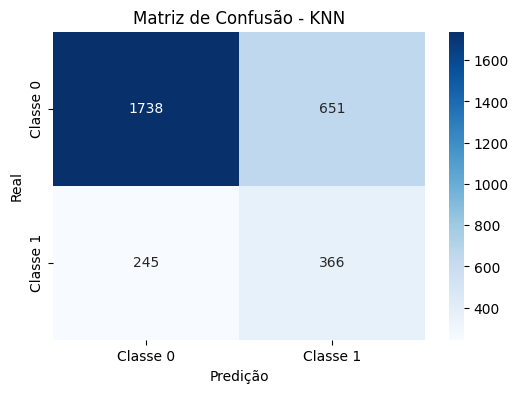


==================== DecisionTree ====================
Relatório para DecisionTree:
              precision    recall  f1-score   support

    Classe 0       0.87      0.83      0.85      2389
    Classe 1       0.43      0.50      0.46       611

    accuracy                           0.76      3000
   macro avg       0.65      0.66      0.65      3000
weighted avg       0.78      0.76      0.77      3000



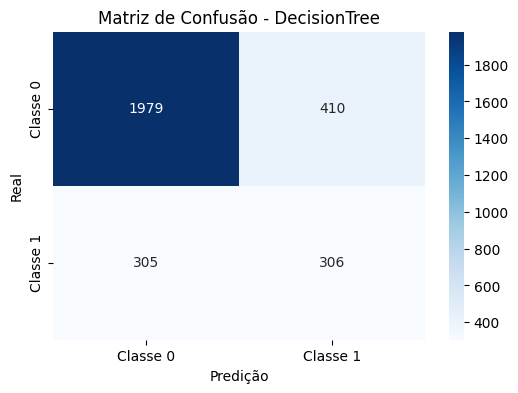


==================== NeuralNetwork ====================
Relatório para NeuralNetwork:
              precision    recall  f1-score   support

    Classe 0       0.88      0.86      0.87      2389
    Classe 1       0.50      0.55      0.52       611

    accuracy                           0.79      3000
   macro avg       0.69      0.71      0.70      3000
weighted avg       0.80      0.79      0.80      3000



/home/dom-paje/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


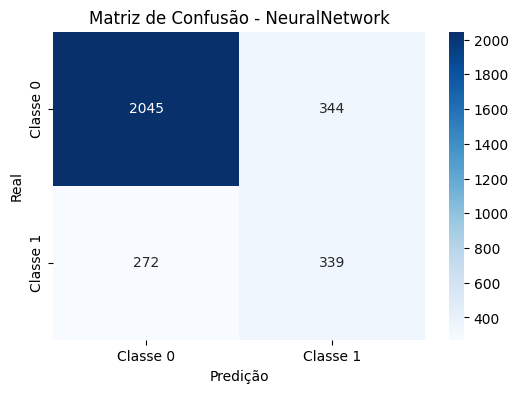


==================== XGBoost ====================
Relatório para XGBoost:
              precision    recall  f1-score   support

    Classe 0       0.88      0.93      0.90      2389
    Classe 1       0.65      0.49      0.56       611

    accuracy                           0.84      3000
   macro avg       0.76      0.71      0.73      3000
weighted avg       0.83      0.84      0.83      3000



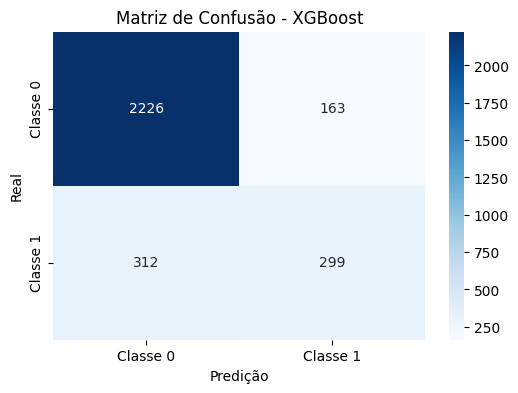


==================== AdaBoost ====================
Relatório para AdaBoost:
              precision    recall  f1-score   support

    Classe 0       0.89      0.86      0.88      2389
    Classe 1       0.53      0.60      0.56       611

    accuracy                           0.81      3000
   macro avg       0.71      0.73      0.72      3000
weighted avg       0.82      0.81      0.81      3000



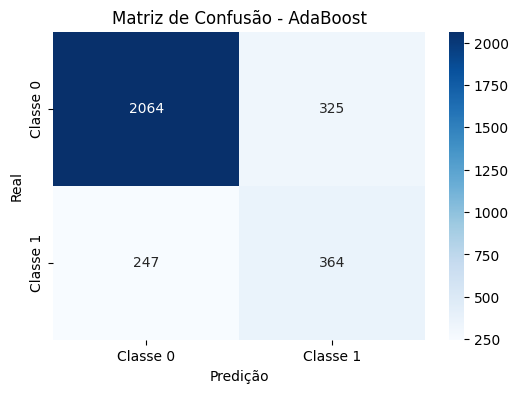


🏆 Resultados:


Modelo                        Config  Score (recall_1)  \
0  LogisticRegression  Bal:SMOTE|PCA:False|Scl:True          0.690671   
2                 SVM  Bal:SMOTE|PCA:False|Scl:True          0.620295   
3                 KNN  Bal:SMOTE|PCA:False|Scl:True          0.599018   
7            AdaBoost  Bal:SMOTE|PCA:False|Scl:True          0.595745   
5       NeuralNetwork  Bal:SMOTE|PCA:False|Scl:True          0.554828   
1        RandomForest  Bal:SMOTE|PCA:False|Scl:True          0.546645   
4        DecisionTree  Bal:SMOTE|PCA:False|Scl:True          0.500818   
6             XGBoost  Bal:SMOTE|PCA:False|Scl:True          0.489362   

   Recall (1)  Acurácia      Tempo Params  
0    0.690671  0.707667   0.009917    N/A  
2    0.620295  0.793000   2.582359    N/A  
3    0.599018  0.701333   0.001006    N/A  
7    0.595745  0.809333   0.598023    N/A  
5    0.554828  0.794667  11.917762    N/A  
1    0.546645  0.844333   2.015047    N/A  
4    0.500818  0.761667   0.103930    N/A  
6    0.489362  0.841667   9.182133    N/A


💾 Pipeline COMPLETA salva em: /home/dom-paje/llm-stack-containers/data/tf./resultados_treino/LogisticRegression_PIPELINE_COMPLETO.pkl

>>> 🧪 Testando Cenário: Best + Tomek
Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
Relatório para LogisticRegression:
              precision    recall  f1-score   support

    Classe 0       0.84      0.95      0.89      2389
    Classe 1       0.59      0.28      0.38       611

    accuracy                           0.81      3000
   macro avg       0.72      0.62      0.64      3000
weighted avg       0.79      0.81      0.79      3000



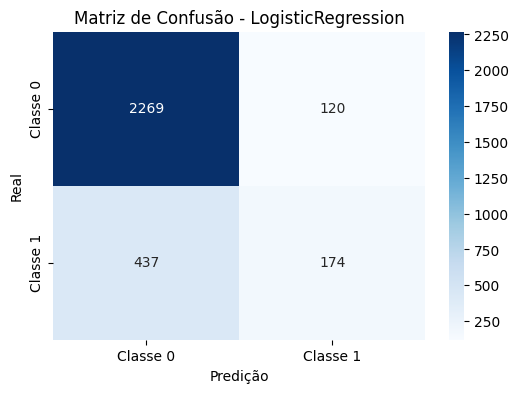

✨ Novo Recorde! LogisticRegression com recall_1: 0.2848

==================== RandomForest ====================
Relatório para RandomForest:
              precision    recall  f1-score   support

    Classe 0       0.87      0.95      0.91      2389
    Classe 1       0.72      0.46      0.56       611

    accuracy                           0.85      3000
   macro avg       0.80      0.71      0.74      3000
weighted avg       0.84      0.85      0.84      3000



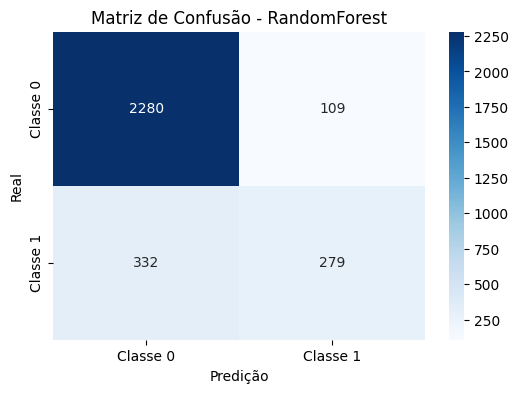

✨ Novo Recorde! RandomForest com recall_1: 0.4566

==================== SVM ====================
Relatório para SVM:
              precision    recall  f1-score   support

    Classe 0       0.87      0.96      0.91      2389
    Classe 1       0.74      0.42      0.53       611

    accuracy                           0.85      3000
   macro avg       0.80      0.69      0.72      3000
weighted avg       0.84      0.85      0.83      3000



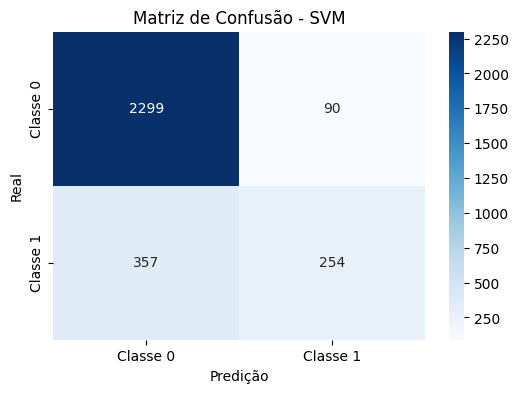


==================== KNN ====================
Relatório para KNN:
              precision    recall  f1-score   support

    Classe 0       0.84      0.94      0.89      2389
    Classe 1       0.56      0.31      0.40       611

    accuracy                           0.81      3000
   macro avg       0.70      0.62      0.64      3000
weighted avg       0.78      0.81      0.79      3000



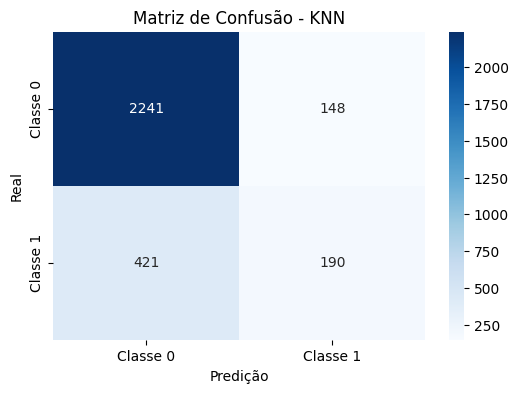


==================== DecisionTree ====================
Relatório para DecisionTree:
              precision    recall  f1-score   support

    Classe 0       0.88      0.85      0.86      2389
    Classe 1       0.47      0.53      0.50       611

    accuracy                           0.78      3000
   macro avg       0.68      0.69      0.68      3000
weighted avg       0.79      0.78      0.79      3000



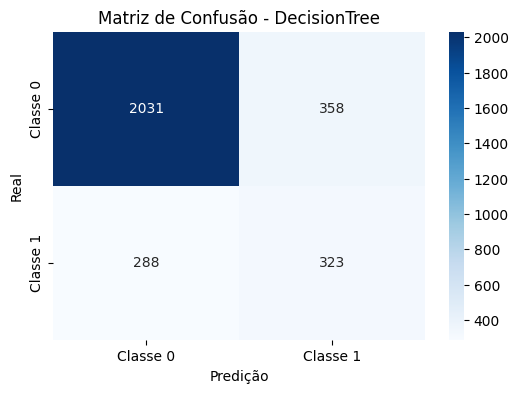

✨ Novo Recorde! DecisionTree com recall_1: 0.5286

==================== NeuralNetwork ====================
Relatório para NeuralNetwork:
              precision    recall  f1-score   support

    Classe 0       0.87      0.94      0.90      2389
    Classe 1       0.66      0.47      0.55       611

    accuracy                           0.84      3000
   macro avg       0.76      0.70      0.73      3000
weighted avg       0.83      0.84      0.83      3000



/home/dom-paje/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


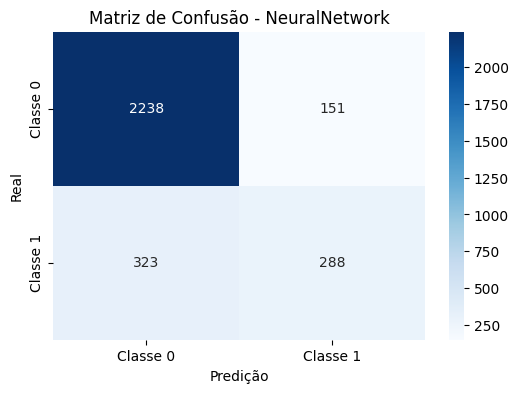


==================== XGBoost ====================
Relatório para XGBoost:
              precision    recall  f1-score   support

    Classe 0       0.87      0.92      0.90      2389
    Classe 1       0.62      0.48      0.54       611

    accuracy                           0.83      3000
   macro avg       0.75      0.70      0.72      3000
weighted avg       0.82      0.83      0.83      3000



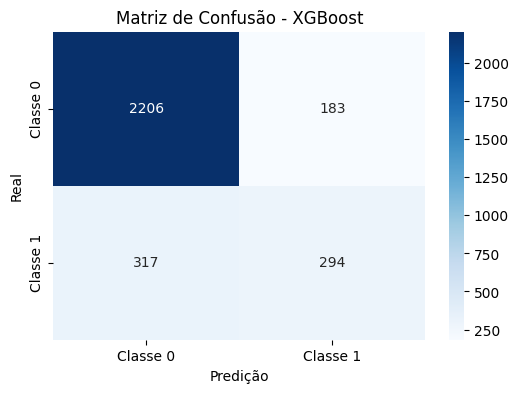


==================== AdaBoost ====================
Relatório para AdaBoost:
              precision    recall  f1-score   support

    Classe 0       0.87      0.94      0.91      2389
    Classe 1       0.67      0.46      0.54       611

    accuracy                           0.84      3000
   macro avg       0.77      0.70      0.72      3000
weighted avg       0.83      0.84      0.83      3000



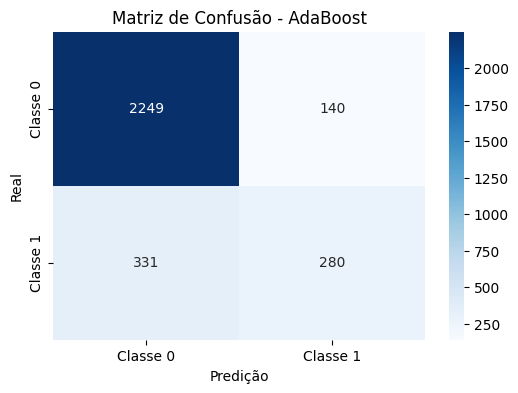


🏆 Resultados:


Modelo                             Config  Score (recall_1)  \
4        DecisionTree  Bal:TomekLinks|PCA:False|Scl:True          0.528642   
6             XGBoost  Bal:TomekLinks|PCA:False|Scl:True          0.481178   
5       NeuralNetwork  Bal:TomekLinks|PCA:False|Scl:True          0.471358   
7            AdaBoost  Bal:TomekLinks|PCA:False|Scl:True          0.458265   
1        RandomForest  Bal:TomekLinks|PCA:False|Scl:True          0.456628   
2                 SVM  Bal:TomekLinks|PCA:False|Scl:True          0.415712   
3                 KNN  Bal:TomekLinks|PCA:False|Scl:True          0.310966   
0  LogisticRegression  Bal:TomekLinks|PCA:False|Scl:True          0.284779   

   Recall (1)  Acurácia      Tempo Params  
4    0.528642  0.784667   0.048386    N/A  
6    0.481178  0.833333  10.062610    N/A  
5    0.471358  0.842000   6.487324    N/A  
7    0.458265  0.843000   0.291064    N/A  
1    0.456628  0.853000   0.943259    N/A  
2    0.415712  0.851000   0.733360    N/A  
3    0.310966  0.810333   0.000861    N/A  
0    0.284779  0.814333   0.006588    N/A


💾 Pipeline COMPLETA salva em: /home/dom-paje/llm-stack-containers/data/tf./resultados_treino/DecisionTree_PIPELINE_COMPLETO.pkl

>>> 🧪 Testando Cenário: Best + PCA + SMOTE
Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
Relatório para LogisticRegression:
              precision    recall  f1-score   support

    Classe 0       0.90      0.71      0.79      2389
    Classe 1       0.38      0.69      0.49       611

    accuracy                           0.71      3000
   macro avg       0.64      0.70      0.64      3000
weighted avg       0.79      0.71      0.73      3000



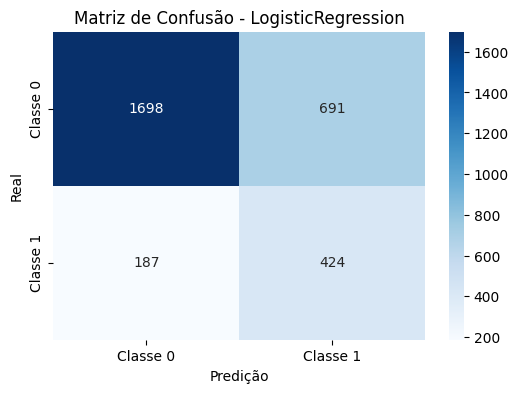

✨ Novo Recorde! LogisticRegression com recall_1: 0.6939

==================== RandomForest ====================
Relatório para RandomForest:
              precision    recall  f1-score   support

    Classe 0       0.89      0.88      0.88      2389
    Classe 1       0.54      0.56      0.55       611

    accuracy                           0.81      3000
   macro avg       0.71      0.72      0.72      3000
weighted avg       0.82      0.81      0.81      3000



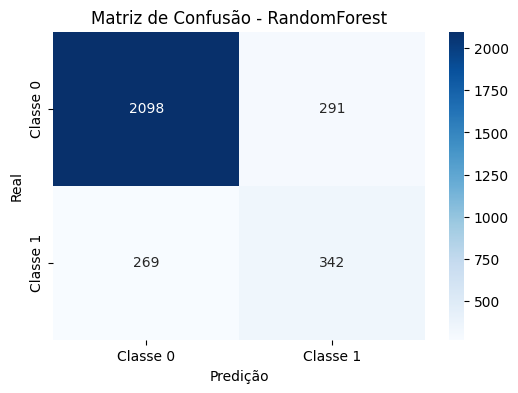


==================== SVM ====================
Relatório para SVM:
              precision    recall  f1-score   support

    Classe 0       0.90      0.84      0.86      2389
    Classe 1       0.49      0.62      0.55       611

    accuracy                           0.79      3000
   macro avg       0.69      0.73      0.71      3000
weighted avg       0.81      0.79      0.80      3000



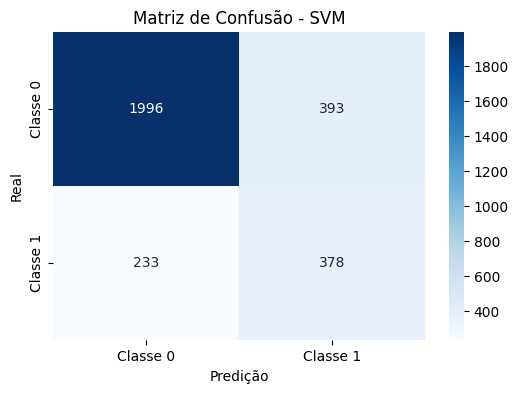


==================== KNN ====================
Relatório para KNN:
              precision    recall  f1-score   support

    Classe 0       0.87      0.73      0.80      2389
    Classe 1       0.36      0.59      0.45       611

    accuracy                           0.70      3000
   macro avg       0.62      0.66      0.62      3000
weighted avg       0.77      0.70      0.73      3000



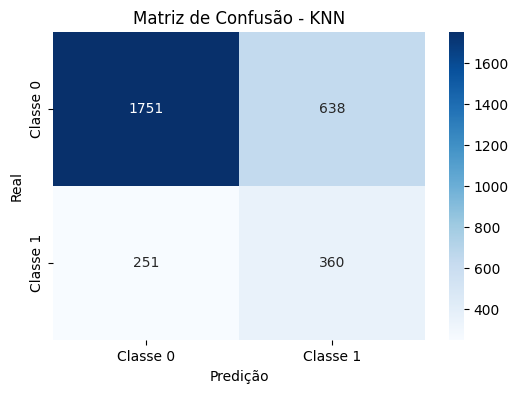


==================== DecisionTree ====================
Relatório para DecisionTree:
              precision    recall  f1-score   support

    Classe 0       0.86      0.78      0.82      2389
    Classe 1       0.37      0.51      0.43       611

    accuracy                           0.73      3000
   macro avg       0.62      0.65      0.63      3000
weighted avg       0.76      0.73      0.74      3000



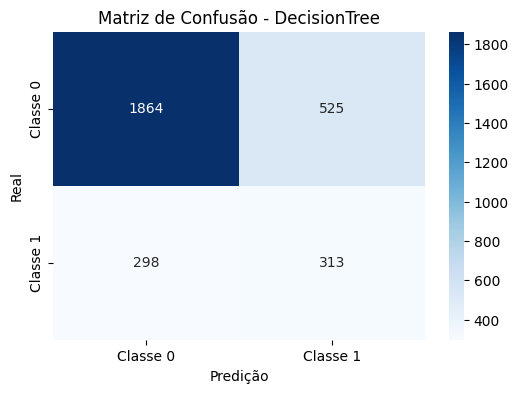


==================== NeuralNetwork ====================
Relatório para NeuralNetwork:
              precision    recall  f1-score   support

    Classe 0       0.88      0.84      0.86      2389
    Classe 1       0.48      0.57      0.52       611

    accuracy                           0.79      3000
   macro avg       0.68      0.71      0.69      3000
weighted avg       0.80      0.79      0.79      3000



/home/dom-paje/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


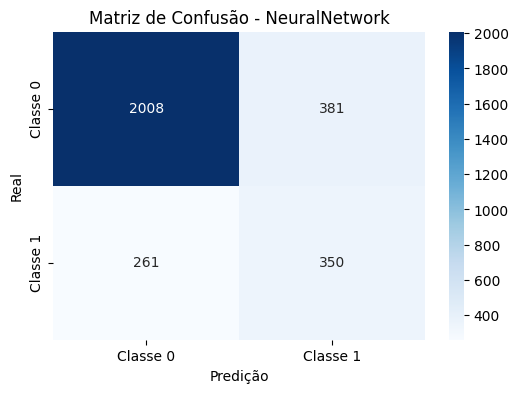


==================== XGBoost ====================
Relatório para XGBoost:
              precision    recall  f1-score   support

    Classe 0       0.89      0.86      0.87      2389
    Classe 1       0.50      0.57      0.53       611

    accuracy                           0.80      3000
   macro avg       0.69      0.71      0.70      3000
weighted avg       0.81      0.80      0.80      3000



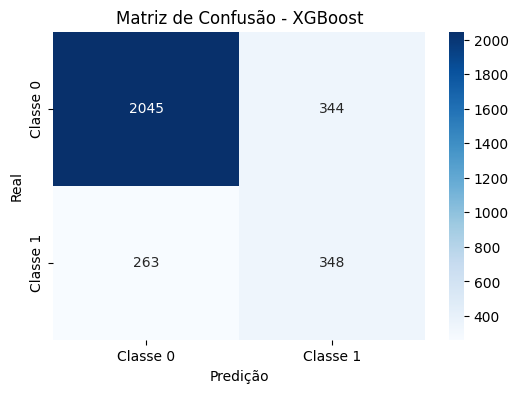


==================== AdaBoost ====================
Relatório para AdaBoost:
              precision    recall  f1-score   support

    Classe 0       0.90      0.77      0.83      2389
    Classe 1       0.43      0.67      0.52       611

    accuracy                           0.75      3000
   macro avg       0.66      0.72      0.68      3000
weighted avg       0.81      0.75      0.77      3000



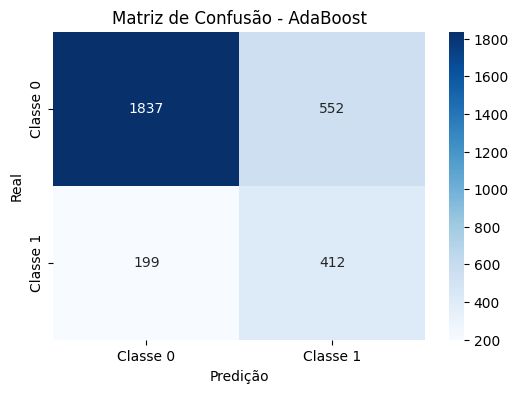


🏆 Resultados:


Modelo                       Config  Score (recall_1)  \
0  LogisticRegression  Bal:SMOTE|PCA:True|Scl:True          0.693944   
7            AdaBoost  Bal:SMOTE|PCA:True|Scl:True          0.674304   
2                 SVM  Bal:SMOTE|PCA:True|Scl:True          0.618658   
3                 KNN  Bal:SMOTE|PCA:True|Scl:True          0.589198   
5       NeuralNetwork  Bal:SMOTE|PCA:True|Scl:True          0.572831   
6             XGBoost  Bal:SMOTE|PCA:True|Scl:True          0.569558   
1        RandomForest  Bal:SMOTE|PCA:True|Scl:True          0.559738   
4        DecisionTree  Bal:SMOTE|PCA:True|Scl:True          0.512275   

   Recall (1)  Acurácia      Tempo Params  
0    0.693944  0.707333   0.011682    N/A  
7    0.674304  0.749667   1.495293    N/A  
2    0.618658  0.791333   2.760926    N/A  
3    0.589198  0.703667   0.017209    N/A  
5    0.572831  0.786000  12.991444    N/A  
6    0.569558  0.797667   7.922512    N/A  
1    0.559738  0.813333   4.053249    N/A  
4    0.512275  0.725667   0.330178    N/A


💾 Pipeline COMPLETA salva em: /home/dom-paje/llm-stack-containers/data/tf./resultados_treino/LogisticRegression_PIPELINE_COMPLETO.pkl

>>> 🧪 Testando Cenário: Best + PCA + Tomek
Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
Relatório para LogisticRegression:
              precision    recall  f1-score   support

    Classe 0       0.84      0.95      0.89      2389
    Classe 1       0.59      0.28      0.38       611

    accuracy                           0.81      3000
   macro avg       0.71      0.61      0.63      3000
weighted avg       0.79      0.81      0.79      3000



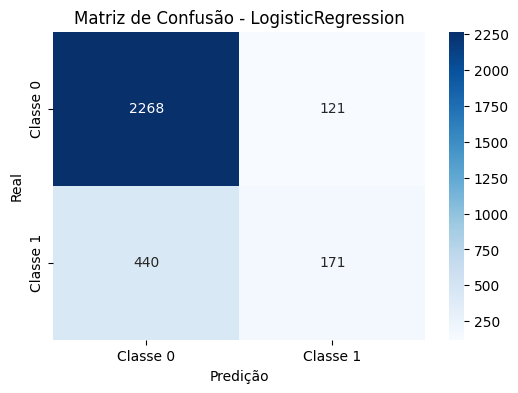

✨ Novo Recorde! LogisticRegression com recall_1: 0.2799

==================== RandomForest ====================
Relatório para RandomForest:
              precision    recall  f1-score   support

    Classe 0       0.86      0.95      0.90      2389
    Classe 1       0.68      0.40      0.51       611

    accuracy                           0.84      3000
   macro avg       0.77      0.68      0.71      3000
weighted avg       0.83      0.84      0.82      3000



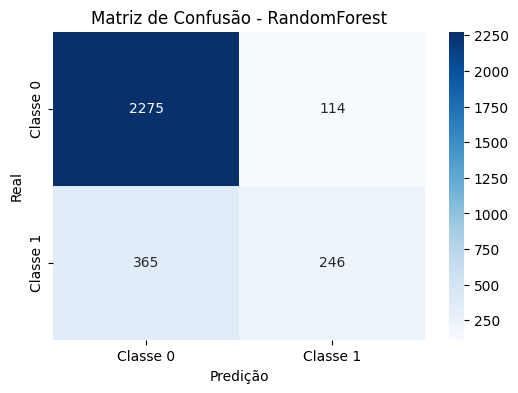

✨ Novo Recorde! RandomForest com recall_1: 0.4026

==================== SVM ====================
Relatório para SVM:
              precision    recall  f1-score   support

    Classe 0       0.85      0.96      0.91      2389
    Classe 1       0.72      0.35      0.47       611

    accuracy                           0.84      3000
   macro avg       0.79      0.66      0.69      3000
weighted avg       0.83      0.84      0.82      3000



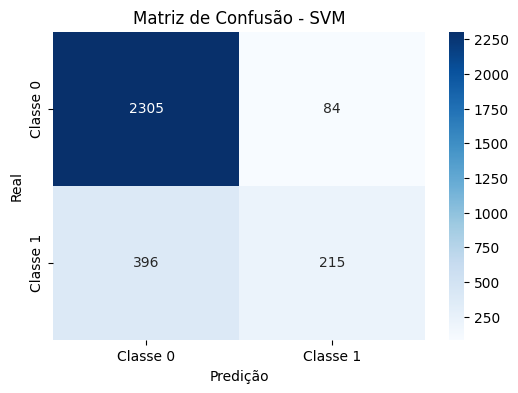


==================== KNN ====================
Relatório para KNN:
              precision    recall  f1-score   support

    Classe 0       0.84      0.93      0.88      2389
    Classe 1       0.53      0.30      0.38       611

    accuracy                           0.80      3000
   macro avg       0.69      0.62      0.63      3000
weighted avg       0.78      0.80      0.78      3000



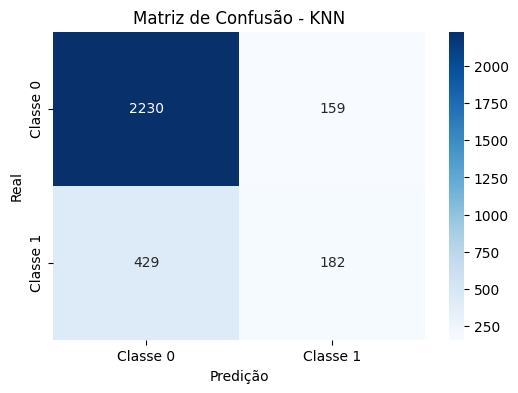


==================== DecisionTree ====================
Relatório para DecisionTree:
              precision    recall  f1-score   support

    Classe 0       0.86      0.83      0.84      2389
    Classe 1       0.41      0.45      0.43       611

    accuracy                           0.76      3000
   macro avg       0.63      0.64      0.64      3000
weighted avg       0.76      0.76      0.76      3000



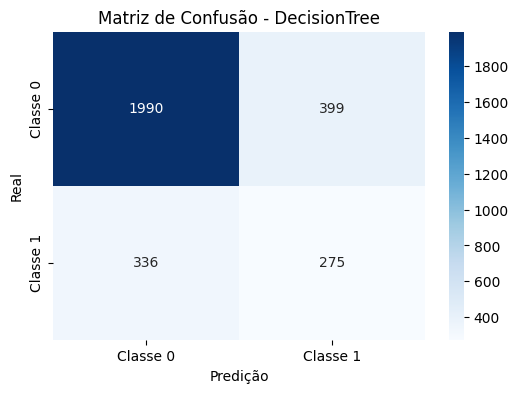

✨ Novo Recorde! DecisionTree com recall_1: 0.4501

==================== NeuralNetwork ====================
Relatório para NeuralNetwork:
              precision    recall  f1-score   support

    Classe 0       0.87      0.93      0.90      2389
    Classe 1       0.64      0.47      0.54       611

    accuracy                           0.84      3000
   macro avg       0.75      0.70      0.72      3000
weighted avg       0.82      0.84      0.83      3000



/home/dom-paje/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


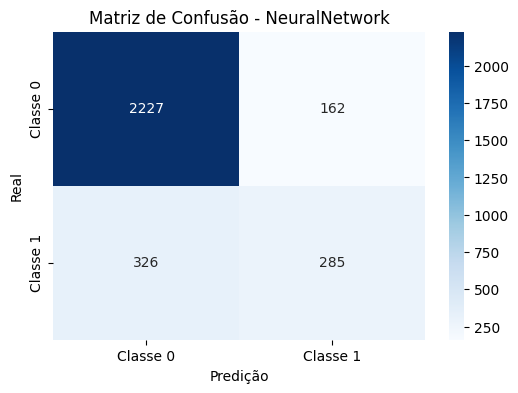

✨ Novo Recorde! NeuralNetwork com recall_1: 0.4664

==================== XGBoost ====================
Relatório para XGBoost:
              precision    recall  f1-score   support

    Classe 0       0.87      0.93      0.89      2389
    Classe 1       0.60      0.44      0.51       611

    accuracy                           0.83      3000
   macro avg       0.73      0.68      0.70      3000
weighted avg       0.81      0.83      0.82      3000



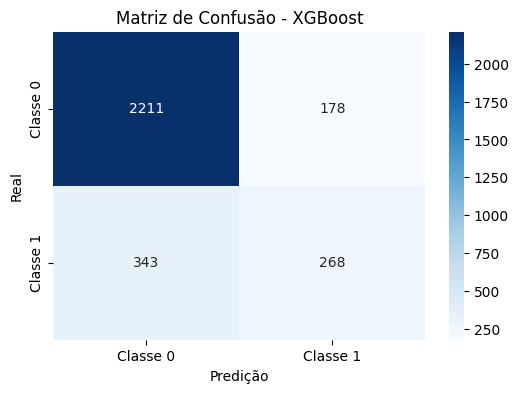


==================== AdaBoost ====================
Relatório para AdaBoost:
              precision    recall  f1-score   support

    Classe 0       0.86      0.93      0.90      2389
    Classe 1       0.62      0.42      0.50       611

    accuracy                           0.83      3000
   macro avg       0.74      0.68      0.70      3000
weighted avg       0.81      0.83      0.82      3000



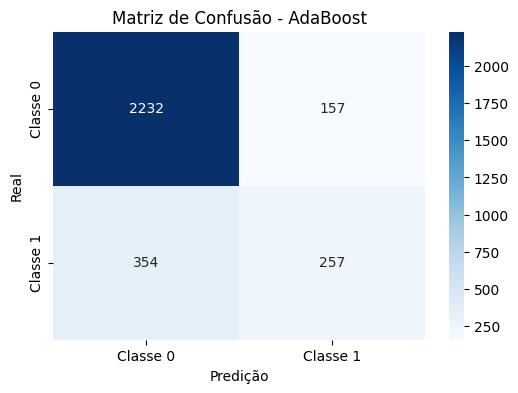


🏆 Resultados:


Modelo                            Config  Score (recall_1)  \
5       NeuralNetwork  Bal:TomekLinks|PCA:True|Scl:True          0.466448   
4        DecisionTree  Bal:TomekLinks|PCA:True|Scl:True          0.450082   
6             XGBoost  Bal:TomekLinks|PCA:True|Scl:True          0.438625   
7            AdaBoost  Bal:TomekLinks|PCA:True|Scl:True          0.420622   
1        RandomForest  Bal:TomekLinks|PCA:True|Scl:True          0.402619   
2                 SVM  Bal:TomekLinks|PCA:True|Scl:True          0.351882   
3                 KNN  Bal:TomekLinks|PCA:True|Scl:True          0.297872   
0  LogisticRegression  Bal:TomekLinks|PCA:True|Scl:True          0.279869   

   Recall (1)  Acurácia     Tempo Params  
5    0.466448  0.837333  6.858880    N/A  
4    0.450082  0.755000  0.226694    N/A  
6    0.438625  0.826333  6.383625    N/A  
7    0.420622  0.829667  0.830537    N/A  
1    0.402619  0.840333  2.699922    N/A  
2    0.351882  0.840000  0.789258    N/A  
3    0.297872  0.804000  0.009475    N/A  
0    0.279869  0.813000  0.018528    N/A


💾 Pipeline COMPLETA salva em: /home/dom-paje/llm-stack-containers/data/tf./resultados_treino/NeuralNetwork_PIPELINE_COMPLETO.pkl

🏁 Todos os cenários finalizados!

🏆 Ranking Final dos Cenários:
                  Cenário      Modelo Campeão  Recall_1 Balanceamento    PCA  \
8      Grid + PCA + SMOTE            AdaBoost  0.700491         SMOTE   True   
3   Default + PCA + SMOTE  LogisticRegression  0.693944         SMOTE   True   
13     Best + PCA + SMOTE  LogisticRegression  0.693944         SMOTE   True   
1         Default + SMOTE  LogisticRegression  0.690671         SMOTE  False   
6            Grid + SMOTE  LogisticRegression  0.690671         SMOTE  False   
11           Best + SMOTE  LogisticRegression  0.690671         SMOTE  False   
2         Default + Tomek        DecisionTree  0.538462    TomekLinks  False   
12           Best + Tomek        DecisionTree  0.528642    TomekLinks  False   
7            Grid + Tomek       NeuralNetwork  0.510638    TomekLinks  False   
5    

In [ ]:
# Lista para armazenar o "Campeão" de cada cenário
resultados_scenarios = []

# Definição dos parâmetros para cada cenário
# Nota: 'balanceamento' deve corresponder exatamente ao if da classe ("SMOTE", "TomekLinks")
configs = [
    # --- DEFAULT (5) ---
    {"name": "Default",                     "bal": None,           "pca": False, "tipo": "default"},
    {"name": "Default + SMOTE",             "bal": "SMOTE",        "pca": False, "tipo": "default"},
    {"name": "Default + Tomek",             "bal": "TomekLinks",   "pca": False, "tipo": "default"},
    {"name": "Default + PCA + SMOTE",       "bal": "SMOTE",        "pca": True,  "tipo": "default"},
    {"name": "Default + PCA + Tomek",       "bal": "TomekLinks",   "pca": True,  "tipo": "default"},

    # --- GRID (5) ---
    {"name": "Grid",                        "bal": None,           "pca": False, "tipo": "grid"},
    {"name": "Grid + SMOTE",                "bal": "SMOTE",        "pca": False, "tipo": "grid"},
    {"name": "Grid + Tomek",                "bal": "TomekLinks",   "pca": False, "tipo": "grid"},
    {"name": "Grid + PCA + SMOTE",          "bal": "SMOTE",        "pca": True,  "tipo": "grid"},
    {"name": "Grid + PCA + Tomek",          "bal": "TomekLinks",   "pca": True,  "tipo": "grid"},

    # --- BEST PARAMS (5) ---
    {"name": "Best",                        "bal": None,           "pca": False, "tipo": "best"},
    {"name": "Best + SMOTE",                "bal": "SMOTE",        "pca": False, "tipo": "best"},
    {"name": "Best + Tomek",                "bal": "TomekLinks",   "pca": False, "tipo": "best"},
    {"name": "Best + PCA + SMOTE",          "bal": "SMOTE",        "pca": True,  "tipo": "best"},
    {"name": "Best + PCA + Tomek",          "bal": "TomekLinks",   "pca": True,  "tipo": "best"},
]

os.makedirs("modelos_campeoes", exist_ok=True)

# Lista onde salvamos os campeões
resultados_scenarios = []

print(f"🚀 Iniciando bateria de testes com {len(configs)} cenários...\n")

for config in configs:
    cenario_nome = config["name"]
    print(f"\n>>> 🧪 Testando Cenário: {cenario_nome}")

    # Executa o treinamento segundo os parâmetros do cenário
    pipeline_cenario = trainer.train(
        metric_optimize='recall_1',
        balanceamento=config["bal"],
        usar_pca=config["pca"],
        tipo_parametros=config["tipo"],
        salvar_parametros=True
    )

    # Recupera informações do melhor modelo interno da classe Trainer
    info = trainer.best_model_info

    resultados_scenarios.append({
        "Cenário": cenario_nome,
        "Modelo Campeão": info["name"],
        "Recall_1": info["score"],
        "Balanceamento": config["bal"],
        "PCA": config["pca"],
        "Tipo Param": config["tipo"],
        "Pipeline": pipeline_cenario
    })

    # 🔥 Opcional: salvar cada pipeline campeão
    caminho = f"modelos_campeoes/{info['name']}_{cenario_nome.replace(' ', '_')}.pkl"
    joblib.dump(pipeline_cenario, caminho)

print("\n🏁 Todos os cenários finalizados!")

# ---- Tabela Comparativa Final ----
df_resultados = pd.DataFrame(resultados_scenarios)
df_resultados = df_resultados.sort_values(by="Recall_1", ascending=False)

print("\n🏆 Ranking Final dos Cenários:")
print(df_resultados[["Cenário", "Modelo Campeão", "Recall_1", "Balanceamento", "PCA", "Tipo Param"]])


#### Ranking de modelos

In [ ]:
try:
  from IPython.display import display
  display(df_resultados[["Cenário", "Modelo Campeão", "Recall_1",  "Balanceamento", "PCA", "Tipo Param"]])
except ImportError:
  print(df_resultados)

Cenário      Modelo Campeão  Recall_1 Balanceamento    PCA  \
8      Grid + PCA + SMOTE            AdaBoost  0.700491         SMOTE   True   
3   Default + PCA + SMOTE  LogisticRegression  0.693944         SMOTE   True   
13     Best + PCA + SMOTE  LogisticRegression  0.693944         SMOTE   True   
1         Default + SMOTE  LogisticRegression  0.690671         SMOTE  False   
6            Grid + SMOTE  LogisticRegression  0.690671         SMOTE  False   
11           Best + SMOTE  LogisticRegression  0.690671         SMOTE  False   
2         Default + Tomek        DecisionTree  0.538462    TomekLinks  False   
12           Best + Tomek        DecisionTree  0.528642    TomekLinks  False   
7            Grid + Tomek       NeuralNetwork  0.510638    TomekLinks  False   
5                    Grid       NeuralNetwork  0.507365          None  False   
10                   Best        DecisionTree  0.486088          None  False   
9      Grid + PCA + Tomek       NeuralNetwork  0.484452    TomekLinks   True   
0                 Default        DecisionTree  0.482815          None  False   
4   Default + PCA + Tomek       NeuralNetwork  0.477905    TomekLinks   True   
14     Best + PCA + Tomek       NeuralNetwork  0.466448    TomekLinks   True   

   Tipo Param  
8        grid  
3     default  
13       best  
1     default  
6        grid  
11       best  
2     default  
12       best  
7        grid  
5        grid  
10       best  
9        grid  
0     default  
4     default  
14       best

#### Aplicando testes com Threshold


In [ ]:
import numpy as np
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score

# 1. Carrega o pipeline completo
model_pipeline = joblib.load("/home/dom-paje/llm-stack-containers/data/tf./resultados_treino/AdaBoost_PIPELINE_COMPLETO.pkl")
# model_pipeline = joblib.load("/home/dom-paje/llm-stack-containers/data/tf./resultados_treino/LogisticRegression_PIPELINE_COMPLETO.pkl")


# 2. Gera as probabilidades (A pipeline trata o X_test internamente!)
# Pegamos a coluna [:, 1] que é a probabilidade da classe Positiva (1)
y_probs = model_pipeline.predict_proba(X_test)[:, 1]

print(f"{'Threshold':<10} | {'Recall (1)':<10} | {'Precision':<10} | {'F1-Score':<10} | {'Acurácia':<10}")
print("-" * 65)

# 3. Loop para testar cortes de 0.1 até 0.9
thresholds = np.arange(0.1, 0.95, 0.05)

for t in thresholds:
    # Converte probabilidade em 0 ou 1 baseado no threshold 't'
    preds_t = (y_probs >= t).astype(int)

    rec = recall_score(y_test, preds_t, pos_label=1)
    prec = precision_score(y_test, preds_t, zero_division=0)
    f1 = f1_score(y_test, preds_t)
    acc = accuracy_score(y_test, preds_t)

    print(f"{t:.2f}       | {rec:.4f}     | {prec:.4f}    | {f1:.4f}     | {acc:.4f}")

Threshold  | Recall (1) | Precision  | F1-Score   | Acurácia  
-----------------------------------------------------------------
0.10       | 1.0000     | 0.2037    | 0.3384     | 0.2037
0.15       | 1.0000     | 0.2037    | 0.3384     | 0.2037
0.20       | 1.0000     | 0.2037    | 0.3384     | 0.2037
0.25       | 1.0000     | 0.2037    | 0.3384     | 0.2037
0.30       | 1.0000     | 0.2037    | 0.3384     | 0.2037
0.35       | 1.0000     | 0.2037    | 0.3384     | 0.2037
0.40       | 1.0000     | 0.2037    | 0.3384     | 0.2037
0.45       | 1.0000     | 0.2037    | 0.3385     | 0.2040
0.50       | 0.7005     | 0.4399    | 0.5404     | 0.7573
0.55       | 0.0180     | 1.0000    | 0.0354     | 0.8000
0.60       | 0.0000     | 0.0000    | 0.0000     | 0.7963
0.65       | 0.0000     | 0.0000    | 0.0000     | 0.7963
0.70       | 0.0000     | 0.0000    | 0.0000     | 0.7963
0.75       | 0.0000     | 0.0000    | 0.0000     | 0.7963
0.80       | 0.0000     | 0.0000    | 0.0000     | 0.7963
0

In [ ]:
import numpy as np
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix

thresholds_zoom = np.arange(0.35, 0.55, 0.01)

# Cabeçalho expandido
print(f"{'Limiar':<7} | {'Recall(1)':<9} | {'Espec(0)':<9} | {'Prec':<9} | {'F1':<9} | {'Acurácia':<9} | {'TP':<4} {'FP':<4} {'TN':<4} {'FN':<4}")
print("-" * 110)

# Gera probabilidades
y_probs = model_pipeline.predict_proba(X_test)[:, 1]

for t in thresholds_zoom:
    preds_t = (y_probs >= t).astype(int)

    # Métricas Clássicas
    rec = recall_score(y_test, preds_t, pos_label=1)
    prec = precision_score(y_test, preds_t, zero_division=0)
    f1 = f1_score(y_test, preds_t)
    acc = accuracy_score(y_test, preds_t)

    # Extraindo a Matriz de Confusão para ver tudo
    # tn=Zeros Reais Acertados, fp=Zeros Reais Errados
    # fn=Uns Reais Errados, tp=Uns Reais Acertados
    tn, fp, fn, tp = confusion_matrix(y_test, preds_t).ravel()

    # Especificidade: A "Acurácia" da Classe 0 (Quantos não-Churn eu acertei)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print(f"{t:.3f}   | {rec:.4f}    | {specificity:.4f}    | {prec:.4f}    | {f1:.4f}    | {acc:.4f}    | {tp:<4} {fp:<4} {tn:<4} {fn:<4}")

Limiar  | Recall(1) | Espec(0)  | Prec      | F1        | Acurácia  | TP   FP   TN   FN  
--------------------------------------------------------------------------------------------------------------
0.350   | 1.0000    | 0.0000    | 0.2037    | 0.3384    | 0.2037    | 611  2389 0    0   
0.360   | 1.0000    | 0.0000    | 0.2037    | 0.3384    | 0.2037    | 611  2389 0    0   
0.370   | 1.0000    | 0.0000    | 0.2037    | 0.3384    | 0.2037    | 611  2389 0    0   
0.380   | 1.0000    | 0.0000    | 0.2037    | 0.3384    | 0.2037    | 611  2389 0    0   
0.390   | 1.0000    | 0.0000    | 0.2037    | 0.3384    | 0.2037    | 611  2389 0    0   
0.400   | 1.0000    | 0.0000    | 0.2037    | 0.3384    | 0.2037    | 611  2389 0    0   
0.410   | 1.0000    | 0.0000    | 0.2037    | 0.3384    | 0.2037    | 611  2389 0    0   
0.420   | 1.0000    | 0.0000    | 0.2037    | 0.3384    | 0.2037    | 611  2389 0    0   
0.430   | 1.0000    | 0.0000    | 0.2037    | 0.3384    | 0.2037    | 611  2389

🔄 Reconstruindo pesos originais a partir do PCA...


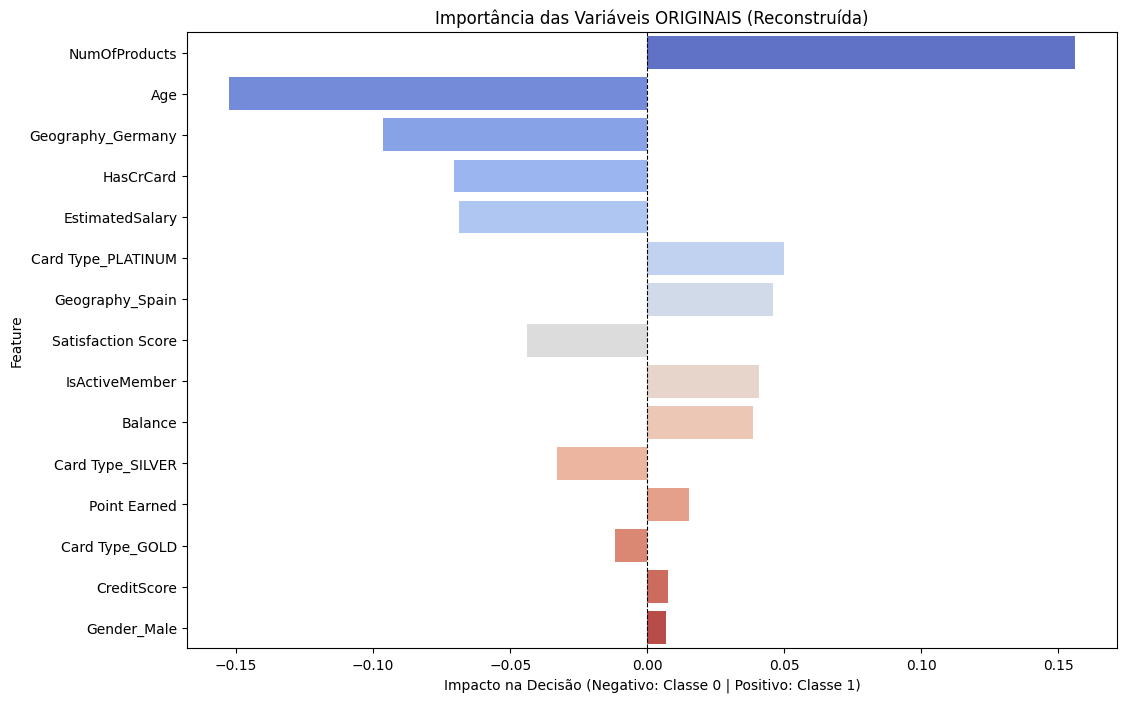

              Feature  Importance
4       NumOfProducts    0.155984
1                 Age   -0.152479
10  Geography_Germany   -0.096248
5           HasCrCard   -0.070598
7     EstimatedSalary   -0.068691


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Acessar os passos do Pipeline
step_pca = model_pipeline.named_steps.get('pca')   # Tenta pegar o PCA
step_model = model_pipeline.named_steps['model']   # Pega o modelo

# 2. Obter os coeficientes do modelo (Pesos dos Componentes)
if hasattr(step_model, 'coef_'):
    # Para Regressão Logística (formato [[w1, w2...]])
    model_weights = step_model.coef_[0]
elif hasattr(step_model, 'feature_importances_'):
    # Para Árvores (mas atenção: árvores + PCA é difícil de reverter perfeitamente assim)
    model_weights = step_model.feature_importances_
else:
    raise ValueError("Modelo sem coeficientes ou importâncias acessíveis.")

# 3. Engenharia Reversa (Back-projection)
# Se existe PCA, precisamos multiplicar os pesos pelos componentes
if step_pca is not None:
    print("🔄 Reconstruindo pesos originais a partir do PCA...")
    # Matriz de Componentes (n_components, n_features_originais)
    pca_components = step_pca.components_

    # Produto escalar: Pesos_Model * Componentes_PCA = Pesos_Originais
    # (n_comp) * (n_comp, n_orig) -> (n_orig)
    original_importances = np.dot(model_weights, pca_components)
else:
    print("✅ Sem PCA, usando pesos diretos.")
    original_importances = model_weights

# 4. Criar DataFrame com NOMES ORIGINAIS
# Agora 'original_importances' tem o mesmo tamanho de 'X_train.columns'
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,  # Aqui forçamos os nomes originais
    'Importance': original_importances,
    'Abs_Importance': np.abs(original_importances) # Para ordenar
}).sort_values(by='Abs_Importance', ascending=False)

# 5. Plotar
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    hue='Feature',
    data=feature_importance_df.head(15),
    palette='coolwarm',
    legend=False
)

plt.title('Importância das Variáveis ORIGINAIS (Reconstruída)')
plt.xlabel('Impacto na Decisão (Negativo: Classe 0 | Positivo: Classe 1)')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.show()

print(feature_importance_df.head(5)[['Feature', 'Importance']])

In [ ]:
import numpy as np
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score

# 1. Carrega o pipeline completo
# model_pipeline = joblib.load("/home/dom-paje/llm-stack-containers/data/tf./resultados_treino/AdaBoost_PIPELINE_COMPLETO.pkl")
model_pipeline = joblib.load("/home/dom-paje/llm-stack-containers/data/tf./resultados_treino/LogisticRegression_PIPELINE_COMPLETO.pkl")


# 2. Gera as probabilidades (A pipeline trata o X_test internamente!)
# Pegamos a coluna [:, 1] que é a probabilidade da classe Positiva (1)
y_probs = model_pipeline.predict_proba(X_test)[:, 1]

print(f"{'Threshold':<10} | {'Recall (1)':<10} | {'Precision':<10} | {'F1-Score':<10} | {'Acurácia':<10}")
print("-" * 65)

# 3. Loop para testar cortes de 0.1 até 0.9
thresholds = np.arange(0.1, 0.95, 0.05)

for t in thresholds:
    # Converte probabilidade em 0 ou 1 baseado no threshold 't'
    preds_t = (y_probs >= t).astype(int)

    rec = recall_score(y_test, preds_t, pos_label=1)
    prec = precision_score(y_test, preds_t, zero_division=0)
    f1 = f1_score(y_test, preds_t)
    acc = accuracy_score(y_test, preds_t)

    print(f"{t:.2f}       | {rec:.4f}     | {prec:.4f}    | {f1:.4f}     | {acc:.4f}")

Threshold  | Recall (1) | Precision  | F1-Score   | Acurácia  
-----------------------------------------------------------------
0.10       | 0.9853     | 0.2216    | 0.3619     | 0.2923
0.15       | 0.9607     | 0.2373    | 0.3806     | 0.3630
0.20       | 0.9214     | 0.2531    | 0.3972     | 0.4303
0.25       | 0.8903     | 0.2689    | 0.4131     | 0.4847
0.30       | 0.8642     | 0.2865    | 0.4303     | 0.5340
0.35       | 0.8494     | 0.3127    | 0.4571     | 0.5890
0.40       | 0.7905     | 0.3301    | 0.4658     | 0.6307
0.45       | 0.7610     | 0.3596    | 0.4884     | 0.6753
0.50       | 0.6939     | 0.3803    | 0.4913     | 0.7073
0.55       | 0.6367     | 0.4044    | 0.4946     | 0.7350
0.60       | 0.5565     | 0.4271    | 0.4833     | 0.7577
0.65       | 0.4894     | 0.4636    | 0.4761     | 0.7807
0.70       | 0.4141     | 0.4941    | 0.4506     | 0.7943
0.75       | 0.3404     | 0.5459    | 0.4194     | 0.8080
0.80       | 0.2586     | 0.6345    | 0.3674     | 0.8187
0

In [ ]:
import numpy as np
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix

thresholds_zoom = np.arange(0.35, 0.55, 0.01)

# Cabeçalho expandido
print(f"{'Limiar':<7} | {'Recall(1)':<9} | {'Espec(0)':<9} | {'Prec':<9} | {'F1':<9} | {'Acurácia':<9} | {'TP':<4} {'FP':<4} {'TN':<4} {'FN':<4}")
print("-" * 110)

# Gera probabilidades
y_probs = model_pipeline.predict_proba(X_test)[:, 1]

for t in thresholds_zoom:
    preds_t = (y_probs >= t).astype(int)

    # Métricas Clássicas
    rec = recall_score(y_test, preds_t, pos_label=1)
    prec = precision_score(y_test, preds_t, zero_division=0)
    f1 = f1_score(y_test, preds_t)
    acc = accuracy_score(y_test, preds_t)

    # Extraindo a Matriz de Confusão para ver tudo
    # tn=Zeros Reais Acertados, fp=Zeros Reais Errados
    # fn=Uns Reais Errados, tp=Uns Reais Acertados
    tn, fp, fn, tp = confusion_matrix(y_test, preds_t).ravel()

    # Especificidade: A "Acurácia" da Classe 0 (Quantos não-Churn eu acertei)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print(f"{t:.3f}   | {rec:.4f}    | {specificity:.4f}    | {prec:.4f}    | {f1:.4f}    | {acc:.4f}    | {tp:<4} {fp:<4} {tn:<4} {fn:<4}")

Limiar  | Recall(1) | Espec(0)  | Prec      | F1        | Acurácia  | TP   FP   TN   FN  
--------------------------------------------------------------------------------------------------------------
0.350   | 0.8494    | 0.5224    | 0.3127    | 0.4571    | 0.5890    | 519  1141 1248 92  
0.360   | 0.8347    | 0.5358    | 0.3150    | 0.4574    | 0.5967    | 510  1109 1280 101 
0.370   | 0.8265    | 0.5479    | 0.3186    | 0.4599    | 0.6047    | 505  1080 1309 106 
0.380   | 0.8151    | 0.5643    | 0.3236    | 0.4633    | 0.6153    | 498  1041 1348 113 
0.390   | 0.8020    | 0.5814    | 0.3289    | 0.4664    | 0.6263    | 490  1000 1389 121 
0.400   | 0.7905    | 0.5898    | 0.3301    | 0.4658    | 0.6307    | 483  980  1409 128 
0.410   | 0.7889    | 0.6032    | 0.3371    | 0.4723    | 0.6410    | 482  948  1441 129 
0.420   | 0.7856    | 0.6145    | 0.3426    | 0.4771    | 0.6493    | 480  921  1468 131 
0.430   | 0.7774    | 0.6262    | 0.3472    | 0.4800    | 0.6570    | 475  893 

🔄 Reconstruindo pesos originais a partir do PCA...


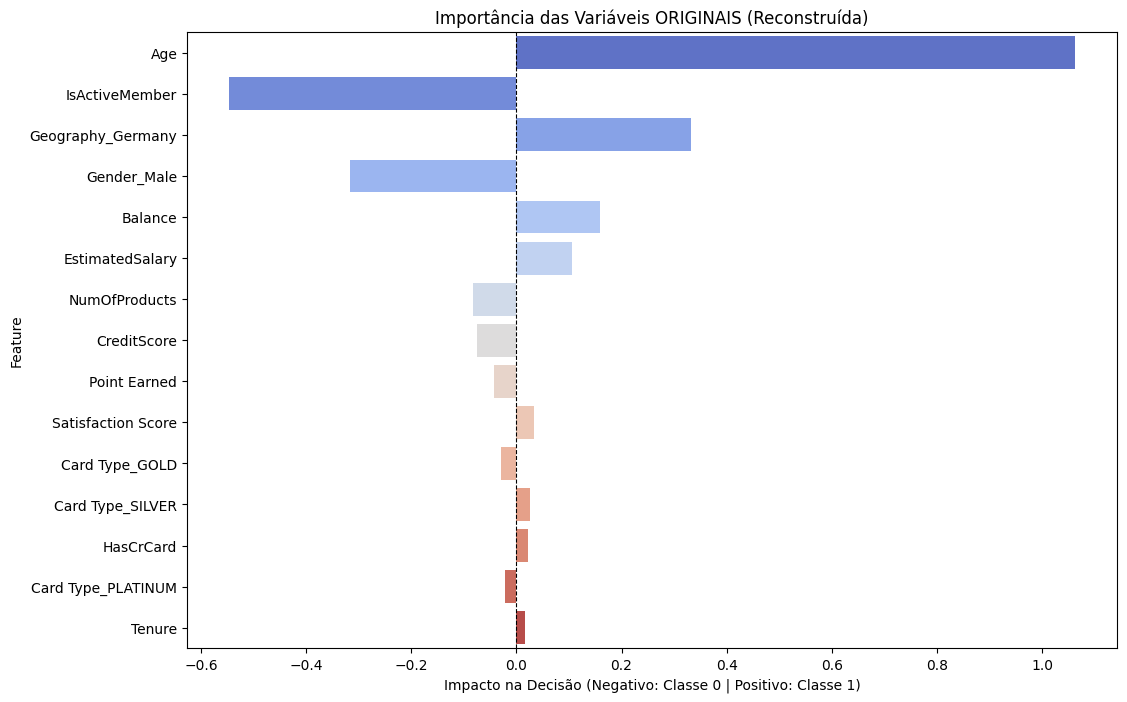

              Feature  Importance
1                 Age    1.061984
6      IsActiveMember   -0.545934
10  Geography_Germany    0.331946
12        Gender_Male   -0.315508
3             Balance    0.159284


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Acessar os passos do Pipeline
step_pca = model_pipeline.named_steps.get('pca')   # Tenta pegar o PCA
step_model = model_pipeline.named_steps['model']   # Pega o modelo

# 2. Obter os coeficientes do modelo (Pesos dos Componentes)
if hasattr(step_model, 'coef_'):
    # Para Regressão Logística (formato [[w1, w2...]])
    model_weights = step_model.coef_[0]
elif hasattr(step_model, 'feature_importances_'):
    # Para Árvores (mas atenção: árvores + PCA é difícil de reverter perfeitamente assim)
    model_weights = step_model.feature_importances_
else:
    raise ValueError("Modelo sem coeficientes ou importâncias acessíveis.")

# 3. Engenharia Reversa (Back-projection)
# Se existe PCA, precisamos multiplicar os pesos pelos componentes
if step_pca is not None:
    print("🔄 Reconstruindo pesos originais a partir do PCA...")
    # Matriz de Componentes (n_components, n_features_originais)
    pca_components = step_pca.components_

    # Produto escalar: Pesos_Model * Componentes_PCA = Pesos_Originais
    # (n_comp) * (n_comp, n_orig) -> (n_orig)
    original_importances = np.dot(model_weights, pca_components)
else:
    print("✅ Sem PCA, usando pesos diretos.")
    original_importances = model_weights

# 4. Criar DataFrame com NOMES ORIGINAIS
# Agora 'original_importances' tem o mesmo tamanho de 'X_train.columns'
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,  # Aqui forçamos os nomes originais
    'Importance': original_importances,
    'Abs_Importance': np.abs(original_importances) # Para ordenar
}).sort_values(by='Abs_Importance', ascending=False)

# 5. Plotar
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    hue='Feature',
    data=feature_importance_df.head(15),
    palette='coolwarm',
    legend=False
)

plt.title('Importância das Variáveis ORIGINAIS (Reconstruída)')
plt.xlabel('Impacto na Decisão (Negativo: Classe 0 | Positivo: Classe 1)')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.show()

print(feature_importance_df.head(5)[['Feature', 'Importance']])